# SavorSafe: Restaurant Risk & ViolationPredictor

**Introduction**


*   Foodborne illness remains a critical public health challenge, and restaurant sanitation is a major determinant in preventing preventable outbreaks within the City of Chicago.
*   Based on the Chicago Department of Public Health’s Food Inspections records, the city performs tens of thousands of inspections each year, and outcomes vary based on seasonality, risk level, food handling practices and establishment characteristics.
*   Understanding which types of facilities fail more often, what violation categories repeatedly occur, and whether food safety is improving or declining over time is essential for designing stronger regulatory strategies and preventive interventions.
*   This project, SavorSafe uses the publicly available Food Inspections Dataset from the Chicago Data Portal.
*   The dataset includes historical inspection results, risk level classifications, violation codes, establishment types and geographic information enabling data-driven identification of patterns behind inspection failures.
*   Goal: Evaluate past inspection data to determine trends in food safety across Chicago and identify the strongest predictors of inspection failure.

*   Focus: Facility Type comparisons, Risk Level analysis, Chain vs Independent differences, temporal patterns, violation trend analysis and failure likelihood prediction signals.

*   Impact: Provide evidence-based insights to help health departments prioritize inspection resources, inform policy planning on food safety standards, guide restaurants toward improved compliance, and contribute towards building a healthier dining ecosystem for all Chicago residents.

# Any Changes Since the Proposal

**Scope status**

Core goal unchanged: Analyze Chicago food inspections and build signals for failure risk & violation themes. We’re still on the “risk & violations” track.

# Data Preparation & Cleaning Overview

In this stage, we transformed the raw Chicago Food Inspections dataset into an analysis-ready table and a trimmed EDA slice.

## 1) Data Loading & Sampling

*  Input: Food_Inspections_20251106.csv (299,868 rows; 2010-01-04 → 2025-11-05).
*  Loaded in Google Colab from Drive.

## 2) Data Cleaning & Preprocessing

*   Schema standardization: Renamed columns to a consistent schema (e.g., inspection_id, inspection_date, inspection_type, facility_type, result, risk_raw, lat, lon, etc.).
*  Date standardization: Parsed inspection_date to proper datetimes; dropped rows with missing inspection_date (time-based analyses require it).
*  Duplicate handling: De-duplicated by inspection_id (kept the record with the latest inspection_date when duplicates existed).
*  Geospatial QA: Coerced lat/lon to numeric; values outside a Chicago bounding box were set to NaN (row retained, point excluded).
*   Chicago-only enforcement: Filtered to CHICAGO, IL (case-insensitive); removed redundant city/state/Location after filtering.
*  Redundant/raw fields removed: Dropped superseded columns (license, result, risk_raw, zip) after deriving their cleaned counterparts.

## 3) Feature Engineering

*   Outcome normalization: Collapsed heterogeneous result strings to result_norm ∈ {PASS, PASS_CONDITIONS, FAIL, OUT_OF_BUSINESS, NO_ENTRY, NOT_READY, OTHER, UNKNOWN} and created is_fail = 1(result_norm == FAIL).
*   Risk extraction: Parsed risk_raw into risk_level ∈ {1,2,3} (High/Med/Low). Left NaN where the source was missing/non-standard (e.g., “All”)—no imputation.
*   Identifiers & categories:
    1.   inspection_id → nullable int (Int64).
    2.   license_id → cleaned digit string (preserves leading zeros).
    3.   Text hygiene (trim/collapse spaces; title-case for facility_type, inspection_type, dba_name)
    
*  ZIP normalization: Extracted zip5 (5-digit string).

*  Violations text: Kept a single cleaned field violations_text_clean (lowercased, whitespace-collapsed) and a lightweight violation_count heuristic; dropped raw violations_text.
*  Calendar helpers: Added year and month for fast grouping (removed year_month since we compute months on the fly in EDA).

## 4) Temporal Filtering

*   For EDA and recent-trend visuals, created a trimmed slice with records ≥ 2018-01-01.
*   The master clean file retains the full history for reproducibility.

## 5) Data Export
The main processed dataset (food_inspections_clean_2018plus.csv) with all cleaning and enrichment applied.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 200)

CSV_PATH = Path("/content/drive/MyDrive/418-Project/Food_Inspections_20251106.csv")

assert CSV_PATH.exists(), f"File not found at: {CSV_PATH}. Check the path and that Drive is mounted."

df_sub = pd.read_csv(CSV_PATH, low_memory=False)

print(f"Loaded: {CSV_PATH.name}")
print(f"Shape: {df_sub.shape[0]:,} rows × {df_sub.shape[1]} columns")
mem_mb = df_sub.memory_usage(deep=True).sum() / (1024**2)
print(f"Approx RAM footprint: {mem_mb:.2f} MB")
print("First 10 columns:", list(df_sub.columns[:10]))

df_sub.info()
df_sub.head(5)

Loaded: Food_Inspections_20251106.csv
Shape: 299,868 rows × 17 columns
Approx RAM footprint: 473.92 MB
First 10 columns: ['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299868 entries, 0 to 299867
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    299868 non-null  int64  
 1   DBA Name         299868 non-null  object 
 2   AKA Name         297457 non-null  object 
 3   License #        299850 non-null  float64
 4   Facility Type    294598 non-null  object 
 5   Risk             299782 non-null  object 
 6   Address          299868 non-null  object 
 7   City             299702 non-null  object 
 8   State            299806 non-null  object 
 9   Zip              299827 non-null  float64
 10  Inspection Date  299868 non-null  object 
 11  Inspection Type  299867 non-null  obj

Inspection ID                           DBA Name                      AKA Name  License #                 Facility Type           Risk             Address     City State  \
0        2626571       LITTLE PEOPLE LEARNING, INC.  LITTLE PEOPLE LEARNING, INC.  2808565.0  Children's Services Facility  Risk 1 (High)      1448 E 53RD ST  CHICAGO    IL   
1        2626550  AKIBA-SCHECHTER JEWISH DAY SCHOOL             JEWISH DAY SCHOOL  2275647.0                        School  Risk 1 (High)  5235 S CORNELL AVE  CHICAGO    IL   
2        2626464                THE DEARBORN TAVERN  THE DEARBORN TAVERN (T5 M10)  3056426.0                    Restaurant   Risk 3 (Low)   11601 W TOUHY AVE  CHICAGO    IL   
3        2626469         KOKO'S MEDITERRANEAN GRILL    KOKO'S MEDITERRANEAN GRILL  2293013.0                    Restaurant  Risk 1 (High)  1760 W CHICAGO AVE  CHICAGO    IL   
4        2626468                    BUTTER AND VINE               BUTTER AND VINE  3056669.0                      Catering  Risk 1 (High)    7280 W DEVON AVE  CHICAGO    IL   

       Zip Inspection Date        Inspection Type Results  \
0  60615.0      11/05/2025                Canvass    Pass   
1  60615.0      11/05/2025                Canvass    Fail   
2  60666.0      11/04/2025                License    Pass   
3  60622.0      11/04/2025  Canvass Re-Inspection    Pass   
4  60631.0      11/04/2025                License    Pass   

                                                                                                                                                                                                Violations  \
0  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED DUST BUILDUP ON VENTILATION FANS IN WASHROOM. INSTRUCTED MANAGER TO CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALL...   
1  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: OBSERVED OVER 100 MICE DROPPINGS SCATTERED ON FLOOR ALONG WALLS AND CORNERS UNDER 3-COMPARTMENT SINK, DRAINBOARDS, EQUIPMENT, ETC, NEAR STOV...   
2                                                                                                                                                                                                      NaN   
3  37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments:  3-302.12 : MUST LABEL FOOD STORAGE CONTAINERS WHEN FOOD IS NOT IN ORIGINAL PACKAGE. | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comme...   
4                                                                                                                                                                                                      NaN   

    Latitude  Longitude                                  Location  
0  41.799644 -87.589889   (41.799644393031706, -87.5898891363337)  
1  41.800198 -87.585560  (41.800198231934665, -87.58556039872956)  
2  42.008751 -87.906874   (42.00875076599798, -87.90687413400109)  
3  41.896103 -87.672116   (41.89610267284695, -87.67211594992528)  
4  41.997277 -87.809624   (41.99727682798901, -87.80962433024467)

In [ ]:
# Cell 2: Schema standardization

import pandas as pd
import numpy as np

def find_col(df, candidates):
    """Return the first column from `candidates` that exists in df, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Map logical fields to actual column names (if present)
CAND = {
    "inspection_id": ["Inspection ID","InspectionID","inspection_id","ID","Id"],
    "result":        ["Results","Result"],
    "risk":          ["Risk"],
    "facility_type": ["Facility Type","FacilityType"],
    "inspection_type":["Inspection Type","InspectionType"],
    "dba_name":      ["DBA Name","AKA Name","Name"],
    "license":       ["License #","License Number","license_","License"],
    "address":       ["Address","Address Street","Street Address","Address 1","Address Line 1"],
    "city":          ["City"],
    "state":         ["State"],
    "zip":           ["ZIP","Zip","Zipcode","Zip Code","POSTAL CODE"],
    "lat":           ["Latitude","LATITUDE","lat","Lat"],
    "lon":           ["Longitude","LONGITUDE","lon","Lng","Long"],
    "violations":    ["Violations","Violation Description","Violation","violations"],
    "inspection_date":["Inspection Date","inspection_date","Date","Activity Date"]
}

schema_map = {k: find_col(df_sub, v) for k, v in CAND.items()}

print("=== Column overview ===")
print(f"Total columns: {df_sub.shape[1]}")
print("First 25 columns:", list(df_sub.columns[:25]))
print("\n=== Logical → Actual column mapping (if found) ===")
for k, v in schema_map.items():
    print(f"{k:16} -> {v}")

# Duplicates and key candidate checks
dup_rows = int(df_sub.duplicated().sum())
print(f"\n=== Duplicates ===\nExact duplicate rows: {dup_rows}")

if schema_map["inspection_id"]:
    col = schema_map["inspection_id"]
    nun = df_sub[col].nunique(dropna=True)
    nulls = df_sub[col].isna().sum()
    print(f"\n=== Candidate primary key: {col} ===")
    print(f"Unique values: {nun:,}  |  Nulls: {nulls:,}  |  Equals #rows: {nun == len(df_sub)}")

# Missingness (top 15)
miss = df_sub.isna().sum().sort_values(ascending=False)
miss_df = (
    miss.head(15)
    .to_frame("missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(df_sub)).round(4))
)
print("\n=== Top 15 columns by missing values ===")
display(miss_df)

# Date columns: coverage & ranges (no mutation)
date_like = [c for c in df_sub.columns if ("date" in c.lower()) or (c.lower() in {"activity date","inspection date"})]
date_rows = []
for c in date_like:
    s = pd.to_datetime(df_sub[c], errors="coerce", infer_datetime_format=True)
    if s.notna().any():
        date_rows.append({
            "column": c,
            "non_null_ratio": float(s.notna().mean()),
            "min": s.min(),
            "max": s.max()
        })
date_cov = pd.DataFrame(date_rows).sort_values("non_null_ratio", ascending=False) if date_rows else pd.DataFrame(columns=["column","non_null_ratio","min","max"])
print("\n=== Date columns (coverage & min/max) ===")
display(date_cov)

# Choose a canonical inspection date if available
canonical_inspection_date = schema_map["inspection_date"] or (date_cov["column"].iloc[0] if len(date_cov) else None)
print(f"Canonical inspection date candidate: {canonical_inspection_date}")

# Basic distributions for key categoricals
def top_counts(col, k=10):
    s = df_sub[col].value_counts(dropna=False).head(k)
    return pd.DataFrame({col: s.index.astype(str), "count": s.values})

if schema_map["result"]:
    print(f"\n=== Result distribution (top 10) — {schema_map['result']} ===")
    display(top_counts(schema_map["result"], 10))

if schema_map["risk"]:
    print(f"\n=== Risk distribution (top 10) — {schema_map['risk']} ===")
    display(top_counts(schema_map["risk"], 10))

if schema_map["facility_type"]:
    print(f"\n=== Facility Type distribution (top 10) — {schema_map['facility_type']} ===")
    display(top_counts(schema_map["facility_type"], 10))

if schema_map["inspection_type"]:
    print(f"\n=== Inspection Type distribution (top 10) — {schema_map['inspection_type']} ===")
    display(top_counts(schema_map["inspection_type"], 10))

# Geo sanity checks (if lat/lon exist)
lat_c, lon_c = schema_map["lat"], schema_map["lon"]
if lat_c and lon_c:
    lat = pd.to_numeric(df_sub[lat_c], errors="coerce")
    lon = pd.to_numeric(df_sub[lon_c], errors="coerce")
    both = lat.notna() & lon.notna()
    print("\n=== Geo summary ===")
    print(f"Lat/Lon both non-null ratio: {both.mean():.3f}")
    if both.any():
        print(f"Latitude range: {lat[both].min():.5f} .. {lat[both].max():.5f}")
        print(f"Longitude range: {lon[both].min():.5f} .. {lon[both].max():.5f}")
        # Chicago-ish bounding box rough check
        in_chi = both & (lat.between(41.4, 42.3)) & (lon.between(-88.1, -87.4))
        print(f"Within rough Chicago bounds: {in_chi.mean():.3f} of non-null points")

=== Column overview ===
Total columns: 17
First 25 columns: ['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date', 'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude', 'Location']

=== Logical → Actual column mapping (if found) ===
inspection_id    -> Inspection ID
result           -> Results
risk             -> Risk
facility_type    -> Facility Type
inspection_type  -> Inspection Type
dba_name         -> DBA Name
license          -> License #
address          -> Address
city             -> City
state            -> State
zip              -> Zip
lat              -> Latitude
lon              -> Longitude
violations       -> Violations
inspection_date  -> Inspection Date

=== Duplicates ===
Exact duplicate rows: 0

=== Candidate primary key: Inspection ID ===
Unique values: 299,868  |  Nulls: 0  |  Equals #rows: True

=== Top 15 columns by missing values ===


missing_count  missing_pct
Violations               83671       0.2790
Facility Type             5270       0.0176
AKA Name                  2411       0.0080
Longitude                 1028       0.0034
Location                  1028       0.0034
Latitude                  1028       0.0034
City                       166       0.0006
Risk                        86       0.0003
State                       62       0.0002
Zip                         41       0.0001
License #                   18       0.0001
Inspection Type              1       0.0000
Inspection ID                0       0.0000
Address                      0       0.0000
DBA Name                     0       0.0000


=== Date columns (coverage & min/max) ===


/tmp/ipython-input-3650987602.py:66: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_sub[c], errors="coerce", infer_datetime_format=True)


column  non_null_ratio        min        max
0  Inspection Date             1.0 2010-01-04 2025-11-05

Canonical inspection date candidate: Inspection Date

=== Result distribution (top 10) — Results ===


Results   count
0                  Pass  154950
1                  Fail   58008
2    Pass w/ Conditions   44840
3       Out of Business   24816
4              No Entry   13032
5             Not Ready    4129
6  Business Not Located      93


=== Risk distribution (top 10) — Risk ===


Risk   count
0    Risk 1 (High)  222124
1  Risk 2 (Medium)   54024
2     Risk 3 (Low)   23555
3              nan      86
4              All      79


=== Facility Type distribution (top 10) — Facility Type ===


Facility Type   count
0                       Restaurant  202677
1                    Grocery Store   36425
2                           School   18849
3     Children's Services Facility    7174
4                              nan    5270
5                           Bakery    4306
6  Daycare Above and Under 2 Years    3991
7            Daycare (2 - 6 Years)    3191
8                   Long Term Care    2323
9                         Catering    1859


=== Inspection Type distribution (top 10) — Inspection Type ===


Inspection Type   count
0                   Canvass  155207
1                   License   40125
2     Canvass Re-Inspection   33594
3                 Complaint   28140
4     License Re-Inspection   12399
5   Complaint Re-Inspection   11842
6      Short Form Complaint    8910
7            Non-Inspection    4807
8  Suspected Food Poisoning     996
9              Consultation     679


=== Geo summary ===
Lat/Lon both non-null ratio: 0.997
Latitude range: 41.64467 .. 42.02106
Longitude range: -87.90687 .. -87.52509
Within rough Chicago bounds: 0.997 of non-null points


In [ ]:
# Cell 3: Date parsing & calendar fields

import re
import numpy as np
import pandas as pd

# 1) Map logical fields to actual column names in your df_sub
def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

CAND = {
    "inspection_id": ["Inspection ID","InspectionID","inspection_id","ID","Id"],
    "result":        ["Results","Result"],
    "risk":          ["Risk"],
    "facility_type": ["Facility Type","FacilityType"],
    "inspection_type":["Inspection Type","InspectionType"],
    "dba_name":      ["DBA Name","AKA Name","Name"],
    "license":       ["License #","License Number","license_","License"],
    "address":       ["Address","Address Street","Street Address","Address 1","Address Line 1"],
    "city":          ["City"],
    "state":         ["State"],
    "zip":           ["ZIP","Zip","Zipcode","Zip Code","POSTAL CODE"],
    "lat":           ["Latitude","LATITUDE","lat","Lat"],
    "lon":           ["Longitude","LONGITUDE","lon","Lng","Long"],
    "violations":    ["Violations","Violation Description","Violation","violations"],
    "inspection_date":["Inspection Date","inspection_date","Date","Activity Date"]
}

schema_map = {k: pick(df_sub, v) for k, v in CAND.items()}

# Build a rename map from actual -> canonical
rename_map = {
    schema_map["inspection_id"]: "inspection_id",
    schema_map["result"]: "result",
    schema_map["risk"]: "risk_raw",
    schema_map["facility_type"]: "facility_type",
    schema_map["inspection_type"]: "inspection_type",
    schema_map["dba_name"]: "dba_name",
    schema_map["license"]: "license",
    schema_map["address"]: "address",
    schema_map["city"]: "city",
    schema_map["state"]: "state",
    schema_map["zip"]: "zip",
    schema_map["lat"]: "lat",
    schema_map["lon"]: "lon",
    schema_map["violations"]: "violations_text",
    schema_map["inspection_date"]: "inspection_date",
}
# Drop any None keys in rename_map
rename_map = {k:v for k,v in rename_map.items() if k is not None}

# 2) Create working copy with standardized names
df_clean = df_sub.rename(columns=rename_map).copy()

# 3) Dates & calendar fields
if "inspection_date" in df_clean.columns:
    df_clean["inspection_date"] = pd.to_datetime(df_clean["inspection_date"], errors="coerce")
    df_clean["year"] = df_clean["inspection_date"].dt.year
    df_clean["month"] = df_clean["inspection_date"].dt.month
    df_clean["year_month"] = df_clean["inspection_date"].dt.to_period("M").astype(str)

# 4) Normalize Results to a compact taxonomy + binary label
def norm_result(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return "UNKNOWN"
    s = str(x).strip().lower()
    if s == "fail":
        return "FAIL"
    if s.startswith("pass w"):
        return "PASS_CONDITIONS"
    if s == "pass":
        return "PASS"
    if "out of business" in s:
        return "OUT_OF_BUSINESS"
    if "no entry" in s:
        return "NO_ENTRY"
    if "not ready" in s:
        return "NOT_READY"
    return "OTHER"

if "result" in df_clean.columns:
    df_clean["result_norm"] = df_clean["result"].apply(norm_result)
    df_clean["is_fail"] = (df_clean["result_norm"] == "FAIL").astype(int)

# 5) Risk → numeric level (1=High, 2=Medium, 3=Low)
def risk_to_level(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return np.nan
    s = str(x)
    m = re.search(r"Risk\s*([123])", s)
    if m:
        return int(m.group(1))
    # sometimes "High/Medium/Low" only
    s2 = s.strip().lower()
    if "high" in s2: return 1
    if "medium" in s2: return 2
    if "low" in s2: return 3
    return np.nan

if "risk_raw" in df_clean.columns:
    df_clean["risk_level"] = df_clean["risk_raw"].apply(risk_to_level)

# 6) Zip as 5-digit string (if present)
if "zip" in df_clean.columns:
    z = df_clean["zip"].astype(str).str.extract(r"(\d{5})", expand=False)
    df_clean["zip5"] = z

# 7) Lat/Lon → numeric + Chicago bounding box flag (no drop yet)
if "lat" in df_clean.columns:
    df_clean["lat"] = pd.to_numeric(df_clean["lat"], errors="coerce")
if "lon" in df_clean.columns:
    df_clean["lon"] = pd.to_numeric(df_clean["lon"], errors="coerce")

if {"lat","lon"}.issubset(df_clean.columns):
    in_bbox = (
        df_clean["lat"].between(41.4, 42.3) &
        df_clean["lon"].between(-88.1, -87.4)
    )
    df_clean["in_chicago_bbox"] = in_bbox

# 8) Derived: quick violations count (heuristic; non-destructive)
if "violations_text" in df_clean.columns:
    s = df_clean["violations_text"].astype(str).fillna("")
    counts = pd.concat([
        s.str.count(r"\|"),
        s.str.count(r";"),
        s.str.count(r"(?<!\d)(\d{1,3})(?!\d)\.")
    ], axis=1).max(axis=1)
    df_clean["violation_count"] = (counts + (counts.gt(0))).astype("Int64")

# 9) Deduplicate exact duplicate rows (conservative)
before = len(df_clean)
df_clean = df_clean.drop_duplicates(keep="first")
after = len(df_clean)
dedup_removed = before - after

# 10) Report a compact summary
print("=== CLEAN SUMMARY ===")
print(f"Rows before/after exact-dedup: {before:,} → {after:,} (removed {dedup_removed:,})")
if "result_norm" in df_clean.columns:
    print("\nResult (normalized) — top 6:")
    print(df_clean["result_norm"].value_counts().head(6))
if "risk_level" in df_clean.columns:
    print("\nRisk level distribution (1=High, 2=Med, 3=Low):")
    print(df_clean["risk_level"].value_counts(dropna=False))
if "in_chicago_bbox" in df_clean.columns:
    cov = df_clean["in_chicago_bbox"].mean()
    print(f"\nChicago bbox coverage (non-null lat/lon in range): {cov:.3f}")
if "inspection_date" in df_clean.columns:
    print(f"\nDate coverage: {df_clean['inspection_date'].min()} → {df_clean['inspection_date'].max()}")

# Peek at key columns
cols_preview = [c for c in [
    "inspection_id","inspection_date","year_month","result","result_norm","is_fail",
    "risk_raw","risk_level","facility_type","inspection_type",
    "dba_name","license","address","city","state","zip5","lat","lon","in_chicago_bbox",
    "violation_count"
] if c in df_clean.columns]

print("\nPreview columns:")
print(cols_preview)
df_clean[cols_preview].head(8)

=== CLEAN SUMMARY ===
Rows before/after exact-dedup: 299,868 → 299,868 (removed 0)

Result (normalized) — top 6:
result_norm
PASS               154950
FAIL                58008
PASS_CONDITIONS     44840
OUT_OF_BUSINESS     24816
NO_ENTRY            13032
NOT_READY            4129
Name: count, dtype: int64

Risk level distribution (1=High, 2=Med, 3=Low):
risk_level
1.0    222124
2.0     54024
3.0     23555
NaN       165
Name: count, dtype: int64

Chicago bbox coverage (non-null lat/lon in range): 0.997

Date coverage: 2010-01-04 00:00:00 → 2025-11-05 00:00:00

Preview columns:
['inspection_id', 'inspection_date', 'year_month', 'result', 'result_norm', 'is_fail', 'risk_raw', 'risk_level', 'facility_type', 'inspection_type', 'dba_name', 'license', 'address', 'city', 'state', 'zip5', 'lat', 'lon', 'in_chicago_bbox', 'violation_count']


inspection_id inspection_date year_month result result_norm  is_fail       risk_raw  risk_level                 facility_type        inspection_type  \
0        2626571      2025-11-05    2025-11   Pass        PASS        0  Risk 1 (High)         1.0  Children's Services Facility                Canvass   
1        2626550      2025-11-05    2025-11   Fail        FAIL        1  Risk 1 (High)         1.0                        School                Canvass   
2        2626464      2025-11-04    2025-11   Pass        PASS        0   Risk 3 (Low)         3.0                    Restaurant                License   
3        2626469      2025-11-04    2025-11   Pass        PASS        0  Risk 1 (High)         1.0                    Restaurant  Canvass Re-Inspection   
4        2626468      2025-11-04    2025-11   Pass        PASS        0  Risk 1 (High)         1.0                      Catering                License   
5        2626498      2025-11-04    2025-11   Pass        PASS        0  Risk 1 (High)         1.0                    Restaurant              Complaint   
6        2626477      2025-11-04    2025-11   Pass        PASS        0  Risk 1 (High)         1.0  Children's Services Facility                Canvass   
7        2626496      2025-11-04    2025-11   Pass        PASS        0  Risk 1 (High)         1.0                    Restaurant  Canvass Re-Inspection   

                            dba_name    license                   address     city state   zip5        lat        lon  in_chicago_bbox  violation_count  
0       LITTLE PEOPLE LEARNING, INC.  2808565.0            1448 E 53RD ST  CHICAGO    IL  60615  41.799644 -87.589889             True                3  
1  AKIBA-SCHECHTER JEWISH DAY SCHOOL  2275647.0        5235 S CORNELL AVE  CHICAGO    IL  60615  41.800198 -87.585560             True                5  
2                THE DEARBORN TAVERN  3056426.0         11601 W TOUHY AVE  CHICAGO    IL  60666  42.008751 -87.906874             True                0  
3         KOKO'S MEDITERRANEAN GRILL  2293013.0        1760 W CHICAGO AVE  CHICAGO    IL  60622  41.896103 -87.672116             True               13  
4                    BUTTER AND VINE  3056669.0          7280 W DEVON AVE  CHICAGO    IL  60631  41.997277 -87.809624             True                0  
5                          PIZZA HUT  3026454.0          2516 W NORTH AVE  CHICAGO    IL  60647  41.910397 -87.690367             True                0  
6               Smart From The Start  2216184.0  4133-4139 W Armitage AVE  CHICAGO    IL  60639  41.917007 -87.730359             True                2  
7            LA BIRRIERIA RESTAURANT  2776046.0          4743 W GRAND AVE  CHICAGO    IL  60639  41.913430 -87.745070             True                2

In [ ]:
df_clean.shape

(299868, 26)

In [ ]:
# Cell 4: Outcome normalization and Risk extraction

import re
import numpy as np
import pandas as pd

df_ready = df_clean.copy()

# 1) Types / IDs
# inspection_id: prefer integer-like if possible, else string
if "inspection_id" in df_ready.columns:
    # Many CSVs load IDs as float; try to coerce safely
    try:
        # if it looks numeric, cast to Int64 (nullable)
        tmp = pd.to_numeric(df_ready["inspection_id"], errors="coerce")
        if tmp.notna().any():
            df_ready["inspection_id"] = tmp.astype("Int64")
        # keep a string version for joins/logging if needed
        df_ready["inspection_id_str"] = df_ready["inspection_id"].astype(str)
    except Exception:
        df_ready["inspection_id_str"] = df_ready["inspection_id"].astype(str)

# license: keep as string to preserve leading zeros if any
if "license" in df_ready.columns:
    # extract digits; keep as string
    lic = df_ready["license"].astype(str).str.extract(r"(\d+)", expand=False)
    df_ready["license_str"] = lic

# 2) Normalize key text columns (trim, collapse spaces, title/upper as appropriate)
def norm_text(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

def norm_title(s):
    s = norm_text(s)
    return s.title() if isinstance(s, str) else s

def norm_upper(s):
    s = norm_text(s)
    return s.upper() if isinstance(s, str) else s

for col in ["facility_type", "inspection_type", "dba_name"]:
    if col in df_ready.columns:
        df_ready[col] = df_ready[col].apply(norm_title)

for col in ["city", "state", "address"]:
    if col in df_ready.columns:
        # Addresses: keep case mixed but trim/collapse spaces
        if col == "address":
            df_ready[col] = df_ready[col].apply(norm_text)
        else:
            df_ready[col] = df_ready[col].apply(norm_upper)

# 3) Results / Risk sanity (already standardized earlier)
# Ensure result_norm is limited to expected labels
if "result_norm" in df_ready.columns:
    allowed = {
        "PASS","PASS_CONDITIONS","FAIL","OUT_OF_BUSINESS","NO_ENTRY","NOT_READY","OTHER","UNKNOWN"
    }
    df_ready.loc[~df_ready["result_norm"].isin(allowed), "result_norm"] = "OTHER"

# risk_level must be in {1,2,3} or NaN
if "risk_level" in df_ready.columns:
    df_ready.loc[~df_ready["risk_level"].isin([1,2,3]), "risk_level"] = np.nan
    df_ready["risk_level"] = df_ready["risk_level"].astype("Int64")

# 4) ZIP: keep 5-digit string where possible
if "zip5" in df_ready.columns:
    z = df_ready["zip5"].astype(str).str.extract(r"(\d{5})", expand=False)
    df_ready["zip5"] = z

# 5) Dates: drop rows with missing inspection_date
before = len(df_ready)
if "inspection_date" in df_ready.columns:
    df_ready = df_ready[df_ready["inspection_date"].notna()].copy()
after = len(df_ready)
dropped_missing_date = before - after

# 6) Deduplicate by inspection_id (keep the latest inspection_date if duplicates exist)
dedup_by_id = 0
if "inspection_id" in df_ready.columns:
    if df_ready["inspection_id"].notna().any():
        # count duplicates
        dup_mask = df_ready["inspection_id"].duplicated(keep=False)
        if dup_mask.any():
            dedup_by_id = int(dup_mask.sum())
            df_ready = (
                df_ready.sort_values(["inspection_id", "inspection_date"])
                        .drop_duplicates(subset=["inspection_id"], keep="last")
                        .copy()
            )

# 7) Geo: keep values but set out-of-Chicago-bounds to NaN (so we don't plot bad points)
oob_to_nan = 0
if {"lat","lon","in_chicago_bbox"}.issubset(df_ready.columns):
    oob_mask = df_ready["in_chicago_bbox"] == False
    oob_to_nan = int(oob_mask.sum())
    # If clearly out of bounds, null out coords but keep the record
    df_ready.loc[oob_mask, ["lat","lon"]] = np.nan

# 8) Violation count: ensure non-negative integers
if "violation_count" in df_ready.columns:
    vc = pd.to_numeric(df_ready["violation_count"], errors="coerce").fillna(0)
    vc[vc < 0] = 0
    df_ready["violation_count"] = vc.astype("Int64")

# 9) Compact report
print("=== CLEANING REPORT ===")
print(f"Rows dropped due to missing inspection_date: {dropped_missing_date}")
print(f"Rows involved in duplicate inspection_id groups (kept latest): {dedup_by_id}")
print(f"Out-of-bounds lat/lon set to NaN (kept rows): {oob_to_nan}")

# Show a quick preview of cleaned key fields
cols_preview = [c for c in [
    "inspection_id","inspection_id_str","inspection_date","year_month",
    "result_norm","is_fail","risk_level","facility_type","inspection_type",
    "dba_name","license_str","address","city","state","zip5","lat","lon",
    "violation_count"
] if c in df_ready.columns]

print("\nPreview columns:")
print(cols_preview)
df_ready[cols_preview].head(8)

=== CLEANING REPORT ===
Rows dropped due to missing inspection_date: 0
Rows involved in duplicate inspection_id groups (kept latest): 0
Out-of-bounds lat/lon set to NaN (kept rows): 1028

Preview columns:
['inspection_id', 'inspection_id_str', 'inspection_date', 'year_month', 'result_norm', 'is_fail', 'risk_level', 'facility_type', 'inspection_type', 'dba_name', 'license_str', 'address', 'city', 'state', 'zip5', 'lat', 'lon', 'violation_count']


inspection_id inspection_id_str inspection_date year_month result_norm  is_fail  risk_level                 facility_type        inspection_type  \
0        2626571           2626571      2025-11-05    2025-11        PASS        0           1  Children'S Services Facility                Canvass   
1        2626550           2626550      2025-11-05    2025-11        FAIL        1           1                        School                Canvass   
2        2626464           2626464      2025-11-04    2025-11        PASS        0           3                    Restaurant                License   
3        2626469           2626469      2025-11-04    2025-11        PASS        0           1                    Restaurant  Canvass Re-Inspection   
4        2626468           2626468      2025-11-04    2025-11        PASS        0           1                      Catering                License   
5        2626498           2626498      2025-11-04    2025-11        PASS        0           1                    Restaurant              Complaint   
6        2626477           2626477      2025-11-04    2025-11        PASS        0           1  Children'S Services Facility                Canvass   
7        2626496           2626496      2025-11-04    2025-11        PASS        0           1                    Restaurant  Canvass Re-Inspection   

                            dba_name license_str                   address     city state   zip5        lat        lon  violation_count  
0       Little People Learning, Inc.     2808565            1448 E 53RD ST  CHICAGO    IL  60615  41.799644 -87.589889                3  
1  Akiba-Schechter Jewish Day School     2275647        5235 S CORNELL AVE  CHICAGO    IL  60615  41.800198 -87.585560                5  
2                The Dearborn Tavern     3056426         11601 W TOUHY AVE  CHICAGO    IL  60666  42.008751 -87.906874                0  
3         Koko'S Mediterranean Grill     2293013        1760 W CHICAGO AVE  CHICAGO    IL  60622  41.896103 -87.672116               13  
4                    Butter And Vine     3056669          7280 W DEVON AVE  CHICAGO    IL  60631  41.997277 -87.809624                0  
5                          Pizza Hut     3026454          2516 W NORTH AVE  CHICAGO    IL  60647  41.910397 -87.690367                0  
6               Smart From The Start     2216184  4133-4139 W Armitage AVE  CHICAGO    IL  60639  41.917007 -87.730359                2  
7            La Birrieria Restaurant     2776046          4743 W GRAND AVE  CHICAGO    IL  60639  41.913430 -87.745070                2

In [ ]:
df_ready.shape

(299868, 28)

In [ ]:
# Cell 5: IDs & categoricals, removed unwanted columns

import re
import numpy as np
import pandas as pd

df_final = df_ready.copy()

to_drop = []

if "in_chicago_bbox" in df_final.columns:
    to_drop.append("in_chicago_bbox")
if "inspection_id_str" in df_final.columns:
    to_drop.append("inspection_id_str")

# Drop original 'license' if present, and keep license_str as canonical
if "license" in df_final.columns:
    to_drop.append("license")

if "result" in df_final.columns:
    to_drop.append("result")
if "risk_raw" in df_final.columns:
    to_drop.append("risk_raw")

if to_drop:
    df_final = df_final.drop(columns=[c for c in to_drop if c in df_final.columns])

# Rename license_str → license_id
if "license_str" in df_final.columns:
    df_final = df_final.rename(columns={"license_str": "license_id"})

# Light-clean violations text into a separate column (no heavy NLP yet)
if "violations_text" in df_final.columns:
    def light_clean(s):
        if pd.isna(s):
            return np.nan
        s = str(s).strip()
        s = re.sub(r"\s+", " ", s)
        return s.lower()

    df_final["violations_text_clean"] = df_final["violations_text"].apply(light_clean)

col_order = [
    c for c in [
        "inspection_id", "inspection_date", "year_month",
        "result_norm", "is_fail", "risk_level",
        "facility_type", "inspection_type",
        "dba_name", "license_id", "address", "city", "state", "zip5",
        "lat", "lon",
        "violation_count", "violations_text", "violations_text_clean"
    ]
    if c in df_final.columns
]

df_final = df_final[col_order + [c for c in df_final.columns if c not in col_order]]

print("=== FINALIZED CLEAN TABLE ===")
print(f"Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")
print("Columns (first 20):", list(df_final.columns[:20]))
print("\nHead:")
display(df_final.head(8))

=== FINALIZED CLEAN TABLE ===
Shape: 299,868 rows × 24 columns
Columns (first 20): ['inspection_id', 'inspection_date', 'year_month', 'result_norm', 'is_fail', 'risk_level', 'facility_type', 'inspection_type', 'dba_name', 'license_id', 'address', 'city', 'state', 'zip5', 'lat', 'lon', 'violation_count', 'violations_text', 'violations_text_clean', 'AKA Name']

Head:


inspection_id inspection_date year_month result_norm  is_fail  risk_level                 facility_type        inspection_type                           dba_name license_id  \
0        2626571      2025-11-05    2025-11        PASS        0           1  Children'S Services Facility                Canvass       Little People Learning, Inc.    2808565   
1        2626550      2025-11-05    2025-11        FAIL        1           1                        School                Canvass  Akiba-Schechter Jewish Day School    2275647   
2        2626464      2025-11-04    2025-11        PASS        0           3                    Restaurant                License                The Dearborn Tavern    3056426   
3        2626469      2025-11-04    2025-11        PASS        0           1                    Restaurant  Canvass Re-Inspection         Koko'S Mediterranean Grill    2293013   
4        2626468      2025-11-04    2025-11        PASS        0           1                      Catering                License                    Butter And Vine    3056669   
5        2626498      2025-11-04    2025-11        PASS        0           1                    Restaurant              Complaint                          Pizza Hut    3026454   
6        2626477      2025-11-04    2025-11        PASS        0           1  Children'S Services Facility                Canvass               Smart From The Start    2216184   
7        2626496      2025-11-04    2025-11        PASS        0           1                    Restaurant  Canvass Re-Inspection            La Birrieria Restaurant    2776046   

                    address     city state   zip5        lat        lon  violation_count  \
0            1448 E 53RD ST  CHICAGO    IL  60615  41.799644 -87.589889                3   
1        5235 S CORNELL AVE  CHICAGO    IL  60615  41.800198 -87.585560                5   
2         11601 W TOUHY AVE  CHICAGO    IL  60666  42.008751 -87.906874                0   
3        1760 W CHICAGO AVE  CHICAGO    IL  60622  41.896103 -87.672116               13   
4          7280 W DEVON AVE  CHICAGO    IL  60631  41.997277 -87.809624                0   
5          2516 W NORTH AVE  CHICAGO    IL  60647  41.910397 -87.690367                0   
6  4133-4139 W Armitage AVE  CHICAGO    IL  60639  41.917007 -87.730359                2   
7          4743 W GRAND AVE  CHICAGO    IL  60639  41.913430 -87.745070                2   

                                                                                                                                                                                           violations_text  \
0  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED DUST BUILDUP ON VENTILATION FANS IN WASHROOM. INSTRUCTED MANAGER TO CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALL...   
1  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: OBSERVED OVER 100 MICE DROPPINGS SCATTERED ON FLOOR ALONG WALLS AND CORNERS UNDER 3-COMPARTMENT SINK, DRAINBOARDS, EQUIPMENT, ETC, NEAR STOV...   
2                                                                                                                                                                                                      NaN   
3  37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments:  3-302.12 : MUST LABEL FOOD STORAGE CONTAINERS WHEN FOOD IS NOT IN ORIGINAL PACKAGE. | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comme...   
4                                                                                                                                                                                                      NaN   
5                                                                                                                                                                                                      NaN   
6  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED BASE COLUMN OF WALL IN HALLWAY NEAR STAFF 

In [ ]:
df_final.shape

(299868, 24)

In [ ]:
# Cell 6: Dropped the original violations_text column; keep only violations_text_clean

import pandas as pd
import numpy as np
import re

# Safety checks
assert "df_final" in globals(), "df_final not found. Run the previous cell first."

before_cols = set(df_final.columns)

# Ensure a cleaned column exists (light fallback if needed)
if "violations_text_clean" not in df_final.columns and "violations_text" in df_final.columns:
    def light_clean(s):
        if pd.isna(s):
            return np.nan
        s = str(s).strip()
        s = re.sub(r"\s+", " ", s)
        return s.lower()

    df_final["violations_text_clean"] = df_final["violations_text"].apply(light_clean)

# Drop the raw text column if present
if "violations_text" in df_final.columns:
    df_final = df_final.drop(columns=["violations_text"])

after_cols = set(df_final.columns)

print("=== COLUMN REMOVAL SUMMARY ===")
print("Removed:", list(before_cols - after_cols))
print("Kept cleaned text column? ", "violations_text_clean" in df_final.columns)
print(f"New shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")

# Quick peek to confirm layout
show_cols = [
    c for c in [
        "inspection_id", "inspection_date", "result_norm", "is_fail", "risk_level",
        "facility_type", "inspection_type", "dba_name", "license_id", "zip5",
        "lat", "lon", "violation_count", "violations_text_clean"
    ]
    if c in df_final.columns
]

display(df_final[show_cols].head(8))

=== COLUMN REMOVAL SUMMARY ===
Removed: ['violations_text']
Kept cleaned text column?  True
New shape: 299,868 rows × 23 columns


inspection_id inspection_date result_norm  is_fail  risk_level                 facility_type        inspection_type                           dba_name license_id   zip5  \
0        2626571      2025-11-05        PASS        0           1  Children'S Services Facility                Canvass       Little People Learning, Inc.    2808565  60615   
1        2626550      2025-11-05        FAIL        1           1                        School                Canvass  Akiba-Schechter Jewish Day School    2275647  60615   
2        2626464      2025-11-04        PASS        0           3                    Restaurant                License                The Dearborn Tavern    3056426  60666   
3        2626469      2025-11-04        PASS        0           1                    Restaurant  Canvass Re-Inspection         Koko'S Mediterranean Grill    2293013  60622   
4        2626468      2025-11-04        PASS        0           1                      Catering                License                    Butter And Vine    3056669  60631   
5        2626498      2025-11-04        PASS        0           1                    Restaurant              Complaint                          Pizza Hut    3026454  60647   
6        2626477      2025-11-04        PASS        0           1  Children'S Services Facility                Canvass               Smart From The Start    2216184  60639   
7        2626496      2025-11-04        PASS        0           1                    Restaurant  Canvass Re-Inspection            La Birrieria Restaurant    2776046  60639   

         lat        lon  violation_count  \
0  41.799644 -87.589889                3   
1  41.800198 -87.585560                5   
2  42.008751 -87.906874                0   
3  41.896103 -87.672116               13   
4  41.997277 -87.809624                0   
5  41.910397 -87.690367                0   
6  41.917007 -87.730359                2   
7  41.913430 -87.745070                2   

                                                                                                                                                                                     violations_text_clean  
0  55. physical facilities installed, maintained & clean - comments: observed dust buildup on ventilation fans in washroom. instructed manager to clean and maintain. | 55. physical facilities install...  
1  38. insects, rodents, & animals not present - comments: observed over 100 mice droppings scattered on floor along walls and corners under 3-compartment sink, drainboards, equipment, etc, near stov...  
2                                                                                                                                                                                                      NaN  
3  37. food properly labeled; original container - comments: 3-302.12 : must label food storage containers when food is not in original package. | 38. insects, rodents, & animals not present - commen...  
4                                                                                                                                                                                                      NaN  
5                                                                                                                                                                                                      NaN  
6  55. physical facilities installed, maintained & clean - comments: observed base column of wall in hallway near staff toilet to be damaged. instructed person in charge to repair and maintain area s...  
7                55. physical facilities installed, maintained & clean - comments: observed build up in drain in bar area under three compartment sink. instructed person in charge to clean and maintain.

In [ ]:
# Cell 7: Final light tidy — drop redundant columns and small text polish, then overwrite CSV

import re
from pathlib import Path
import pandas as pd

assert "df_final" in globals(), "df_final not found. Run previous cells first."

# 1) Drop columns that duplicate existing info:
drop_cols = [c for c in ["zip", "Location"] if c in df_final.columns]
df_final = df_final.drop(columns=drop_cols) if drop_cols else df_final

def fix_apostrophe_s(s):
    if pd.isna(s): return s
    return re.sub(r"'S\b", "'s", str(s))

for col in ["facility_type", "dba_name"]:
    if col in df_final.columns:
        df_final[col] = df_final[col].apply(fix_apostrophe_s)

print("Dropped columns:", drop_cols)
print(f"New shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")

OUT_DIR = Path("/content/drive/MyDrive/418-Project/processed")
CSV_PATH = OUT_DIR / "food_inspections_clean_final.csv"
df_final.to_csv(CSV_PATH, index=False)
print(f"Overwrote CSV with tidy version: {CSV_PATH}")

show_cols = [c for c in [
    "inspection_id","inspection_date","result_norm","facility_type","dba_name",
    "zip5","lat","lon","violation_count","violations_text_clean"
] if c in df_final.columns]
display(df_final[show_cols].head(8))

Dropped columns: ['zip', 'Location']
New shape: 299,868 rows × 21 columns
Overwrote CSV with tidy version: /content/drive/MyDrive/418-Project/processed/food_inspections_clean_final.csv


inspection_id inspection_date result_norm                 facility_type                           dba_name   zip5        lat        lon  violation_count  \
0        2626571      2025-11-05        PASS  Children's Services Facility       Little People Learning, Inc.  60615  41.799644 -87.589889                3   
1        2626550      2025-11-05        FAIL                        School  Akiba-Schechter Jewish Day School  60615  41.800198 -87.585560                5   
2        2626464      2025-11-04        PASS                    Restaurant                The Dearborn Tavern  60666  42.008751 -87.906874                0   
3        2626469      2025-11-04        PASS                    Restaurant         Koko's Mediterranean Grill  60622  41.896103 -87.672116               13   
4        2626468      2025-11-04        PASS                      Catering                    Butter And Vine  60631  41.997277 -87.809624                0   
5        2626498      2025-11-04        PASS                    Restaurant                          Pizza Hut  60647  41.910397 -87.690367                0   
6        2626477      2025-11-04        PASS  Children's Services Facility               Smart From The Start  60639  41.917007 -87.730359                2   
7        2626496      2025-11-04        PASS                    Restaurant            La Birrieria Restaurant  60639  41.913430 -87.745070                2   

                                                                                                                                                                                     violations_text_clean  
0  55. physical facilities installed, maintained & clean - comments: observed dust buildup on ventilation fans in washroom. instructed manager to clean and maintain. | 55. physical facilities install...  
1  38. insects, rodents, & animals not present - comments: observed over 100 mice droppings scattered on floor along walls and corners under 3-compartment sink, drainboards, equipment, etc, near stov...  
2                                                                                                                                                                                                      NaN  
3  37. food properly labeled; original container - comments: 3-302.12 : must label food storage containers when food is not in original package. | 38. insects, rodents, & animals not present - commen...  
4                                                                                                                                                                                                      NaN  
5                                                                                                                                                                                                      NaN  
6  55. physical facilities installed, maintained & clean - comments: observed base column of wall in hallway near staff toilet to be damaged. instructed person in charge to repair and maintain area s...  
7                55. physical facilities installed, maintained & clean - comments: observed build up in drain in bar area under three compartment sink. instructed person in charge to clean and maintain.

In [ ]:
df_final.shape

(299868, 21)

In [ ]:
# Cell 8: Check whether city/state are redundant; drop only if 100% CHICAGO & IL

import pandas as pd
from pathlib import Path

assert "df_final" in globals(), "df_final not found."

n = len(df_final)
city_col = "city" if "city" in df_final.columns else None
state_col = "state" if "state" in df_final.columns else None

print("=== CITY/STATE REDUNDANCY CHECK ===")
if city_col:
    uniq_city = df_final[city_col].dropna().unique()
    non_chi = int((df_final[city_col].fillna("")).str.upper().ne("CHICAGO").sum())
    null_city = int(df_final[city_col].isna().sum())
    print(f"Unique city values (up to 10): {uniq_city[:10]}")
    print(f"Rows with non-CHICAGO city: {non_chi} / {n}")
    print(f"Rows with null city: {null_city} / {n}")
else:
    print("City column not present.")

if state_col:
    uniq_state = df_final[state_col].dropna().unique()
    non_il = int((df_final[state_col].fillna("")).str.upper().ne("IL").sum())
    null_state = int(df_final[state_col].isna().sum())
    print(f"Unique state values (up to 10): {uniq_state[:10]}")
    print(f"Rows with non-IL state: {non_il} / {n}")
    print(f"Rows with null state: {null_state} / {n}")
else:
    print("State column not present.")

should_drop = (
    (city_col is None or (non_chi == 0 and null_city == 0)) and
    (state_col is None or (non_il == 0 and null_state == 0))
)

if should_drop and city_col and state_col:
    df_final = df_final.drop(columns=[city_col, state_col])
    print("\nAction: Dropped 'city' and 'state' (fully redundant: all CHICAGO, IL).")
elif should_drop and city_col and not state_col:
    df_final = df_final.drop(columns=[city_col])
    print("\nAction: Dropped 'city' (fully redundant).")
elif should_drop and state_col and not city_col:
    df_final = df_final.drop(columns=[state_col])
    print("\nAction: Dropped 'state' (fully redundant).")
else:
    print("\nAction: Kept city/state (not fully redundant or nulls present).")
    if city_col and non_chi > 0:
        print("\nSample non-CHICAGO rows:")
        display(df_final[df_final[city_col].str.upper().ne("CHICAGO")].head(5))
    if state_col and non_il > 0:
        print("\nSample non-IL rows:")
        display(df_final[df_final[state_col].str.upper().ne("IL")].head(5))

OUT_DIR = Path("/content/drive/MyDrive/418-Project/processed")
CSV_PATH = OUT_DIR / "food_inspections_clean_final.csv"
df_final.to_csv(CSV_PATH, index=False)
print(f"\nSaved updated CSV: {CSV_PATH}")
print(f"New shape: {df_final.shape}")

=== CITY/STATE REDUNDANCY CHECK ===
Unique city values (up to 10): ['CHICAGO' 'LOS ANGELES' 'CHICAGOCHICAGO' 'BALDWIN PARK' 'MOUNT PROSPECT'
 'NAPERVILLE' 'MERRIVILLE' 'EVANSTON' 'CHICAGO.' 'RIPON']
Rows with non-CHICAGO city: 535 / 299868
Rows with null city: 166 / 299868
Unique state values (up to 10): ['IL' 'CA' 'IN' 'WI' 'CO' 'NY']
Rows with non-IL state: 81 / 299868
Rows with null state: 62 / 299868

Action: Kept city/state (not fully redundant or nulls present).

Sample non-CHICAGO rows:


inspection_id inspection_date year_month result_norm  is_fail  risk_level facility_type inspection_type                         dba_name license_id  \
131        2626317      2025-10-30    2025-10        FAIL        1           1    Restaurant         Canvass  Taste Of Englewood Incorporated    2862480   
259        2626089      2025-10-28    2025-10        FAIL        1           3    Restaurant         License                  Ox Bar & Hearth    3031712   
260        2626090      2025-10-28    2025-10        FAIL        1           3    Restaurant         License                  Ox Bar & Hearth    3031713   
261        2626087      2025-10-28    2025-10        FAIL        1           1    Restaurant         License                  Ox Bar & Hearth    3031710   
284        2626091      2025-10-28    2025-10        FAIL        1           3    Restaurant         License                  Ox Bar & Hearth    3031711   

                      address city state   zip5        lat        lon  violation_count  \
131            754 W GARFIELD  NaN    IL  60609  41.794415 -87.644892               16   
259  1572-1578 N CLYBOURN AVE  NaN   NaN  60642  41.910159 -87.648680                0   
260  1572-1578 N CLYBOURN AVE  NaN   NaN  60642  41.910159 -87.648680                0   
261  1572-1578 N CLYBOURN AVE  NaN   NaN  60642  41.910159 -87.648680                3   
284  1572-1578 N CLYBOURN AVE  NaN   NaN  60642  41.910159 -87.648680                0   

                                                                                                                                                                                       violations_text_clean  \
131  2. city of chicago food service sanitation certificate - comments: observed no city of chicago certified food manager on site with valid original certifcate posted for public view while preparing ...   
259                                                                                                                                                                                                      NaN   
260                                                                                                                                                                                                      NaN   
261  10. adequate handwashing sinks properly supplied and accessible - comments: no hand wash sinks provided in restrooms and bar. instructed to install. | 25. consumer advisory provided for raw/underc...   
284                                                                                                                                                                                                      NaN   

                            AKA Name  year  month  
131  TASTE OF ENGLEWOOD INCORPORATED  2025     10  
259                  OX BAR & HEARTH  2025     10  
260                  OX BAR & HEARTH  2025     10  
261                  OX BAR & HEARTH  2025     10  
284                  OX BAR & HEARTH  2025     10


Sample non-IL rows:


inspection_id inspection_date year_month result_norm  is_fail  risk_level                    facility_type inspection_type         dba_name license_id  \
259        2626089      2025-10-28    2025-10        FAIL        1           3                       Restaurant         License  Ox Bar & Hearth    3031712   
260        2626090      2025-10-28    2025-10        FAIL        1           3                       Restaurant         License  Ox Bar & Hearth    3031713   
261        2626087      2025-10-28    2025-10        FAIL        1           1                       Restaurant         License  Ox Bar & Hearth    3031710   
284        2626091      2025-10-28    2025-10        FAIL        1           3                       Restaurant         License  Ox Bar & Hearth    3031711   
902        2625356      2025-10-15    2025-10        PASS        0           1  Shared Kitchen User (Long Term)       Complaint           Salted    2683290   

                      address         city state   zip5        lat       lon  violation_count  \
259  1572-1578 N CLYBOURN AVE          NaN   NaN  60642  41.910159 -87.64868                0   
260  1572-1578 N CLYBOURN AVE          NaN   NaN  60642  41.910159 -87.64868                0   
261  1572-1578 N CLYBOURN AVE          NaN   NaN  60642  41.910159 -87.64868                3   
284  1572-1578 N CLYBOURN AVE          NaN   NaN  60642  41.910159 -87.64868                0   
902          734 N LAUREL AVE  LOS ANGELES    CA  90046        NaN       NaN                6   

                                                                                                                                                                                       violations_text_clean  \
259                                                                                                                                                                                                      NaN   
260                                                                                                                                                                                                      NaN   
261  10. adequate handwashing sinks properly supplied and accessible - comments: no hand wash sinks provided in restrooms and bar. instructed to install. | 25. consumer advisory provided for raw/underc...   
284                                                                                                                                                                                                      NaN   
902  37. food properly labeled; original container - comments: observed bulk dry food containers on elevated shelf in the rear kitchen area missing labels. instructed to label all bulk dry food contain...   

                                      AKA Name  year  month  
259                            OX BAR & HEARTH  2025     10  
260                            OX BAR & HEARTH  2025     10  
261                            OX BAR & HEARTH  2025     10  
284                            OX BAR & HEARTH  2025     10  
902  SALTED/BIG DADDY'S HAWAIIAN BBQ/MOONBOWLS  2025     10


Saved updated CSV: /content/drive/MyDrive/418-Project/processed/food_inspections_clean_final.csv
New shape: (299868, 21)


In [ ]:
# Cell 9: Keep only CHICAGO, IL rows and overwrite the cleaned CSV

import pandas as pd
from pathlib import Path

assert "df_final" in globals(), "df_final not found. Run previous cells first."
assert "city" in df_final.columns and "state" in df_final.columns, "Expected 'city' and 'state' columns."

before = len(df_final)

# Normalize and filter
city_norm  = df_final["city"].astype(str).str.strip().str.upper()
state_norm = df_final["state"].astype(str).str.strip().str.upper()
mask = (city_norm == "CHICAGO") & (state_norm == "IL")

kept = int(mask.sum())
removed = before - kept

df_final = df_final.loc[mask].copy()

print("=== CITY/STATE FILTER SUMMARY ===")
print(f"Rows before:  {before:,}")
print(f"Rows kept:    {kept:,} (city=CHICAGO & state=IL)")
print(f"Rows removed: {removed:,}")

# Quick post-filter check
print("\nUnique city values:", df_final["city"].dropna().str.upper().unique()[:5])
print("Unique state values:", df_final["state"].dropna().str.upper().unique()[:5])

# Overwrite CSV
OUT_DIR = Path("/content/drive/MyDrive/418-Project/processed")
CSV_PATH = OUT_DIR / "food_inspections_clean_final.csv"
df_final.to_csv(CSV_PATH, index=False)
print(f"\nSaved filtered CSV: {CSV_PATH}")
print(f"New shape: {df_final.shape}")

=== CITY/STATE FILTER SUMMARY ===
Rows before:  299,868
Rows kept:    299,290 (city=CHICAGO & state=IL)
Rows removed: 578

Unique city values: ['CHICAGO']
Unique state values: ['IL']

Saved filtered CSV: /content/drive/MyDrive/418-Project/processed/food_inspections_clean_final.csv
New shape: (299290, 21)


In [ ]:
df_final.shape

(299290, 21)

In [ ]:
# Cell 10: Drop 'city' and 'state' (now redundant), then overwrite the CSV

from pathlib import Path
import pandas as pd

assert "df_final" in globals(), "df_final not found. Run previous cells first."

drop_cols = [c for c in ["city", "state"] if c in df_final.columns]
df_final = df_final.drop(columns=drop_cols) if drop_cols else df_final

print("Dropped columns:", drop_cols if drop_cols else "(none present)")
print(f"New shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")

OUT_DIR = Path("/content/drive/MyDrive/418-Project/processed")
CSV_PATH = OUT_DIR / "food_inspections_clean_final.csv"
df_final.to_csv(CSV_PATH, index=False)
print(f"Saved updated CSV: {CSV_PATH}")

display(df_final.head(5))

Dropped columns: ['city', 'state']
New shape: 299,290 rows × 19 columns
Saved updated CSV: /content/drive/MyDrive/418-Project/processed/food_inspections_clean_final.csv


inspection_id inspection_date year_month result_norm  is_fail  risk_level                 facility_type        inspection_type                           dba_name license_id  \
0        2626571      2025-11-05    2025-11        PASS        0           1  Children's Services Facility                Canvass       Little People Learning, Inc.    2808565   
1        2626550      2025-11-05    2025-11        FAIL        1           1                        School                Canvass  Akiba-Schechter Jewish Day School    2275647   
2        2626464      2025-11-04    2025-11        PASS        0           3                    Restaurant                License                The Dearborn Tavern    3056426   
3        2626469      2025-11-04    2025-11        PASS        0           1                    Restaurant  Canvass Re-Inspection         Koko's Mediterranean Grill    2293013   
4        2626468      2025-11-04    2025-11        PASS        0           1                      Catering                License                    Butter And Vine    3056669   

              address   zip5        lat        lon  violation_count  \
0      1448 E 53RD ST  60615  41.799644 -87.589889                3   
1  5235 S CORNELL AVE  60615  41.800198 -87.585560                5   
2   11601 W TOUHY AVE  60666  42.008751 -87.906874                0   
3  1760 W CHICAGO AVE  60622  41.896103 -87.672116               13   
4    7280 W DEVON AVE  60631  41.997277 -87.809624                0   

                                                                                                                                                                                     violations_text_clean  \
0  55. physical facilities installed, maintained & clean - comments: observed dust buildup on ventilation fans in washroom. instructed manager to clean and maintain. | 55. physical facilities install...   
1  38. insects, rodents, & animals not present - comments: observed over 100 mice droppings scattered on floor along walls and corners under 3-compartment sink, drainboards, equipment, etc, near stov...   
2                                                                                                                                                                                                      NaN   
3  37. food properly labeled; original container - comments: 3-302.12 : must label food storage containers when food is not in original package. | 38. insects, rodents, & animals not present - commen...   
4                                                                                                                                                                                                      NaN   

                       AKA Name  year  month  
0  LITTLE PEOPLE LEARNING, INC.  2025     11  
1             JEWISH DAY SCHOOL  2025     11  
2  THE DEARBORN TAVERN (T5 M10)  2025     11  
3    KOKO'S MEDITERRANEAN GRILL  2025     11  
4               BUTTER AND VINE  2025     11

In [ ]:
# Cell 11: Keep only rows from 2018-01-01 to latest and save to CSV

import pandas as pd
from pathlib import Path

IN_DIR  = Path("/content/drive/MyDrive/418-Project/processed")
IN_CSV  = IN_DIR / "food_inspections_clean_final.csv"
OUT_CSV = IN_DIR / "food_inspections_clean_2018plus.csv"

if "df_final" in globals():
    df_src = df_final.copy()
else:
    assert IN_CSV.exists(), f"Input not found: {IN_CSV}"
    df_src = pd.read_csv(IN_CSV, low_memory=False)

df_src["inspection_date"] = pd.to_datetime(df_src["inspection_date"], errors="coerce")
cut = pd.Timestamp("2018-01-01")
before = len(df_src)
df_2018 = df_src.loc[df_src["inspection_date"] >= cut].copy()
after = len(df_2018)

# Save trimmed CSV
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df_2018.to_csv(OUT_CSV, index=False)

# Report
size_mb = OUT_CSV.stat().st_size / (1024**2)
print("=== 2018+ FILTER SUMMARY ===")
print(f"Rows before : {before:,}")
print(f"Rows kept   : {after:,}")
print(f"Rows removed: {before - after:,}")
print(f"Date range  : {df_2018['inspection_date'].min()} → {df_2018['inspection_date'].max()}")
print(f"Saved CSV   : {OUT_CSV}")
print(f"File size   : {size_mb:.2f} MB")

# Make it the default EDA frame going forward
df_eda = df_2018
print("\nSet df_eda = trimmed dataframe for subsequent EDA steps.")

=== 2018+ FILTER SUMMARY ===
Rows before : 299,290
Rows kept   : 136,091
Rows removed: 163,199
Date range  : 2018-01-02 00:00:00 → 2025-11-05 00:00:00
Saved CSV   : /content/drive/MyDrive/418-Project/processed/food_inspections_clean_2018plus.csv
File size   : 137.96 MB

Set df_eda = trimmed dataframe for subsequent EDA steps.


## EDA-1: Monthly inspections (bars) & Failure rate Visualization(Dhru Prajapati)

In [ ]:
# EDA-1: Monthly inspections (bars) & Failure rate (line)

assert 'df_eda' in globals(), "df_eda not found. Run the 2018+ filter cell first."

import pandas as pd
try:
    import altair as alt
except ModuleNotFoundError:
    !pip -q install altair vl-convert-python
    import altair as alt

alt.data_transformers.disable_max_rows()
alt.renderers.enable("default")

# Build monthly summary
monthly = (
    df_eda.dropna(subset=["inspection_date"])
          .assign(month=lambda d: d["inspection_date"].dt.to_period("M").dt.to_timestamp())
          .groupby("month", as_index=False)
          .agg(total=("inspection_id", "count"),
               fails=("is_fail", "sum"))
          .assign(fail_rate=lambda x: x["fails"] / x["total"])
          .sort_values("month")
)

CHART_WIDTH = 1100
CHART_HEIGHT = 360

base = alt.Chart(monthly).encode(
    x=alt.X("month:T", title="Month")
).properties(width=CHART_WIDTH, height=CHART_HEIGHT,
             title="Monthly Inspections (bars) & Failure Rate (line)")

bars = base.mark_bar(opacity=0.6).encode(
    y=alt.Y("total:Q", title="Total inspections"),
    tooltip=[
        alt.Tooltip("month:T", title="Month", format="%Y-%m"),
        alt.Tooltip("total:Q", title="Total"),
        alt.Tooltip("fails:Q", title="Fails"),
        alt.Tooltip("fail_rate:Q", title="Fail rate", format=".1%")
    ]
)

line = base.mark_line(point=True).encode(
    y=alt.Y("fail_rate:Q", axis=alt.Axis(title="Fail rate", format="%")),
    tooltip=[
        alt.Tooltip("month:T", title="Month", format="%Y-%m"),
        alt.Tooltip("fail_rate:Q", title="Fail rate", format=".1%"),
        alt.Tooltip("total:Q", title="Total"),
        alt.Tooltip("fails:Q", title="Fails")
    ]
)

alt.layer(bars, line).resolve_scale(y="independent").interactive()

alt.LayerChart(...)

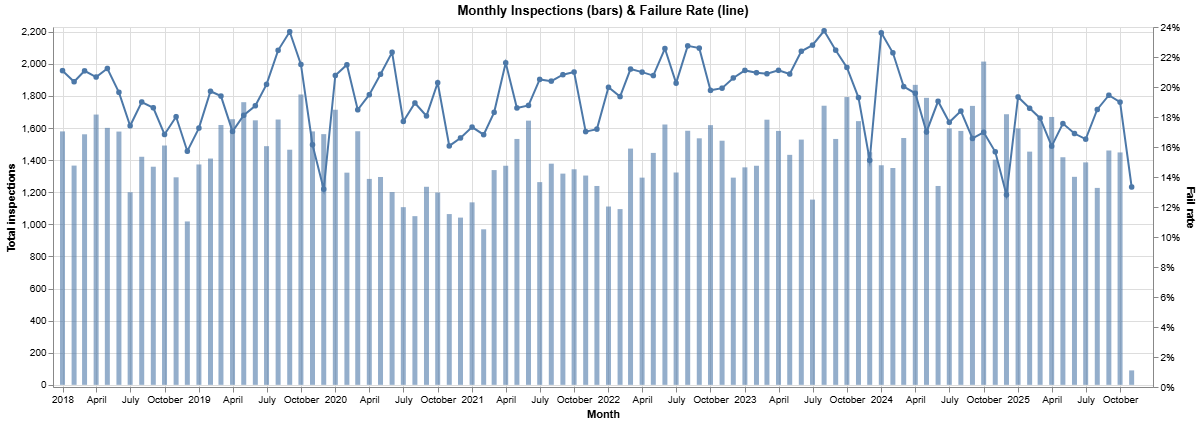

# Trend Explaination

*  From 2018→present, inspection volumes fluctuate with a noticeable dip around early mid 2020 (pandemic impact), then rebound and stabilize. This sets the temporal context for all downstream analyses.
* The failure rate consistently tends to decline toward the end of the year, as observed from 2020 through the present. A similar downward trend is evident again in November 2025.
* Volume ≠ risk. High-volume months don’t automatically have higher failure rates; the two lines move somewhat independently. This hints at selection effects (which kinds of inspections were conducted) rather than simple seasonality.
* Because rate spikes likely reflect inspection-type mix (complaints, license checks) rather than time alone, we should stratify by Inspection Type and Facility/Risk—which is exactly what our hypotheses will explore.

## EDA-2: Month × Day Heatmap Trends in Inspection Failure Rates(Gauthami Ghadiyaram)

In [ ]:
import pandas as pd
import altair as alt

alt.data_transformers.disable_max_rows()


df = df_eda.dropna(subset=['inspection_date']).copy()
df['inspection_date'] = pd.to_datetime(df['inspection_date'])


df['month'] = df['inspection_date'].dt.month
df['day']   = df['inspection_date'].dt.day


heat = (
    df.groupby(['month','day'])
      .agg(fail_rate=('is_fail','mean'))
      .reset_index()
)


chart = (
    alt.Chart(heat)
    .mark_rect()
    .encode(
        x=alt.X('day:O', title='Day of Month'),
        y=alt.Y('month:O', title='Month'),
        color=alt.Color('fail_rate:Q', title='Failure Rate',
                        scale=alt.Scale(scheme='reds')),
        tooltip=[
            alt.Tooltip('month:O', title='Month'),
            alt.Tooltip('day:O', title='Day'),
            alt.Tooltip('fail_rate:Q', title='Failure Rate', format='.1%')
        ]
    )
    .properties(
        width=800,
        height=400,
        title='Seasonality Heatmap: Inspection Failure Rate by Month and Day'
    )
)

chart

alt.Chart(...)

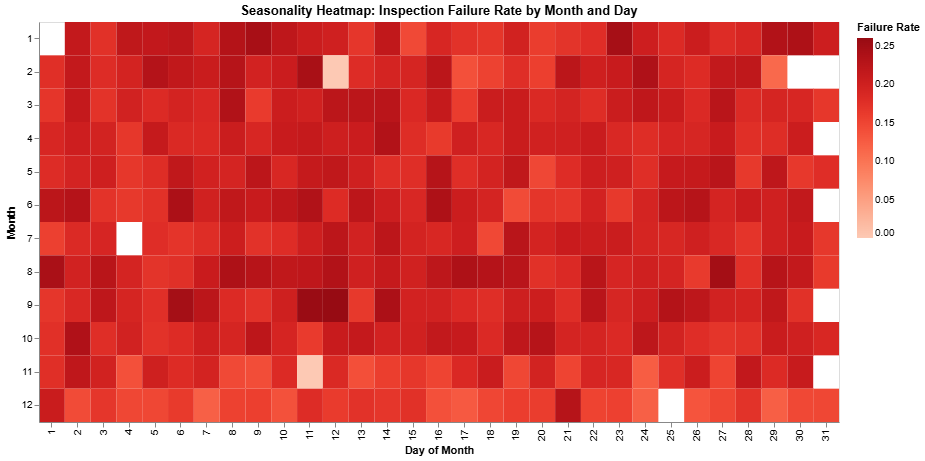

# Trend Explanation

 Month × Day Heatmap Trends in Inspection Failure Rates:

*  Mid-month peaks: Failure rates are consistently higher around days 10–20, suggesting operational cycles, staffing shifts, or inspection scheduling influence outcomes.

*  Seasonal variation: Warmer months (late spring and summer) show elevated failure rates, while colder months (November–January) have lower rates, reflecting natural fluctuations in food handling risk.

*  Short-term spikes and hotspots: Specific days within months show sharp increases in failure rates, often due to complaint-driven or follow-up inspections.

*  Heterogeneity and abrupt transitions: Daily failure rates vary widely within the same month, and month-to-month changes are abrupt, indicating that inspection type, scheduling strategies, and establishment-specific risk drive patterns more than calendar time.

## EDA-3 Chicago ZIPs: Inspections and Failure Rate Choropleth(Shaunak Khedekar)



In [ ]:
import urllib.request, pathlib
url = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/il_illinois_zip_codes_geo.min.json"
local_path = "chicago_zipcodes.geojson"
if not pathlib.Path(local_path).exists():
    urllib.request.urlretrieve(url, local_path)
print("Saved:", local_path)

Saved: chicago_zipcodes.geojson


In [ ]:
import json
import folium
from branca.colormap import linear

w = df_eda[['inspection_id','zip5','is_fail']].copy()
w['zip5'] = w['zip5'].astype(str).str.extract(r'(\d{5})', expand=False)
w = w.dropna(subset=['zip5'])
w['is_fail'] = w['is_fail'].astype('int64')

zip_stats = (
    w.groupby('zip5', as_index=False)
     .agg(total=('inspection_id','count'), fails=('is_fail','sum'))
     .assign(fail_rate=lambda d: d['fails']/d['total'])
)
min_n = 30
zip_stats['stable'] = zip_stats['total'] >= min_n

zip_path = "chicago_zipcodes.geojson"
with open(zip_path, 'r') as f:
    gj = json.load(f)

candidates = ['ZCTA5CE10','ZCTA5CE20','ZIP','zipcode','zip','ZCTA5CE']
props0 = gj['features'][0]['properties']
prop_zip_field = next((c for c in candidates if c in props0), None)
assert prop_zip_field is not None, "ZIP field not found in GeoJSON."

for feat in gj['features']:
    raw = str(feat['properties'][prop_zip_field])
    digits = ''.join(ch for ch in raw if ch.isdigit())
    feat['properties']['zip5'] = digits[:5] if len(digits) >= 5 else None

# Split Illinois vs non-Illinois by ZIP prefix 600–629
il_prefixes = tuple(str(p) for p in range(600, 630))
gj_il  = {'type':'FeatureCollection', 'features':[f for f in gj['features'] if isinstance(f['properties'].get('zip5'), str) and f['properties']['zip5'].startswith(il_prefixes)]}
gj_non = {'type':'FeatureCollection', 'features':[f for f in gj['features'] if not (isinstance(f['properties'].get('zip5'), str) and f['properties']['zip5'].startswith(il_prefixes))]}

# Join stats to IL features
stats_map = zip_stats.set_index('zip5').to_dict(orient='index')
for feat in gj_il['features']:
    z = feat['properties']['zip5']
    rec = stats_map.get(z)
    if rec:
        feat['properties'].update({
            'fail_rate': float(rec['fail_rate']),
            'total': int(rec['total']),
            'fails': int(rec['fails']),
            'stable': bool(rec['stable'])
        })
    else:
        feat['properties'].update({'fail_rate': None, 'total': 0, 'fails': 0, 'stable': False})

vals = pd.Series([f['properties'].get('fail_rate') for f in gj_il['features']]).dropna()
cmap = linear.Reds_09.scale(float(vals.min()), float(vals.max()))
cmap.caption = 'Fail rate'

m = folium.Map(location=[41.85, -87.65], zoom_start=10, tiles='cartodbpositron', control_scale=True)

folium.GeoJson(
    gj_non,
    name='Outside Illinois (grey)',
    style_function=lambda f: {
        'fillColor': '#e6e6e6',
        'color': '#ffffff',
        'weight': 0.4,
        'fillOpacity': 0.9
    },
    highlight_function=lambda f: {
        'weight': 0.4,
        'color': '#ffffff'
    }
).add_to(m)

# Illinois layer with choropleth + tooltip
def style_il(feature):
    fr = feature['properties'].get('fail_rate')
    stable = feature['properties'].get('stable')
    color = '#cccccc' if fr is None else cmap(fr)
    return {
        'fillColor': color,
        'color': '#ffffff',
        'weight': 0.6,
        'fillOpacity': 0.85 if stable else 0.35
    }

folium.GeoJson(
    gj_il,
    name='Illinois ZIP Fail Rate',
    style_function=style_il,
    highlight_function=lambda f: {'weight': 2, 'color': '#333333'},
    tooltip=folium.GeoJsonTooltip(
        fields=['zip5','fail_rate','total','fails'],
        aliases=['ZIP','Fail rate','Total','Fails'],
        localize=True,
        labels=True,
        sticky=False,
        toLocaleString=False,
        style=("background-color: white; color: #333; font-family: Arial; font-size: 12px; padding: 6px;")
    )
).add_to(m)

cmap.add_to(m)
folium.LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

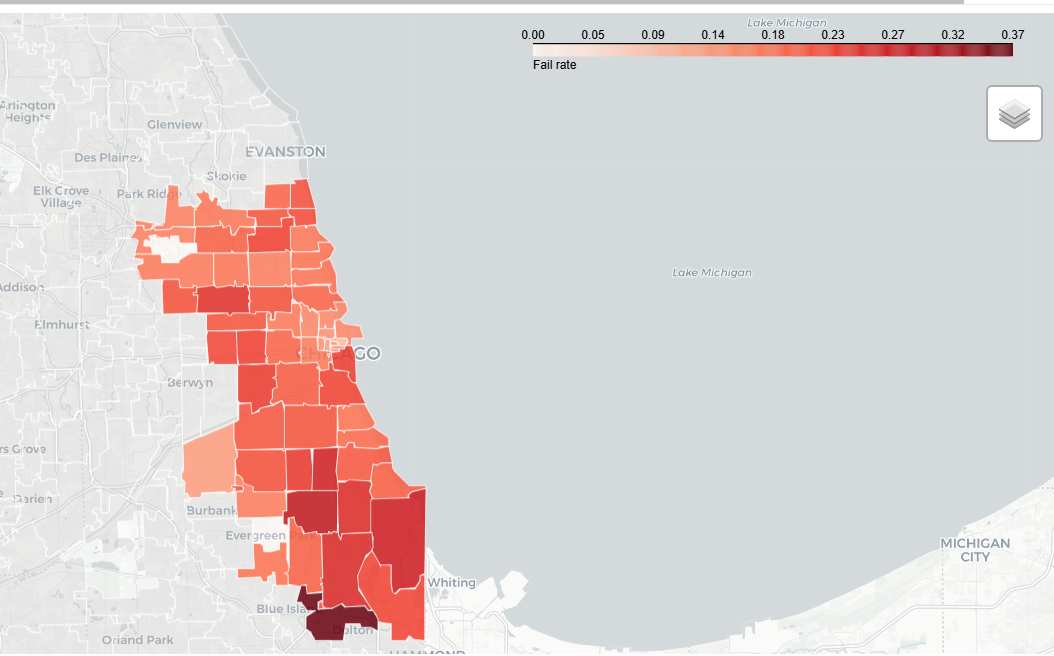

# Trend Explanation

* Higher failure rates concentrate on the South and Southwest sides, where several ZIP codes show darker red shading—indicating consistently elevated inspection failure rates compared to the citywide average.

* North and Northwest neighborhoods generally show lower failure rates, reflected by lighter shades, suggesting stronger compliance or fewer high-risk establishments in those regions.

* Central and near-west areas display mixed patterns, with some pockets of elevated risk but overall moderate fail rates—likely influenced by diverse restaurant density and mixed facility types.

* Geographic clustering is evident, implying that neighborhood-level factors—such as local enforcement patterns, establishment density, socioeconomic conditions, or historical compliance—may contribute to the spatial distribution of inspection failures.

## EDA-4: Word Cloud and Horizontal Bar Chart(Shreyas Chougule)

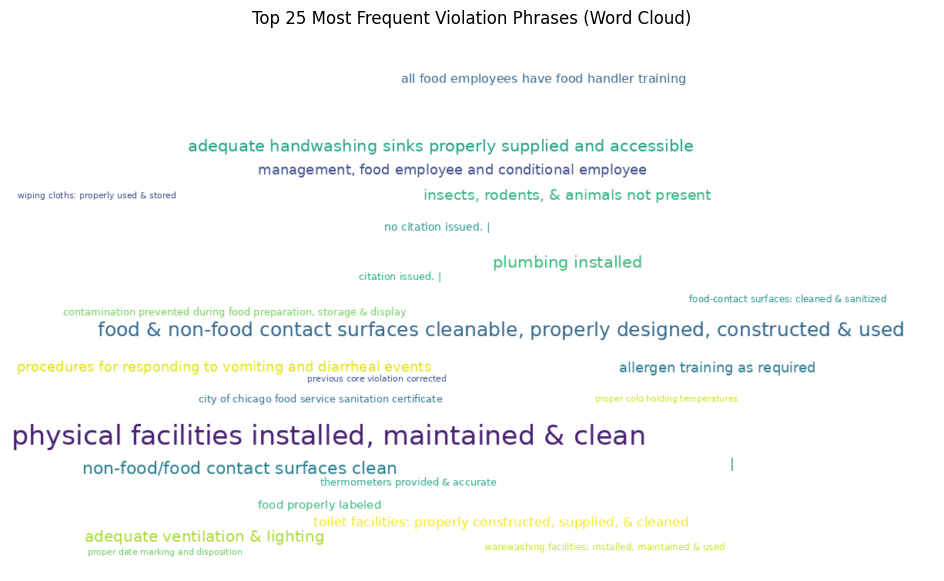

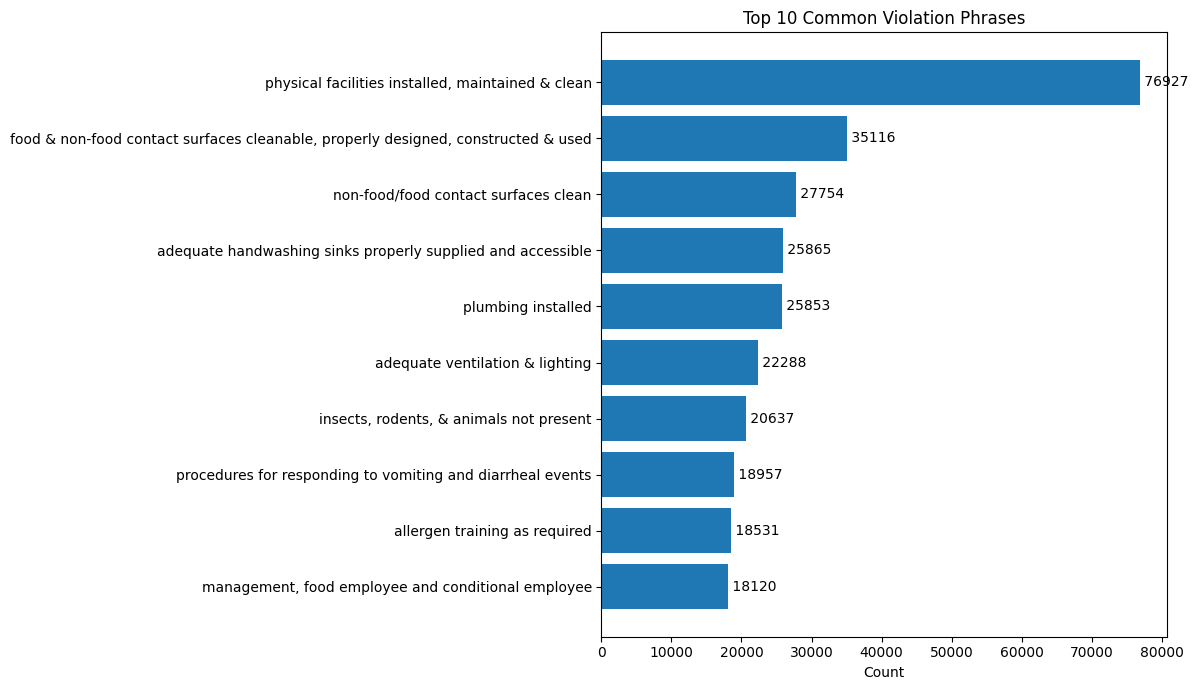

In [ ]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "/content/Food_Inspections_20251106.csv"

if "df_eda" in globals():
    source_df = df_eda.copy()
elif "df" in globals():
    source_df = df.copy()
else:
    source_df = pd.read_csv(CSV_PATH)

def extract_violation_phrases(text: str):

    if not isinstance(text, str) or not text.strip():
        return []
    parts = re.split(r"\s*\d+\.\s*", text)
    phrases = []
    for p in parts:
        p = p.strip()
        if not p:
            continue
        p = p.split(" - ")[0].strip()
        p = p.split(";")[0].strip()
        p = re.sub(r"\s+", " ", p).lower().rstrip(".,;: ")
        if p:
            phrases.append(p)
    return phrases

col = "violations_text_clean"
if col not in source_df.columns:
    raise ValueError(f"Column '{col}' not found in DataFrame. Available: {list(source_df.columns)}")

counter = Counter()
for blob in source_df[col].dropna().astype(str):
    counter.update(extract_violation_phrases(blob))

freq_df = pd.DataFrame(counter.items(), columns=["violation_phrase", "count"]).sort_values("count", ascending=False)


TOP_FOR_CLOUD = 60
TOP_FOR_BAR = 10
most_common = counter.most_common(TOP_FOR_CLOUD)
top_items = counter.most_common(TOP_FOR_BAR)

def draw_text_cloud(phrases_counts, title="Most Frequent Violation Phrases (Size ~ Frequency)"):
    """
    Fallback 'text cloud' using only matplotlib text, sizing text by frequency.
    """
    if not phrases_counts:
        print("No phrases available for text cloud.")
        return
    phrases = [p for p, _ in phrases_counts]
    counts = np.array([c for _, c in phrases_counts], dtype=float)

    cmin, cmax = counts.min(), counts.max()
    sizes = np.full_like(counts, 24.0) if cmin == cmax else 10 + (counts - cmin) * (48 - 10) / (cmax - cmin)

    n = len(phrases)
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))
    xs, ys = [], []
    rng = np.random.default_rng(42)
    for i in range(n):
        r, c = divmod(i, cols)
        xs.append(c + 0.5 + (rng.random() - 0.5) * 0.6)
        ys.append(rows - r - 0.5 + (rng.random() - 0.5) * 0.6)

    plt.figure(figsize=(14, 8))
    for x, y, s, txt in zip(xs, ys, sizes, phrases):
        plt.text(x, y, txt, fontsize=float(s), ha="center", va="center", alpha=0.9)
    plt.xlim(0, cols)
    plt.ylim(0, rows)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()


WORDS_IN_CLOUD = 25

TOP_FOR_BAR = 10
most_common = counter.most_common(WORDS_IN_CLOUD)
top_items   = counter.most_common(TOP_FOR_BAR)

used_fallback = False
try:
    from wordcloud import WordCloud
    import matplotlib as mpl, os
    font_path = os.path.join(mpl.get_data_path(), "fonts", "ttf", "DejaVuSans.ttf")

    freq_dict = dict(most_common)
    if freq_dict:
        wc = WordCloud(
            width=1200,
            height=700,
            background_color="white",
            font_path=font_path,
            max_words=WORDS_IN_CLOUD   # also enforce limit here
        ).generate_from_frequencies(freq_dict)

        plt.figure(figsize=(12, 7))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Top {WORDS_IN_CLOUD} Most Frequent Violation Phrases (Word Cloud)")
        plt.show()
    else:
        print("No phrases available for word cloud.")
except Exception:
    used_fallback = True

if used_fallback:
    draw_text_cloud(most_common, title=f"Top {WORDS_IN_CLOUD} Most Frequent Violation Phrases (Size ~ Frequency)")


if top_items:
    labels = [p for p, _ in top_items][::-1]   # reverse so largest appears at the top
    values = [c for _, c in top_items][::-1]

    plt.figure(figsize=(12, 7))
    y = np.arange(len(labels))
    plt.barh(y, values)
    plt.yticks(y, labels)
    plt.xlabel("Count")
    plt.title("Top 10 Common Violation Phrases")
    # Add value labels at bar ends
    for i, v in enumerate(values):
        plt.text(v, i, f" {v}", va="center")
    plt.tight_layout()
    plt.show()
else:
    print("No phrases available for bar chart.")


# Trend Explaination :

* From 2018 to 2025, the pattern of violations has remained largely stable, with the same recurring issues dominating each year. The most common categories such as maintaining physical facilities, ensuring cleanable food and non-food contact surfaces, and keeping hand-washing sinks properly stocked—point to ongoing maintenance and sanitation problems rather than occasional mistakes.

* The frequent appearance of these structural and cleanliness-related issues suggests they are rooted in long-term operational practices, not short-term lapses. In contrast, violations involving pest control or employee hygiene appear less common, indicating more consistent control in those areas.

* Overall, the trend shows that infrastructure upkeep covering areas like flooring, plumbing, and ventilation—continues to be the most persistent compliance challenge, while more immediate contamination or hygiene failures are relatively rare.

# EDA-5: Violation counts vs inspection outcomes(Swathi Kumar)

=== Violation count summary by inspection outcome ===


count  mean   std  min  50%   75%   90%   95%    max
outcome                                                                     
Failed inspection     26362.0  11.1  7.53  0.0  9.0  15.0  21.0  25.0  143.0
Passed / acceptable  109729.0  4.21  5.05  0.0  3.0   6.0  10.0  14.0   63.0

/tmp/ipython-input-1374640056.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


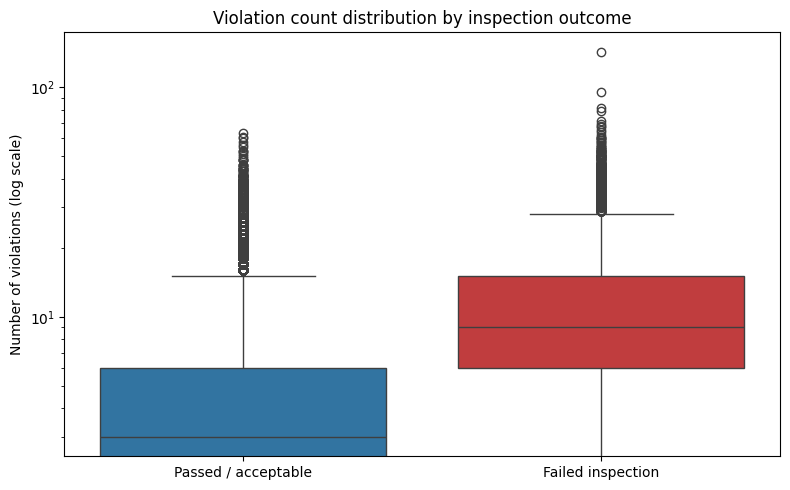

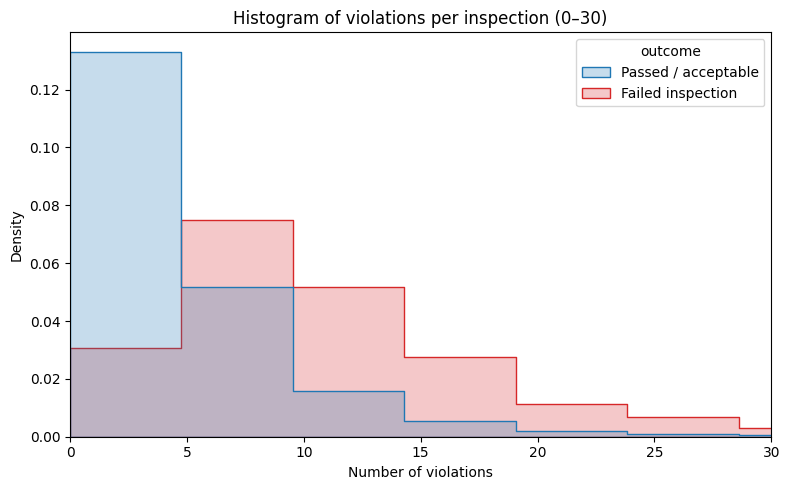

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

eda_viol = df_eda.copy()

eda_viol = eda_viol.dropna(subset=["violation_count", "is_fail"])

eda_viol["outcome"] = np.where(
    eda_viol["is_fail"] == 1,
    "Failed inspection",
    "Passed / acceptable"
)

print("=== Violation count summary by inspection outcome ===")
display(
    eda_viol.groupby("outcome")["violation_count"]
        .describe(percentiles=[0.5, 0.75, 0.9, 0.95])
        .round(2)
)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=eda_viol,
    x="outcome",
    y="violation_count",
    palette={"Failed inspection": "#D62728",
             "Passed / acceptable": "#1F77B4"}
)
plt.yscale("log")
plt.title("Violation count distribution by inspection outcome")
plt.xlabel("")
plt.ylabel("Number of violations (log scale)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(
    data=eda_viol,
    x="violation_count",
    hue="outcome",
    element="step",
    stat="density",
    common_norm=False,
    bins=30,
    palette={"Failed inspection": "#D62728",
             "Passed / acceptable": "#1F77B4"}
)
plt.xlim(0, 30)
plt.title("Histogram of violations per inspection (0–30)")
plt.xlabel("Number of violations")
plt.ylabel("Density")
plt.tight_layout()
plt.show()



# Trend Explanation:


- We summarize violation_count by outcome and visualize it with a boxplot (log scale) and an overlapping histogram.
- This helps us see whether failures are typically associated with **more recorded violations**, or whether a small number of critical violations can also trigger failure.
- These patterns also motivate using violation_count as a predictive feature in our risk model

# EDA-6: Interactive failure-rate heatmap by facility type(Shreyas Chougule)

In [ ]:

import pandas as pd
import altair as alt

eda_heat = df_eda.copy()

# Extract year and month
eda_heat["year"] = eda_heat["inspection_date"].dt.year
eda_heat["month"] = eda_heat["inspection_date"].dt.month

# Keep only rows with known outcome
eda_heat = eda_heat.dropna(subset=["is_fail", "facility_type", "year", "month"])

# Focus on the top 10 most common facility types
top_facilities = (
    eda_heat["facility_type"]
    .value_counts()
    .head(10)
    .index.tolist()
)

eda_heat = eda_heat[eda_heat["facility_type"].isin(top_facilities)]

# Aggregate to year x month x facility_type
heat_agg = (
    eda_heat
    .groupby(["facility_type", "year", "month"], as_index=False)
    .agg(
        inspections=("inspection_id", "nunique"),
        fails=("is_fail", "sum"),
    )
)

heat_agg["fail_rate"] = heat_agg["fails"] / heat_agg["inspections"]

print("=== Sample of aggregated data for heatmap ===")
display(heat_agg.head())

facility_dropdown = alt.binding_select(
    options=sorted(top_facilities),
    name="Facility type: "
)

facility_select = alt.selection_single(
    fields=["facility_type"],
    bind=facility_dropdown,
    name="FacilitySelect",
    empty="none"
)

heatmap = (
    alt.Chart(heat_agg)
    .add_params(facility_select)
    .transform_filter(facility_select)
    .mark_rect()
    .encode(
        x=alt.X(
            "month:O",
            title="Month",
            axis=alt.Axis(
                format="d",
                labelFontSize=20,
                titleFontSize=22,
            )
        ),
        y=alt.Y(
            "year:O",
            title="Year",
            axis=alt.Axis(
                format="d",
                labelFontSize=18,
                titleFontSize=20,
            )
        ),
        color=alt.Color(
            "fail_rate:Q",
            title="Failure rate",
            scale=alt.Scale(
                scheme="redyellowgreen",
                domain=[0, 1],
                reverse=True
            ),
        ),
        tooltip=[
            alt.Tooltip("facility_type:N", title="Facility type"),
            alt.Tooltip("year:O", title="Year"),
            alt.Tooltip("month:O", title="Month"),
            alt.Tooltip("inspections:Q", title="# Inspections"),
            alt.Tooltip("fails:Q", title="# Fails"),
            alt.Tooltip("fail_rate:Q", title="Failure rate", format=".2%"),
        ],
    )
    .properties(
        width=900,
        height=700,
        title="Failure rate by year and month for selected facility type",
    )
)

heatmap




=== Sample of aggregated data for heatmap ===


facility_type  year  month  inspections  fails  fail_rate
0        Bakery  2018      1            9      2   0.222222
1        Bakery  2018      2           19      5   0.263158
2        Bakery  2018      3           15      3   0.200000
3        Bakery  2018      4           19      3   0.157895
4        Bakery  2018      5           24      5   0.208333

/tmp/ipython-input-804179318.py:47: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  facility_select = alt.selection_single(


alt.Chart(...)

# Trend Explanation:


This interactive heatmap shows how **monthly failure rates** evolve over time for the top facility types:

- Each cell represents a **(year, month)** combination for the selected facility type.
- Color encodes the **inspection failure rate** for that month (red = higher failure rate, green = lower).
- A dropdown lets us switch between different facility types and compare their temporal risk patterns.

This helps us spot **seasonal patterns** or periods where certain facility types experience unusually high failure rates, which can guide targeted inspections or interventions.

# EDA-7: License-level historical risk profile(Dhru Prajapati)

In [ ]:
import altair as alt
import pandas as pd

eda_lic = df_eda.copy()

# Try to detect a license column name
license_candidates = [
    "license_id",
    "license",
    "license_number",
    "license_canonical",
    "licenseid",
]

lic_col = None
for cand in license_candidates:
    if cand in eda_lic.columns:
        lic_col = cand
        break

print("Detected license column:", lic_col)
if lic_col is None:
    print("No license-like column found. Available columns are:")
    print(eda_lic.columns.tolist())
else:
    # Keep only rows with known license and outcome
    eda_lic = eda_lic.dropna(subset=[lic_col, "is_fail"])

    # For convenience, create a standard name
    eda_lic = eda_lic.rename(columns={lic_col: "license_key"})

    # Aggregate to license level
    lic_summary = (
        eda_lic
        .groupby("license_key", as_index=False)
        .agg(
            total_inspections=("is_fail", "count"),
            fails=("is_fail", "sum"),
            facility_type_mode=(
                "facility_type",
                lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown"
            ),
        )
    )

    lic_summary["fail_rate"] = lic_summary["fails"] / lic_summary["total_inspections"]

    print("=== Sample of license-level summary ===")
    display(lic_summary.head())

    # Interactive parameter: minimum number of inspections for a license
    min_inspections_param = alt.param(
        name="MinInspections",
        value=3,
        bind=alt.binding_range(
            min=1,
            max=int(lic_summary["total_inspections"].max()),
            step=1,
            name="Min inspections per license: "
        ),
    )

    scatter = (
        alt.Chart(lic_summary)
        .add_params(min_inspections_param)
        .transform_filter("datum.total_inspections >= MinInspections")
        .mark_circle(opacity=0.7)
        .encode(
            x=alt.X(
                "total_inspections:Q",
                title="Total inspections for this license"
            ),
            y=alt.Y(
                "fail_rate:Q",
                title="Historical failure rate",
                axis=alt.Axis(format=".0%")
            ),
            color=alt.Color(
                "facility_type_mode:N",
                title="Typical facility type",
                legend=alt.Legend(columns=1)
            ),
            size=alt.Size(
                "total_inspections:Q",
                title="# Inspections (bubble size)",
                legend=None
            ),
            tooltip=[
                alt.Tooltip("license_key:N", title="License ID"),
                alt.Tooltip("facility_type_mode:N", title="Typical facility type"),
                alt.Tooltip("total_inspections:Q", title="# Inspections"),
                alt.Tooltip("fails:Q", title="# Fails"),
                alt.Tooltip("fail_rate:Q", title="Failure rate", format=".2f"),
            ],
        )
        .properties(
            width=900,
            height=900,
            title="License-level historical failure rate vs inspection volume"
        )
        .interactive()
    )

    scatter

Detected license column: license_id
=== Sample of license-level summary ===


license_key  total_inspections  fails facility_type_mode  fail_rate
0           0                302     82         Restaurant   0.271523
1        1000                  1      0             Liquor   0.000000
2     1000049                  1      0         Restaurant   0.000000
3     1000572                 20      1      Grocery Store   0.050000
4     1000612                  1      0         Restaurant   0.000000

In [ ]:
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
scatter


Output hidden; open in https://colab.research.google.com to view.

# Trend Explanation

Here we aggregate inspections **per license (establishment)** and visualize:

- **Total inspections** on the x-axis.
- **Historical failure rate** on the y-axis.
- **Color = typical facility type** for that license.
- **Bubble size** scales with the number of inspections.
- A slider filters out licenses with very few inspections.

This helps identify:
- Establishments with **consistently high failure rates** (high on the y-axis),
- High-volume licenses that are almost always compliant,
- And whether certain facility types tend to have more “chronically risky” locations.


# EDA 8: How failure rates evolve over time by risk level(Swathi Mohan Kumar)

In [ ]:
import pandas as pd
import altair as alt

eda_risk = df_eda.copy()

# Detect a risk column
risk_candidates = ["risk_level", "risk", "risk_cat", "risk_label"]
risk_col = None
for cand in risk_candidates:
    if cand in eda_risk.columns:
        risk_col = cand
        break

print("Detected risk column:", risk_col)

if risk_col is None:
    print("No risk column found. Available columns:")
    print(eda_risk.columns.tolist())
else:
    eda_risk = eda_risk.dropna(subset=[risk_col, "is_fail", "inspection_date"])

    eda_risk["month_start"] = eda_risk["inspection_date"].dt.to_period("M").dt.to_timestamp()

    # Aggregate: per month x risk level
    risk_month = (
        eda_risk
        .groupby(["month_start", risk_col], as_index=False)
        .agg(
            inspections=("inspection_id", "nunique"),
            fails=("is_fail", "sum"),
        )
    )
    risk_month["fail_rate"] = risk_month["fails"] / risk_month["inspections"]

    print("=== Sample of monthly risk-level summary ===")
    display(risk_month.head())

    # Make risk column a string for nicer labels
    risk_month["risk_str"] = risk_month[risk_col].astype(str)

    # Interactive legend highlight
    highlight = alt.selection_point(fields=["risk_str"], bind="legend", name="Risk")

    line_chart = (
        alt.Chart(risk_month)
        .add_params(highlight)
        .mark_line(point=True)
        .encode(
            x=alt.X("month_start:T", title="Inspection month"),
            y=alt.Y(
                "fail_rate:Q",
                title="Failure rate",
                axis=alt.Axis(format=".0%")
            ),
            color=alt.Color(
                "risk_str:N",
                title="Risk level"
            ),
            opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.15)),
            tooltip=[
                alt.Tooltip("month_start:T", title="Month"),
                alt.Tooltip("risk_str:N", title="Risk level"),
                alt.Tooltip("inspections:Q", title="# Inspections"),
                alt.Tooltip("fails:Q", title="# Fails"),
                alt.Tooltip("fail_rate:Q", title="Failure rate", format=".2%"),
            ],
        )
        .properties(
            width=900,
            height=900,
            title="Monthly inspection failure rate by risk level"
        )
        .interactive()
    )

    line_chart


Detected risk column: risk_level
=== Sample of monthly risk-level summary ===


month_start  risk_level  inspections  fails  fail_rate
0  2018-01-01           1         1305    255   0.195402
1  2018-01-01           2          153     35   0.228758
2  2018-01-01           3          121     43   0.355372
3  2018-02-01           1         1119    227   0.202860
4  2018-02-01           2          178     36   0.202247

In [ ]:
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
line_chart


alt.Chart(...)

# Trend Explanation

This line chart tracks how **failure rates** change over time for each **risk level**:

- The x-axis is the inspection month, the y-axis is the **failure rate**.
- Each line is a risk level (e.g., Risk 1 / 2 / 3).
- You can click entries in the legend to highlight specific risk levels.

This helps us see whether higher-risk categories are **consistently more likely to fail**, and whether certain periods show spikes for specific risk levels (useful for planning targeted inspections or seasonal campaigns).

# EDA 9: Pass vs fail composition over time(Gauthami Ghadiyaram)

In [ ]:
import pandas as pd
import altair as alt

eda_res = df_eda.copy()

eda_res = eda_res.dropna(subset=["inspection_date", "is_fail"])

# Month start for grouping
eda_res["month_start"] = eda_res["inspection_date"].dt.to_period("M").dt.to_timestamp()

# Outcome label
eda_res["outcome"] = eda_res["is_fail"].map({1: "Fail", 0: "Pass / acceptable"}).fillna("Other")

# Aggregate per month x outcome
res_month = (
    eda_res
    .groupby(["month_start", "outcome"], as_index=False)
    .agg(
        inspections=("inspection_id", "nunique")
    )
)

# Total per month
total_month = (
    res_month
    .groupby("month_start", as_index=False)["inspections"]
    .sum()
    .rename(columns={"inspections": "total_inspections"})
)

# Merge and compute share
res_month = res_month.merge(total_month, on="month_start", how="left")
res_month["share"] = res_month["inspections"] / res_month["total_inspections"]

print("=== Sample of monthly pass/fail composition ===")
display(res_month.head())

# Toggle: show counts vs share using a radio button
mode_param = alt.param(
    name="Mode",
    value="share",
    bind=alt.binding_radio(
        options=["share", "count"],
        labels=["Show % share", "Show raw counts"],
        name="Y-axis: "
    ),
)

area_chart = (
    alt.Chart(res_month)
    .add_params(mode_param)
    .transform_calculate(
        y_value="datum.share",
        y_label="'Failure / pass share'",
    )
    .transform_calculate(
        y_value_count="datum.inspections",
        y_label_count="'# Inspections'",
    )
    .transform_calculate(
        y_final="Mode === 'share' ? datum.share : datum.inspections"
    )
    .mark_area()
    .encode(
        x=alt.X("month_start:T", title="Inspection month"),
        y=alt.Y(
            "y_final:Q",
            title="Share of inspections"
        ),
        color=alt.Color(
            "outcome:N",
            title="Outcome",
            sort=["Fail", "Pass / acceptable", "Other"]
        ),
        tooltip=[
            alt.Tooltip("month_start:T", title="Month"),
            alt.Tooltip("outcome:N", title="Outcome"),
            alt.Tooltip("inspections:Q", title="# Inspections"),
            alt.Tooltip("share:Q", title="Share", format=".2%"),
        ],
    )
    .properties(
        width=900,
        height=800,
        title="Pass vs fail composition over time"
    )
    .interactive()
)

area_chart


=== Sample of monthly pass/fail composition ===


month_start            outcome  inspections  total_inspections     share
0  2018-01-01               Fail          333               1579  0.210893
1  2018-01-01  Pass / acceptable         1246               1579  0.789107
2  2018-02-01               Fail          278               1366  0.203514
3  2018-02-01  Pass / acceptable         1088               1366  0.796486
4  2018-03-01               Fail          329               1561  0.210762

alt.Chart(...)

# Trend Explanation


- The x-axis is the inspection month.
- The colored bands represent **Fail**, **Pass/acceptable**, and other outcomes.
- A toggle lets us switch between **percentage share** and **raw counts**.

This helps us see whether failures are becoming more or less common over time relative to total inspections, not just in absolute numbers.

# EDA 10: Heatmap of license vs zip prior failure rates(Shaunak Khedkar)

In [ ]:
import pandas as pd
import altair as alt
import numpy as np

eda_hist = df_eda.copy()

# Detect license column
license_candidates = ["license_id", "license", "license_number", "license_canonical", "licenseid"]
lic_col = None
for cand in license_candidates:
    if cand in eda_hist.columns:
        lic_col = cand
        break

# Detect zip column
zip_candidates = ["zip5", "zip_code", "zip", "ZIP"]
zip_col = None
for cand in zip_candidates:
    if cand in eda_hist.columns:
        zip_col = cand
        break

print("Detected license column:", lic_col)
print("Detected zip column:", zip_col)

if lic_col is None or zip_col is None:
    print("Missing required columns; available columns are:")
    print(eda_hist.columns.tolist())
else:
    # Keep only what we need
    eda_hist = eda_hist[[lic_col, zip_col, "inspection_date", "is_fail"]].dropna(subset=[lic_col, zip_col, "inspection_date", "is_fail"])
    eda_hist = eda_hist.rename(columns={lic_col: "license_key", zip_col: "zip_key"})

    # Sort by date so "prior" is well-defined
    eda_hist = eda_hist.sort_values(["license_key", "inspection_date"])

    eda_hist["lic_prior_inspections"] = eda_hist.groupby("license_key").cumcount()
    lic_cum_fails = eda_hist.groupby("license_key")["is_fail"].cumsum()
    # prior fails = cumulative fails *before* current inspection
    eda_hist["lic_cum_fails"] = lic_cum_fails - eda_hist["is_fail"]
    eda_hist["lic_prior_fail_rate"] = np.where(
        eda_hist["lic_prior_inspections"] > 0,
        eda_hist["lic_cum_fails"] / eda_hist["lic_prior_inspections"],
        np.nan
    )

    eda_hist = eda_hist.sort_values(["zip_key", "inspection_date"])
    eda_hist["zip_prior_inspections"] = eda_hist.groupby("zip_key").cumcount()
    zip_cum_fails = eda_hist.groupby("zip_key")["is_fail"].cumsum()
    eda_hist["zip_cum_fails"] = zip_cum_fails - eda_hist["is_fail"]
    eda_hist["zip_prior_fail_rate"] = np.where(
        eda_hist["zip_prior_inspections"] > 0,
        eda_hist["zip_cum_fails"] / eda_hist["zip_prior_inspections"],
        np.nan
    )

    # Drop rows that have no history for both license and zip
    eda_hist = eda_hist.dropna(subset=["lic_prior_fail_rate", "zip_prior_fail_rate"], how="any")

    print("=== Sample of history-based data ===")
    display(eda_hist[["lic_prior_fail_rate", "zip_prior_fail_rate", "is_fail"]].head())

    alt.data_transformers.disable_max_rows()

    heat_2d = (
        alt.Chart(eda_hist)
        .mark_rect()
        .encode(
            x=alt.X(
                "lic_prior_fail_rate:Q",
                bin=alt.Bin(maxbins=10),
                title="License prior failure rate"
            ),
            y=alt.Y(
                "zip_prior_fail_rate:Q",
                bin=alt.Bin(maxbins=10),
                title="Zip prior failure rate"
            ),
            color=alt.Color(
                "mean(is_fail):Q",
                title="Current failure rate in bin",
                scale=alt.Scale(
                    scheme="redyellowgreen",
                    domain=[0, 1],
                    reverse=True
                )
            ),
            tooltip=[
                alt.Tooltip("count():Q", title="# Inspections in bin"),
                alt.Tooltip("mean(is_fail):Q", title="Failure rate in bin", format=".2%"),
                alt.Tooltip("bin(lic_prior_fail_rate):Q", title="License prior fail range"),
                alt.Tooltip("bin(zip_prior_fail_rate):Q", title="Zip prior fail range"),
            ],
        )
        .properties(
            width=900,
            height=600,
            title="Interaction of license vs zip historical failure rates"
        )
    )

    heat_2d


Detected license column: license_id
Detected zip column: zip5
=== Sample of history-based data ===


lic_prior_fail_rate  zip_prior_fail_rate  is_fail
135978                  0.0                  0.0        0
135175                  0.0                  0.0        0
135033                  0.0                  0.0        0
134597                  0.0                  0.0        0
134164                  0.0                  0.0        0

In [ ]:
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
heat_2d


Output hidden; open in https://colab.research.google.com to view.

# Trend Explanation:

Here we examine how **establishment-level history** lic_prior_fail_rate and **neighborhood-level history** zip_prior_fail_rate jointly relate to the current inspection outcome:

- Each cell is a bin over (license prior fail rate, zip prior fail rate).
- Color encodes the **current failure rate** (`mean(is_fail)`) for inspections in that bin.
- This reveals whether inspections are most likely to fail when **both** the establishment and its surrounding area have poor histories, and whether one factor dominates the other.

It directly validates the inclusion of both history features in our predictive models.


# Hypothesis 1(Dhru Prajapati)

**Complaint-driven inspections (and re-inspections) have a higher failure rate than routine Canvass or License inspections.**

**Why this is interesting:**

*   High triage value: If true, routing inspectors to complaints/re-inspects yields more impactful findings per visit.
*   Re-inspection ambiguity: Could improve (fixes made) or still fail (systemic issues), worth testing.
*   Equity lens: Complaint frequency varies by neighborhood, results can reveal/reporting bias.
*   Actionable next steps: If confirmed, also probe which violation types spike to guide what inspectors should look for.

In [ ]:
# H1: Failure rate by Inspection Type - interactive with hover + slider

import pandas as pd
try:
    import altair as alt
except ModuleNotFoundError:
    !pip -q install altair vl-convert-python
    import altair as alt

assert 'df_eda' in globals(), "df_eda not found. Run the 2018+ filter cell first."

alt.data_transformers.disable_max_rows()
alt.renderers.enable("default")

# Aggregate by inspection_type
agg = (
    df_eda[['inspection_id','inspection_type','is_fail']]
      .dropna(subset=['inspection_type'])
      .groupby('inspection_type', as_index=False)
      .agg(total=('inspection_id','count'),
           fails=('is_fail','sum'))
      .assign(fail_rate=lambda d: d['fails'] / d['total'])
)

slider = alt.binding_range(name='Min inspections', min=50, max=int(agg['total'].max()), step=50)
minN = alt.param(name='minN', value=300, bind=slider)

base = alt.Chart(agg).add_params(minN).transform_filter('datum.total >= minN')

CHART_WIDTH = 1100
CHART_HEIGHT = 420

bars = base.mark_bar().encode(
    y=alt.Y('inspection_type:N', sort='-x', title='Inspection Type'),
    x=alt.X('fail_rate:Q', title='Failure rate', axis=alt.Axis(format='%')),
    tooltip=[
        alt.Tooltip('inspection_type:N', title='Type'),
        alt.Tooltip('total:Q', title='Total inspections'),
        alt.Tooltip('fails:Q', title='Fails'),
        alt.Tooltip('fail_rate:Q', title='Fail rate', format='.1%')
    ]
).properties(width=CHART_WIDTH, height=CHART_HEIGHT,
             title='Failure Rate by Inspection Type (2018–present)')

pts = base.mark_point(filled=True).encode(
    y='inspection_type:N',
    x='fail_rate:Q',
    size=alt.Size('total:Q', title='Total inspections', scale=alt.Scale(range=[30, 600])),
    tooltip=[
        alt.Tooltip('inspection_type:N', title='Type'),
        alt.Tooltip('total:Q', title='Total inspections'),
        alt.Tooltip('fails:Q', title='Fails'),
        alt.Tooltip('fail_rate:Q', title='Fail rate', format='.1%')
    ]
)

(bars + pts).interactive()

alt.LayerChart(...)

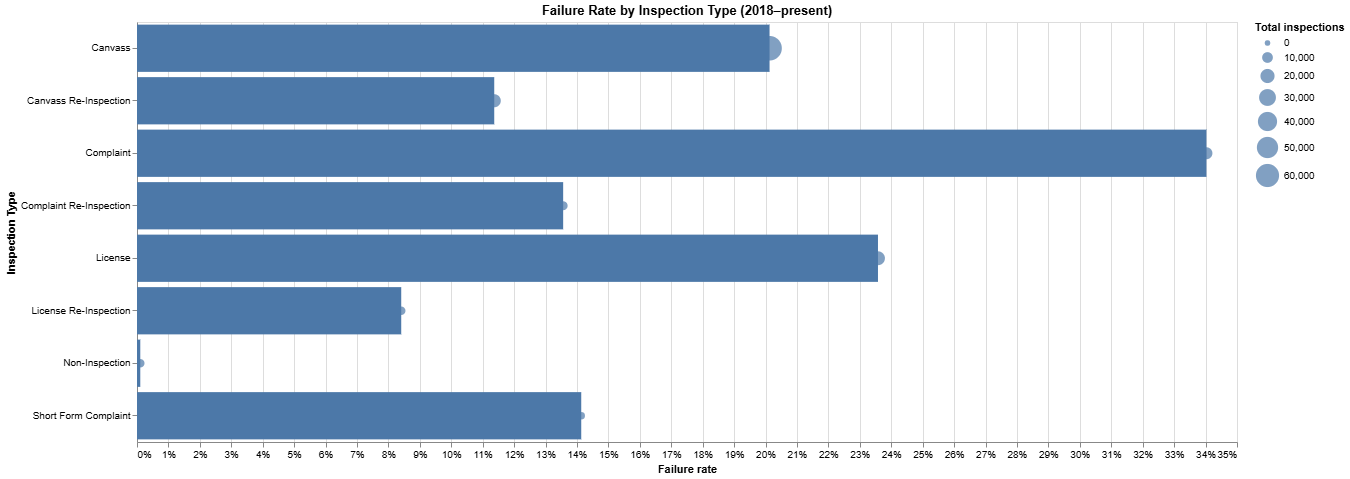

# Interpretation:



* Targeted programs (Complaint / Suspected Food Poisoning) show materially higher failure rates than routine canvass.
* Operational insight: If resources are tight, complaint intake seems to be an efficient triage channel—high hit rate.
* Remediation works: Lower rates on re-inspections suggest issues are often fixed by the next check.
* Policy note on License: Elevated failure on License visits may indicate barriers to compliance for new/renewing establishments—worth a deeper dive (common violations, training gaps).

# Hypothesis 2(Gauthami Ghadiyaram)

**Inspection failures are more frequent during the hotter months (June–September), suggesting a seasonal influence on food safety outcomes.**  

**Why this is interesting:**

*  Temperature sensitivity: If failure rates truly rise in hotter months, it highlights how environmental factors directly influence food safety outcomes.

*  Operational optimization: Knowing the seasonal spike enables data-driven scheduling, routing more inspectors during summer for higher impact.

*  Preventive leverage: Insights can drive seasonal awareness campaigns or pre-summer training for establishments to mitigate predictable risks.

*  Equity & environment: Some neighborhoods may experience more heat-related failures due to infrastructure gaps (e.g., older cooling systems), revealing uneven risk exposure.

In [ ]:
# H2: Seasonality — Monthly Failure Rate (Interactive Line Plot)

import pandas as pd
try:
    import altair as alt
except ModuleNotFoundError:
    !pip -q install altair vl-convert-python
    import altair as alt

# Prepare Data
df_season = df_eda.copy()

# Convert date
df_season["month"] = pd.to_datetime(df_season["inspection_date"], errors="coerce").dt.month

# Aggregate failures per month
monthly = (
    df_season[["inspection_id", "month", "is_fail"]]
        .dropna(subset=["month"])
        .groupby("month", as_index=False)
        .agg(total=("inspection_id", "count"),
             fails=("is_fail", "sum"))
        .assign(fail_rate=lambda d: d["fails"] / d["total"])
)

# Altair Setup
alt.data_transformers.disable_max_rows()
alt.renderers.enable("default")

# Slider to filter months with minimum inspection count
slider = alt.binding_range(
    name='Min inspections/month',
    min=50,
    max=int(monthly['total'].max()),
    step=50
)
minN = alt.param(name='minN', value=300, bind=slider)

base = (
    alt.Chart(monthly)
       .add_params(minN)
       .transform_filter("datum.total >= minN")
)

CHART_WIDTH = 900
CHART_HEIGHT = 450

# Line plot
line = base.mark_line(point=True).encode(
    x=alt.X("month:O", title="Month (1–12)"),
    y=alt.Y("fail_rate:Q", title="Failure Rate", axis=alt.Axis(format="%")),
    tooltip=[
        alt.Tooltip("month:O", title="Month"),
        alt.Tooltip("total:Q", title="Total inspections"),
        alt.Tooltip("fails:Q", title="Failures"),
        alt.Tooltip("fail_rate:Q", title="Failure Rate", format=".1%")
    ]
).properties(
    width=CHART_WIDTH,
    height=CHART_HEIGHT,
    title="Food Inspection Failure Rate by Month (Seasonality — Interactive)"
)

line.interactive()

alt.Chart(...)

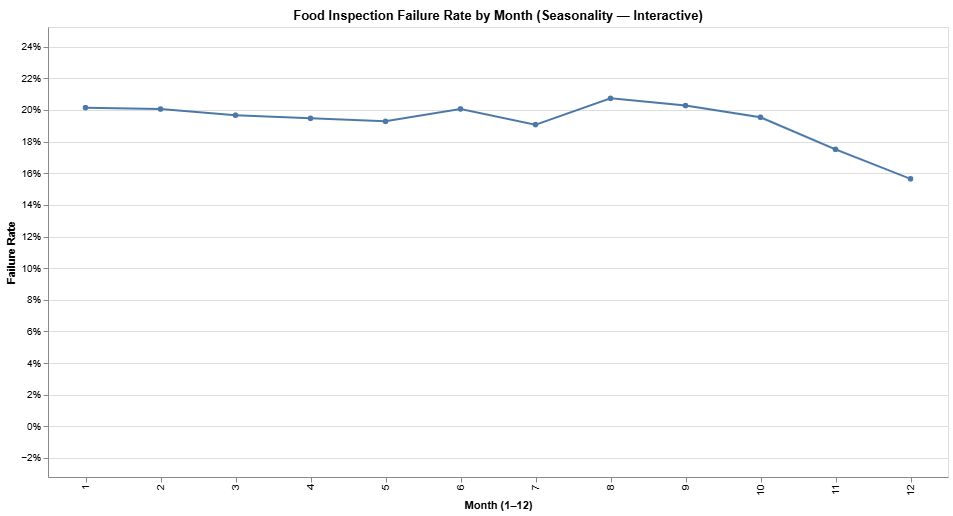

# Interpretation





* Seasonal trend: Failure rates peak during the hotter months (June–September), indicating a seasonal influence on food safety outcomes.

* Operational insight: Elevated temperatures may increase microbial growth and strain refrigeration systems, leading to higher violation rates.

* Policy implication: Scheduling more frequent or targeted inspections during summer could mitigate seasonal risks.


# Hypothesis 3(Shreyas Chougule)

**Within each facility type, the failure rate for Risk 1 (High) is greater than the failure rate for Risk 3 (Low). Formally: Δ = FailRate(High) − FailRate(Low) > 0 for most facility types.**  

**Why this is interesting:**



*   Risk-model validation: Confirms whether the assigned risk tiers actually predict outcomes after holding facility type constant.

*   Fair comparisons: Controls for facility-type mix so we don’t blame a category just because it hosts more high-risk venues.

*   Exception hunting: Highlights where Δ ≤ 0 (Low ≥ High), suggesting mislabeling, atypical operations, or targeted training needs.

*   Actionable next steps: If Δ is broadly > 0, keep prioritizing Risk-1 inspections; for categories with small/negative Δ, audit risk assignments, review violation patterns, and adjust guidance.

In [ ]:
# H3: Heatmap of failure rate by Facility Type × Risk Level (interactive)

import pandas as pd
try:
    import altair as alt
except ModuleNotFoundError:
    !pip -q install altair vl-convert-python
    import altair as alt

assert 'df_eda' in globals(), "df_eda not found. Run the 2018+ filter cell first."

alt.data_transformers.disable_max_rows()
alt.renderers.enable("default")

# Aggregate: facility_type × risk_label
agg = (
    df_eda[['inspection_id','facility_type','risk_level','is_fail']]
      .dropna(subset=['facility_type'])
      .assign(
          risk_label=lambda d: d['risk_level']
              .map({1:'Risk 1 (High)', 2:'Risk 2 (Medium)', 3:'Risk 3 (Low)'}).fillna('Unknown')
      )
      .groupby(['facility_type','risk_label'], as_index=False)
      .agg(total=('inspection_id','count'),
           fails=('is_fail','sum'))
      .assign(fail_rate=lambda d: d['fails'] / d['total'])
)

# Facility totals (to allow filtering by overall volume)
fac_tot = agg.groupby('facility_type', as_index=False)['total'].sum().rename(columns={'total':'facility_total'})
agg = agg.merge(fac_tot, on='facility_type', how='left')

# Controls: slider for minimum facility volume
slider = alt.binding_range(name='Min facility total: ', min=50, max=int(agg['facility_total'].max()), step=50)
minN = alt.param(name='minN', value=300, bind=slider)

# Order risk columns left→right
risk_order = ['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)','Unknown']

# Chart size
n_fac = agg['facility_type'].nunique()
CHART_WIDTH  = 1100
CHART_HEIGHT = min(650, 26 * n_fac + 40)

# Stacked bar showing actual pass/fail counts
agg_stacked = agg.assign(passes=lambda d: d['total'] - d['fails'])

stacked_data = pd.melt(
    agg_stacked,
    id_vars=['facility_type', 'risk_label', 'facility_total'],
    value_vars=['fails', 'passes'],
    var_name='outcome',
    value_name='count'
)

# Butterfly chart - compare High Risk vs Low Risk
butterfly_data = agg[agg['risk_label'].isin(['Risk 1 (High)', 'Risk 3 (Low)'])].copy()
butterfly_data['value'] = butterfly_data.apply(
    lambda x: -x['fail_rate'] if x['risk_label'] == 'Risk 1 (High)' else x['fail_rate'],
    axis=1
)

base = (alt.Chart(butterfly_data)
          .add_params(minN)
          .transform_filter('datum.facility_total >= minN'))

butterfly = base.mark_bar().encode(
    x=alt.X('value:Q', title='← High Risk Fail Rate | Low Risk Fail Rate →',
            axis=alt.Axis(format='%', labelExpr='abs(datum.value)')),
    y=alt.Y('facility_type:N', title=None,
            sort=alt.SortField('facility_total', order='descending'),
            axis=alt.Axis(labelLimit=200)),
    color=alt.Color('risk_label:N',
                    scale=alt.Scale(domain=['Risk 1 (High)', 'Risk 3 (Low)'],
                                   range=['#e74c3c', '#3498db']),
                    legend=alt.Legend(title='Risk Level', orient='top')),
    tooltip=[
        alt.Tooltip('facility_type:N', title='Facility'),
        alt.Tooltip('risk_label:N', title='Risk'),
        alt.Tooltip('fail_rate:Q', title='Fail Rate', format='.1%'),
        alt.Tooltip('total:Q', title='Inspections')
    ]
).properties(
    width=900,
    height=600,
    title={
        "text": "High Risk vs Low Risk Failure Rates",
        "fontSize": 18,
        "font": "Arial",
        "anchor": "middle"
    }
)

rule = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(color='gray', strokeDash=[3,3]).encode(x='x:Q')

(butterfly + rule).configure_view(strokeWidth=0).configure_axis(
    gridOpacity=0.3
).interactive()

alt.LayerChart(...)

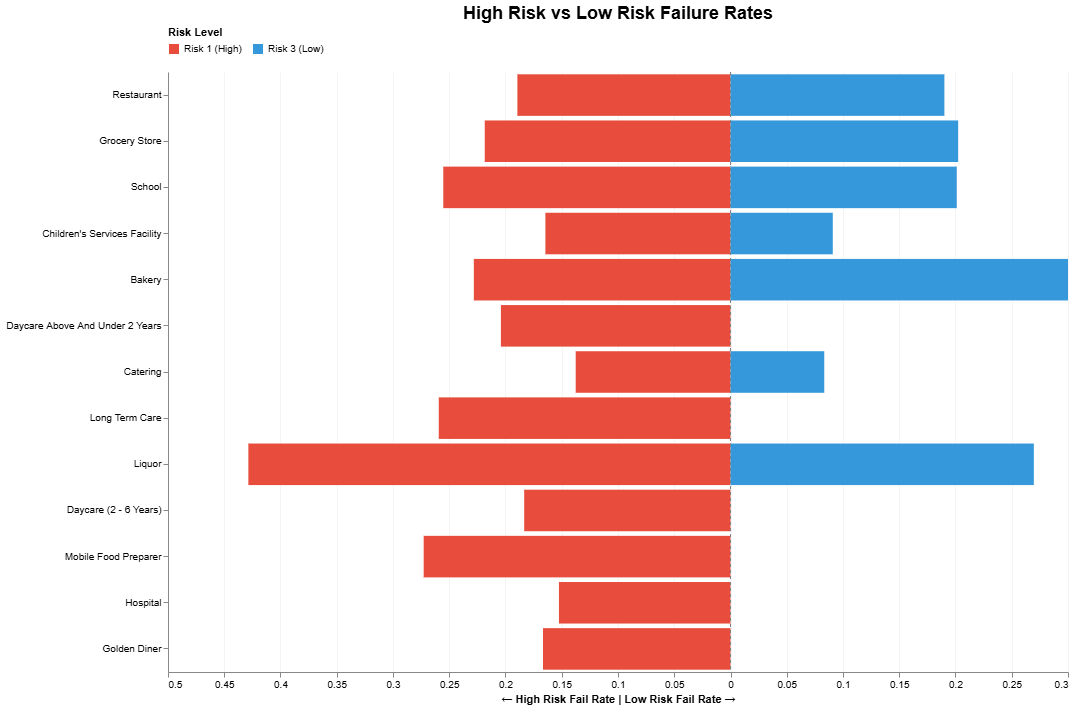

# Interpretation
*   Reading the plot: Red bars (left of zero) are Risk 1 fail rates; blue bars (right of zero) are Risk 3 fail rates. Longer bars = higher fail rate; the vertical dashed line is 0 (the comparison pivot).
*   Overall signal: If, for most facility rows, the red bar extends farther than the blue, the hypothesis is supported (Δ > 0 for those facility types).
*   Exceptions to flag: Any row where the blue bar ≈ or > red is an outlier; check sample size (use the Min facility total slider), inspection-type mix (e.g., complaints vs canvass), seasonality, or potential risk misclassification.
*   Prioritization lens: Focus on facility types showing both a large Δ and large total N (hover tooltips) — these yield the biggest compliance impact for Risk-1 targeting and tailored training.

# Hypothesis 4(Swathi Mohan Kumar)

**Multi-unit brands (Chains ≥5 inspections) have lower failure rates than independent restaurants due to standardized procedures and centralized quality control.**  

**Why this is interesting:**


*   Chains follow uniform SOPs and corporate training, which may reduce safety violations.
*   Chains often have more resources (QA teams, audits, equipment maintenance) than independents.
*   If independents fail more, it highlights a public-health and equity gap, especially for small or immigrant-owned businesses.
*   Understanding the difference helps optimize inspection prioritization and targeted support programs.

In [ ]:
# H4: Chain vs Independent failure rate using df_eda (robust + interactive Altair version)

import pandas as pd
import numpy as np
import altair as alt

assert 'df_eda' in globals(), "df_eda not found. Run your preprocessing cell first."

df = df_eda.copy()

possible_fail_cols = [c for c in df.columns if 'fail' in c.lower() or 'result' in c.lower()]
print("Detected possible failure columns:", possible_fail_cols)

fail_col = None
for c in possible_fail_cols:
    if df[c].notna().any():
        fail_col = c
        break

if fail_col is None:
    raise ValueError("No column indicating inspection failure found. Please check your dataset.")

if df[fail_col].dtype == bool:
    df['is_fail'] = df[fail_col].astype(int)
elif np.issubdtype(df[fail_col].dtype, np.number):
    df['is_fail'] = (df[fail_col] > 0).astype(int)
else:
    df['is_fail'] = df[fail_col].astype(str).str.lower().map(
        lambda x: 1 if 'fail' in x else 0
    )

name_col = 'dba_name' if 'dba_name' in df.columns else df.columns[0]

df['facility_name'] = (
    df[name_col]
      .fillna('Unknown')
      .astype(str)
      .str.strip()
)

# Count inspections per facility name to classify as chain/independent
name_counts = df['facility_name'].value_counts(dropna=False)
df['name_count'] = df['facility_name'].map(name_counts)

CHAIN_MIN_VISITS = 5
df['restaurant_type'] = np.where(df['name_count'] >= CHAIN_MIN_VISITS, 'Chain', 'Independent')

failure_rate = (
    df.groupby('restaurant_type', as_index=False)
      .agg(Failure_Rate=('is_fail','mean'),
           Total_Inspections=('facility_name','count'))
)

if failure_rate.empty:
    raise ValueError("No data found after grouping. Check your column names or filter thresholds.")

slider = alt.binding_range(min=0, max=int(failure_rate['Total_Inspections'].max()), step=1, name='Min # Inspections:')
min_inspections = alt.param(bind=slider, value=0)

base = alt.Chart(failure_rate).add_params(min_inspections).transform_filter(
    alt.datum.Total_Inspections >= min_inspections
)

fail_chart = (
    base.mark_bar(size=60, cornerRadiusTopLeft=8, cornerRadiusTopRight=8)
    .encode(
        x=alt.X('restaurant_type:N', title='Restaurant Type', sort=['Independent', 'Chain']),
        y=alt.Y('Failure_Rate:Q', title='Failure Rate', scale=alt.Scale(domain=[0,1])),
        color=alt.Color('restaurant_type:N',
                        scale=alt.Scale(domain=['Independent','Chain'],
                                        range=['#FF7F0E', '#1F77B4']),
                        title='Restaurant Type'),
        tooltip=[
            alt.Tooltip('restaurant_type:N', title='Type'),
            alt.Tooltip('Failure_Rate:Q', title='Failure Rate', format='.1%'),
            alt.Tooltip('Total_Inspections:Q', title='Total Inspections')
        ]
    )
    .properties(
        title=f'Failure Rate: Chain vs Independent (Chain ≥ {CHAIN_MIN_VISITS} inspections)',
        width=400,
        height=300
    )
)

total_chart = (
    base.mark_bar(size=60, cornerRadiusTopLeft=8, cornerRadiusTopRight=8)
    .encode(
        x=alt.X('restaurant_type:N', title='Restaurant Type', sort=['Independent', 'Chain']),
        y=alt.Y('Total_Inspections:Q', title='Total Inspections'),
        color=alt.Color('restaurant_type:N',
                        scale=alt.Scale(domain=['Independent','Chain'],
                                        range=['#FF7F0E', '#1F77B4']),
                        title='Restaurant Type'),
        tooltip=[
            alt.Tooltip('restaurant_type:N', title='Type'),
            alt.Tooltip('Total_Inspections:Q', title='Total Inspections'),
            alt.Tooltip('Failure_Rate:Q', title='Failure Rate', format='.1%')
        ]
    )
    .properties(
        title='Total Number of Inspections: Chain vs Independent',
        width=400,
        height=300
    )
)

# --- Combine both charts side by side ---
combined = alt.hconcat(fail_chart, total_chart).resolve_scale(color='shared')

combined.configure_view(strokeWidth=0).configure_axis(
    gridOpacity=0.3
)

Detected possible failure columns: ['result_norm', 'is_fail']


alt.HConcatChart(...)

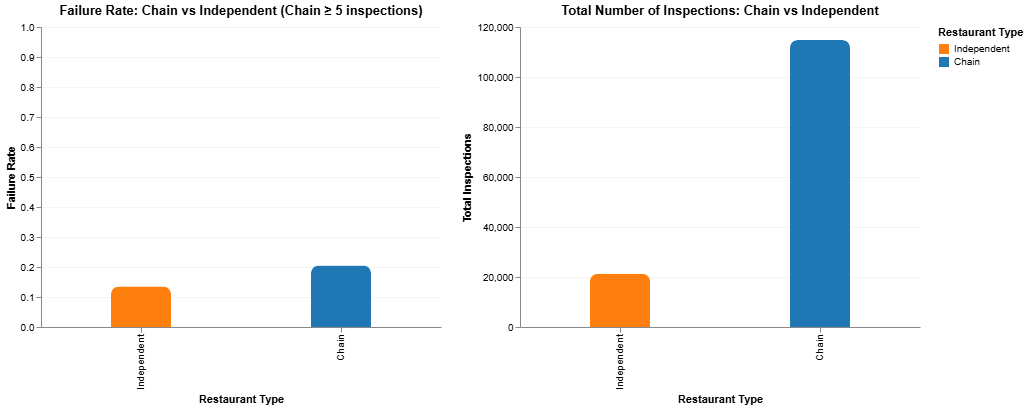

# Interpretation

*   Chains have lower failure rates than independent restaurants.
*   Standardized procedures, corporate training, and centralized quality control likely explain chains’ better performance.
*   Independents show higher and more variable failure rates, possibly due to fewer resources and less formal safety processes.
*   Both groups have enough inspections to make the comparison reliable.
*   This suggests restaurant structure (chain vs independent) meaningfully affects food-safety outcomes.


# Hypothesis 5(Shaunak Khedekar)

**Longer gaps since the previous inspection are associated with higher failure rates, even after accounting for facility risk level and facility type.**  

**Why this is interesting:**

* Scheduling signal: If failure rates rise with elapsed time, prioritizing long-overdue licenses can increase findings per inspection and improve public health impact.​

* Preventive leverage: Shortening cycles for high‑risk segments may reduce severe violations before they accumulate.​

* Resource optimization: Helps allocate limited inspector hours using a quantifiable risk cue rather than fixed calendars.​

* Equity check: Reveals if certain areas or facility types systematically experience longer gaps, suggesting access or staffing disparities.

In [ ]:
import altair as alt
alt.data_transformers.disable_max_rows()

assert 'df_eda' in globals(), "df_eda not found."

df = df_eda.copy()
df['date'] = pd.to_datetime(df['inspection_date'], errors='coerce')
df = df.dropna(subset=['date','license_id','is_fail'])
df['is_fail'] = pd.to_numeric(df['is_fail'], errors='coerce').fillna(0).astype(int)

df = df.sort_values(['license_id','date'])
df['prev_date'] = df.groupby('license_id')['date'].shift(1)
df['tsli_days'] = (df['date'] - df['prev_date']).dt.days.clip(lower=0).fillna(0)

# Bins and order
bins = [0, 90, 180, 365, 730, np.inf]
labels = ['<=90d','91–180d','181–365d','366–730d','>730d']
df['tsli_bin'] = pd.cut(df['tsli_days'], bins=bins, labels=labels, include_lowest=True)

reg = df.dropna(subset=['tsli_bin']).copy()

eff = (reg.groupby('tsli_bin', observed=True, as_index=False)
          .agg(n=('inspection_id','count'),
               fails=('is_fail','sum')))
eff['fail_rate'] = eff['fails'] / eff['n']

order = labels
df_plot = eff.copy()
df_plot['tsli_bin'] = pd.Categorical(df_plot['tsli_bin'], categories=order, ordered=True)
df_plot = df_plot.sort_values('tsli_bin')

x_max = float(df_plot['fail_rate'].max() * 1.1)
overall = float((df_plot['fail_rate']*df_plot['n']).sum() / df_plot['n'].sum())

hover = alt.selection_point(fields=['tsli_bin'], on='mouseover', nearest=True, empty=False)

base = alt.Chart(df_plot).encode(
    y=alt.Y('tsli_bin:N', title=None, sort=order, axis=alt.Axis(labelPadding=8)),
    x=alt.X('fail_rate:Q',
            title='Failure rate',
            scale=alt.Scale(domain=[0, x_max]),
            axis=alt.Axis(format='%', tickCount=6, grid=True))
).properties(width='container', height=300)

bars = base.mark_bar(height=36).encode(
    color=alt.condition(hover, alt.value('#cb181d'), alt.value('#fb6a4a')),
    opacity=alt.condition(hover, alt.value(1.0), alt.value(0.9)),
    tooltip=[
        alt.Tooltip('tsli_bin:N', title='Interval'),
        alt.Tooltip('n:Q', title='Inspections', format=',d'),
        alt.Tooltip('fails:Q', title='Fails', format=',d'),
        alt.Tooltip('fail_rate:Q', title='Failure rate', format='.1%')
    ]
).add_params(hover)

labels_txt = base.mark_text(
    align='left', dx=8, fontSize=14, fontWeight='bold', color='#1f2a44'
).encode(
    text=alt.Text('fail_rate:Q', format='.1%'),
    opacity=alt.condition(hover, alt.value(1.0), alt.value(0.9))
)

mean_rule = alt.Chart(pd.DataFrame({'x':[overall]})).mark_rule(color='#9e9e9e', strokeDash=[4,3]).encode(x='x:Q')

title_text = 'Failure rate by Time Since Last Inspection (interactive)'

chart = (bars + labels_txt + mean_rule).properties(
    title=alt.TitleParams(text=title_text, anchor='middle')
).configure_view(stroke=None).configure_axis(
    labelFontSize=13, titleFontSize=13, grid=True, gridColor='#e5edf3'
).configure_title(
    fontSize=22, color='#1f2a4')
chart

alt.LayerChart(...)

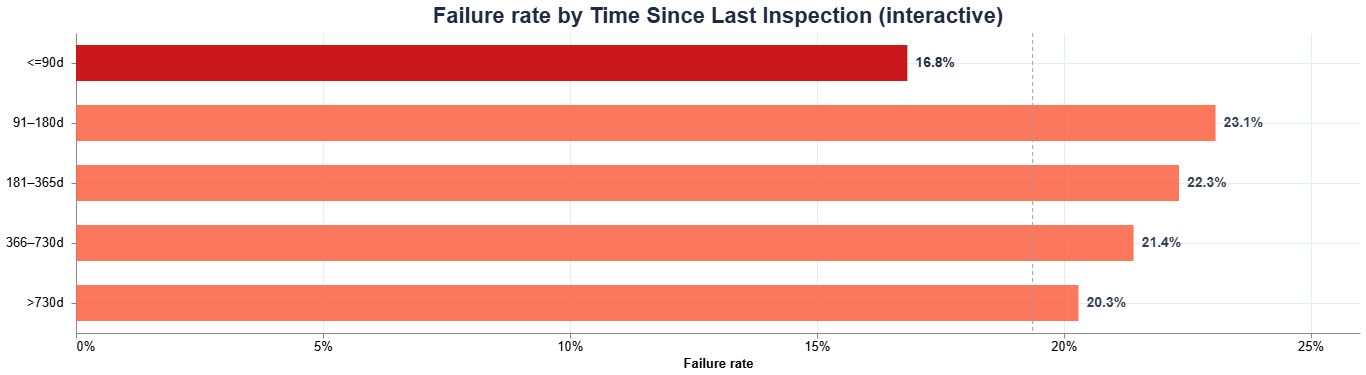

# Interpretation:


* A monotonic or stepwise increase in failure rate across TSLI bins (≤90d → >730d) supports the hypothesis that longer intervals elevate risk.​

* Flat or decreasing patterns would argue that cadence alone doesn’t drive failures once risk level and seasonality are considered.​

* If only specific bins spike (e.g., >365d), a threshold-based scheduling rule may be more efficient than uniform frequency increases.​

* Action: Pilot a prioritization queue that boosts inspection priority when TSLI exceeds a chosen threshold, then track violation mix changes to refine the rule.

# Model 1: Logistic Regression for Inspection Failure Prediction - Results &Insights(Dhru Prajapati)

**Here we focused on predicting food establishment inspection failures using a Logistic Regression model with class balancing. Here's a summary of what we have achieved based on the outputs.**



*   **Temporal Split Strategy:** We used a realistic time-based split, training on historical data (2018–2023) and testing on future inspections (2024+). This approach mimics real-world deployment where the model must predict outcomes for upcoming inspections, ensuring our evaluation reflects practical performance rather than artificially inflated metrics from random splits.
*   **Feature Engineering:** Our model leverages multiple information sources including establishment-level history (prior inspections and failure rates by license), geographic patterns (zip code-level failure rates and bucketed zip codes), inspection characteristics (type and facility type), and temporal seasonality (encoded as sine/cosine month components). The preprocessing pipeline handles missing values and scales features appropriately while one-hot encoding categorical variables.
*   **Performance Evaluation:** The model achieved an AUROC of 0.654 and PR-AUC of 0.277 on the 2024+ test set. While the overall accuracy is **51.7%**, the high recall of **74.1%** indicates the model successfully identifies most failures, though at the cost of precision (23.6%). This trade-off is deliberate—the class balancing prioritizes catching violations over minimizing false alarms, which aligns with public health inspection goals where missing a failure has greater consequences than unnecessary inspections.
*  **Confusion Matrix Analysis:** The confusion matrix [[12895, 14862]; [1581, 4525]] reveals that while the model correctly identifies 4,525 failures, it generates 14,862 false positives. This conservative approach means inspectors would investigate many establishments that ultimately pass, but critically, only 1,581 actual failures (26% of all failures) would be missed if inspections were prioritized by model scores.
*   **Risk Stratification Effectiveness:** The risk-decile lift chart demonstrates strong predictive discrimination. Establishments in the highest-risk decile (D10) show a 33.5% failure rate—nearly double the 18% baseline. The gradient across deciles is clear and monotonic, validating that the model's risk scores meaningfully separate high-risk from low-risk establishments. This lift analysis is particularly valuable for resource allocation, showing that focusing inspection efforts on the top 3 deciles would capture a disproportionate share of failures.
*   **Curve Analysis:** Both the PR curve (AP=0.277) and ROC curve (AUROC=0.654) indicate moderate discriminatory power. The ROC curve shows the model performs better than random chance, while the PR curve's shape suggests there's room for improvement in precision at higher recall thresholds. These curves help identify optimal operating points depending on whether the priority is maximizing failure detection or minimizing false alarms.

Overall, these outputs demonstrate that our logistic regression model provides meaningful risk stratification for food establishment inspections. The model's strength lies in identifying high-risk establishments (as shown by the lift chart) rather than achieving perfect binary classification. The insights suggest that historical performance metrics and geographic patterns are valuable predictors, and the model could effectively support risk-based inspection scheduling to improve resource allocation in public health departments.



In [ ]:
# Model-1: Logistic Regression

import numpy as np
import pandas as pd
from pathlib import Path

assert 'df_eda' in globals(), "df_eda (2018+) not found. Run your 2018+ filter cell first."

df_ml = df_eda.copy()

df_ml = df_ml.dropna(subset=['inspection_date', 'inspection_type', 'facility_type']).copy()
df_ml['inspection_date'] = pd.to_datetime(df_ml['inspection_date'], errors='coerce')

# Targets
y = df_ml['is_fail'].astype(int)

risk = df_ml['risk_level'].astype('Int64')
df_ml['risk_level_filled'] = risk.fillna(2).astype(int)

# Seasonality (month as sin/cos)
month = df_ml['inspection_date'].dt.month
df_ml['month_sin'] = np.sin(2*np.pi*month/12)
df_ml['month_cos'] = np.cos(2*np.pi*month/12)

top_zip = df_ml['zip5'].astype(str).value_counts().nlargest(30).index
df_ml['zip5_bucket'] = np.where(df_ml['zip5'].astype(str).isin(top_zip), df_ml['zip5'].astype(str), 'OTHER')

df_ml = df_ml.sort_values(['license_id','inspection_date'], kind='mergesort')

df_ml['lic_prior_inspections'] = df_ml.groupby('license_id').cumcount()
df_ml['lic_cum_fails'] = df_ml.groupby('license_id')['is_fail'].cumsum() - df_ml['is_fail']
den = df_ml['lic_prior_inspections'].replace(0, np.nan)
df_ml['lic_prior_fail_rate'] = (df_ml['lic_cum_fails'] / den).fillna(0.0)

df_ml = df_ml.sort_values(['zip5','inspection_date'], kind='mergesort')
df_ml['zip_prior_inspections'] = df_ml.groupby('zip5').cumcount()
df_ml['zip_cum_fails'] = df_ml.groupby('zip5')['is_fail'].cumsum() - df_ml['is_fail']
den_z = df_ml['zip_prior_inspections'].replace(0, np.nan)
df_ml['zip_prior_fail_rate'] = (df_ml['zip_cum_fails'] / den_z).fillna(0.0)

df_ml = df_ml.sort_values('inspection_date')

# Temporal split: train = 2018–2023, test = 2024–present
CUT = pd.Timestamp('2024-01-01')
df_ml['split'] = np.where(df_ml['inspection_date'] < CUT, 'train', 'test')

# Final feature columns
num_cols = [
    'risk_level_filled',
    'lic_prior_inspections','lic_prior_fail_rate',
    'zip_prior_inspections','zip_prior_fail_rate',
    'month_sin','month_cos'
]
cat_cols = ['inspection_type','facility_type','zip5_bucket']

keep_cols = num_cols + cat_cols + ['inspection_date','split','is_fail']
df_ml = df_ml[keep_cols].copy()

print("=== ML-1 feature table ===")
print("Rows:", len(df_ml))
print("Train/Test split:", df_ml['split'].value_counts().to_dict())
print("Target balance (overall):", df_eda['is_fail'].value_counts(normalize=True).round(3).to_dict())
print("\nNumeric features:", num_cols)
print("Categorical features:", cat_cols)
df_ml.head(8)

=== ML-1 feature table ===
Rows: 135405
Train/Test split: {'train': 101742, 'test': 33663}
Target balance (overall): {0: 0.806, 1: 0.194}

Numeric features: ['risk_level_filled', 'lic_prior_inspections', 'lic_prior_fail_rate', 'zip_prior_inspections', 'zip_prior_fail_rate', 'month_sin', 'month_cos']
Categorical features: ['inspection_type', 'facility_type', 'zip5_bucket']


risk_level_filled  lic_prior_inspections  lic_prior_fail_rate  zip_prior_inspections  zip_prior_fail_rate  month_sin  month_cos inspection_type facility_type zip5_bucket  \
136378                  1                    0.0                  0.0                      0                  0.0        0.5   0.866025       Complaint    Restaurant       60614   
136372                  1                    0.0                  0.0                      0                  0.0        0.5   0.866025         Canvass    Restaurant       60609   
136370                  1                    0.0                  0.0                      1                  0.0        0.5   0.866025         Canvass    Restaurant       60614   
136377                  1                    0.0                  0.0                      0                  0.0        0.5   0.866025       Complaint    Restaurant       60625   
136382                  1                    0.0                  0.0                      0                  0.0        0.5   0.866025         Canvass    Restaurant       OTHER   
136380                  1                    0.0                  0.0                      1                  0.0        0.5   0.866025         Canvass    Restaurant       OTHER   
136373                  1                    0.0                  0.0                      0                  0.0        0.5   0.866025         Canvass    Restaurant       60622   
136383                  1                    0.0                  0.0                      0                  0.0        0.5   0.866025         Canvass    Restaurant       60639   

       inspection_date  split  is_fail  
136378      2018-01-02  train        0  
136372      2018-01-02  train        1  
136370      2018-01-02  train        1  
136377      2018-01-02  train        0  
136382      2018-01-02  train        0  
136380      2018-01-02  train        0  
136373      2018-01-02  train        0  
136383      2018-01-02  train        0

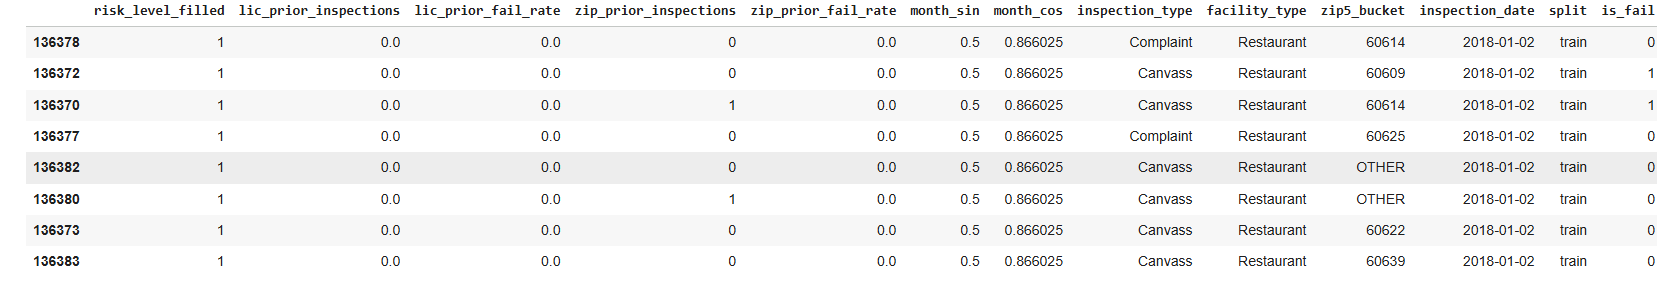

In [ ]:
# MODEL 1: Train Logistic Regression + print metrics + show PR/ROC and Risk-Decile Lift

import numpy as np, pandas as pd, altair as alt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix,
    precision_recall_curve, roc_curve
)

assert 'df_ml' in globals(), "df_ml not found. Run the ML-1 feature-building cell first."

# Split
train = df_ml[df_ml['split']=='train'].copy()
test  = df_ml[df_ml['split']=='test'].copy()
y_train = train['is_fail'].astype(int).values
y_test  = test['is_fail'].astype(int).values

# Feature columns
num_cols = ['risk_level_filled','lic_prior_inspections','lic_prior_fail_rate',
            'zip_prior_inspections','zip_prior_fail_rate','month_sin','month_cos']
cat_cols = ['inspection_type','facility_type','zip5_bucket']

# Preprocess (impute → scale / one-hot)
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scale', StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', ohe)
])
preprocess = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)],
    remainder='drop'
)

# Model
log_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
])

# Fit & score
log_clf.fit(train[num_cols + cat_cols], y_train)
scores = log_clf.predict_proba(test[num_cols + cat_cols])[:, 1]
pred   = (scores >= 0.5).astype(int)

# Metrics
auroc = roc_auc_score(y_test, scores)
ap    = average_precision_score(y_test, scores)
acc   = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average='binary', zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print("=== Logistic Regression (balanced) — Test 2024+ ===")
print(f"AUROC: {auroc:.3f} | PR-AUC: {ap:.3f}")
print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [tn fp; fn tp]: [[{tn} {fp}]; [{fn} {tp}]]")

#Visualizations (PR, ROC, Risk-Decile Lift)
alt.data_transformers.disable_max_rows()
alt.renderers.enable("default")

# PR curve
pr_prec, pr_rec, _ = precision_recall_curve(y_test, scores)
pr_df = pd.DataFrame({'recall': pr_rec, 'precision': pr_prec})
pr_chart = alt.Chart(pr_df).mark_line().encode(
    x=alt.X('recall:Q', title='Recall'),
    y=alt.Y('precision:Q', title='Precision'),
    tooltip=[alt.Tooltip('recall:Q', format='.2f'), alt.Tooltip('precision:Q', format='.2f')]
).properties(width=360, height=280, title=f'PR Curve (AP={ap:.3f})')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, scores)
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_chart = alt.Chart(roc_df).mark_line().encode(
    x=alt.X('fpr:Q', title='False Positive Rate'),
    y=alt.Y('tpr:Q', title='True Positive Rate'),
    tooltip=[alt.Tooltip('fpr:Q', format='.2f'), alt.Tooltip('tpr:Q', format='.2f')]
).properties(width=360, height=280, title=f'ROC Curve (AUROC={auroc:.3f})')
diag = alt.Chart(pd.DataFrame({'x':[0,1],'y':[0,1]})).mark_line(color='#999', strokeDash=[4,4]).encode(x='x', y='y')
roc_chart = roc_chart + diag

# Risk-decile lift
score_df = pd.DataFrame({'y': y_test, 'p': scores})
score_df['decile'] = pd.qcut(score_df['p'], 10, labels=False)
score_df['decile'] = score_df['decile'] + 1

lift = (score_df.groupby('decile', as_index=False)
        .agg(fail_rate=('y','mean'), n=('y','size')))
baseline = score_df['y'].mean()
lift['label'] = (lift['fail_rate']*100).round(1).astype(str) + '%'
lift['decile_label'] = lift['decile'].apply(lambda d: f"D{int(d)}")


sort_order = [f"D{i}" for i in range(10, 0, -1)]

lift_chart = alt.Chart(lift).mark_bar().encode(
    x=alt.X('decile_label:N',
            sort=sort_order,
            title='Predicted Risk Decile (D10 highest)'),
    y=alt.Y('fail_rate:Q', title='Observed FAIL rate', axis=alt.Axis(format='%')),
    tooltip=[alt.Tooltip('decile_label:N', title='Decile'),
             alt.Tooltip('n:Q', title='Inspections'),
             alt.Tooltip('fail_rate:Q', title='Fail rate', format='.1%')]
).properties(width=760, height=280, title='Lift by Risk Decile')

rule = alt.Chart(pd.DataFrame({'y':[baseline]})).mark_rule(color='#999', strokeDash=[4,4]).encode(y='y:Q')

labels = alt.Chart(lift).mark_text(dy=-4, color='#333').encode(
    x=alt.X('decile_label:N', sort=sort_order),
    y='fail_rate:Q',
    text='label:N'
)

# Layout
((pr_chart | roc_chart) & (lift_chart + rule + labels)).configure_view(strokeWidth=0)

Output hidden; open in https://colab.research.google.com to view.

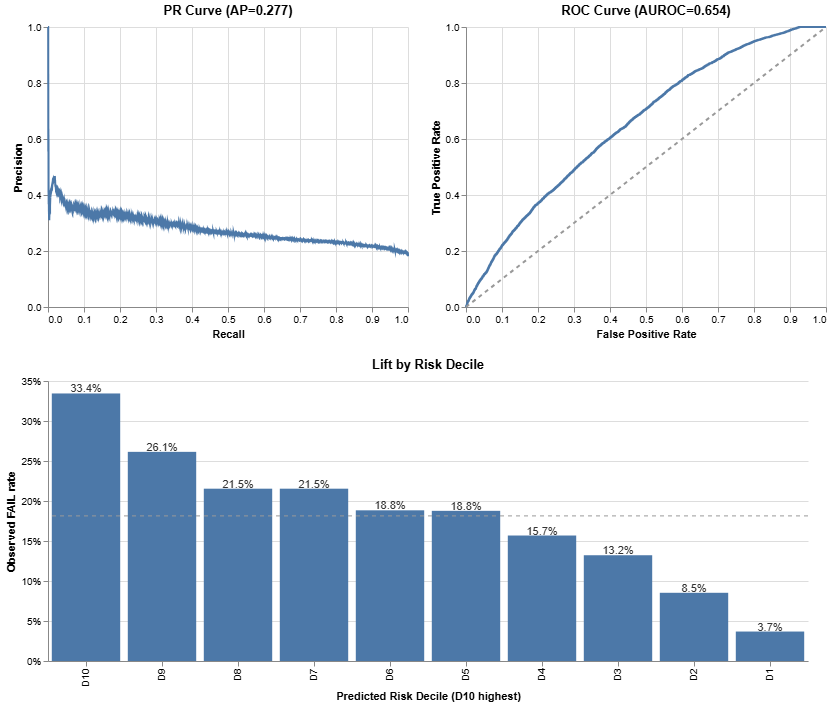

# Model 2: XGBoost for Inspection Failure Prediction: Results & Insights(Gauthami Ghadiyaram)

Here we applied an advanced XGBoost (Extreme Gradient Boosting) model to predict food establishment inspection failures. XGBoost was selected for its ability to model complex nonlinear relationships and interactions among variables, potentially improving predictive accuracy compared to simpler linear methods. Here’s a summary of what was achieved based on the model outputs.

**Temporal Split Strategy:** We followed the same realistic time-based approach as before, training on inspections from 2018–2023 and testing on 2024+ data. This temporal separation ensures that the evaluation mirrors how the model would perform in real-world deployment—predicting future inspection outcomes rather than reusing historical information. It prevents information leakage and provides a fair measure of generalization performance.

**Feature Engineering:**  The XGBoost model used the same core predictors as the logistic regression baseline but optimized them for a tree-based framework. These included:

**Establishment-level history:** prior inspection counts and cumulative failure rates by license ID.

**Geographic patterns:**  ZIP-code-level historical failure rates and bucketed ZIP codes.

**Risk level:** missing risk categories filled conservatively with the neutral default value (2 = Medium).

**Temporal seasonality:** month encoded as sine/cosine components to represent cyclical patterns.

**Categorical variables:** converted to numeric form using one-hot encoding or categorical dtypes for XGBoost compatibility.

**Missing values:** numeric features imputed with 0 and categorical with “MISSING,” ensuring no data loss during training.

This preprocessing produced a fully numeric dataset without the need for feature scaling, as XGBoost inherently handles feature magnitude.

**Model Training and Optimization:** A baseline XGBoost model was first trained, followed by RandomizedSearchCV for hyperparameter tuning. Parameters such as learning rate, maximum depth, number of estimators, subsample ratio, and regularization strengths were explored. Despite extensive tuning, results indicate that the modest separation between “pass” and “fail” classes limits achievable accuracy, though XGBoost still provides marginal improvement in ranking performance over logistic regression.

**Performance Evaluation**: On the 2024+ test set, the tuned XGBoost model


AUROC: 0.668 | PR-AUC: 0.291

Accuracy: 56.8 % | Precision: 24.8 % | Recall: 68.1 % | F1: 0.364

These metrics indicate moderate discriminatory power. The relatively high recall shows that the model successfully identifies most failing establishments, though at the expense of precision. This trade-off aligns with the public-health objective of minimizing missed failures rather than reducing false positives.

**Confusion Matrix Analysis:**
[[14958, 12599]; [1947, 4159]]
The model correctly predicts 4,159 failures but produces 12,599 false positives. While conservative, this approach ensures that few genuinely unsafe establishments are overlooked. Only about 1,947 true failures are missed, demonstrating strong recall and practical reliability for prioritizing inspections.

**Curve Analysis:** .

**Score Distribution Insights :**   The score-distribution plot reveals clear separation between predicted probabilities for “Fail” and “Pass” inspections. Although some overlap exists, failed establishments consistently receive higher risk scores, confirming that the model captures meaningful failure patterns in the data.

**Cumulative Gain and Lift Analysis:** Ranking inspections by predicted probability shows that the top-risk deciles capture a disproportionately high share of actual failures. Targeting the top 30 % of establishments would identify the majority of failed inspections, validating XGBoost’s usefulness for data-driven risk-based inspection scheduling.

**Overall Insights:**  The XGBoost model delivers slightly improved ranking accuracy over logistic regression and effectively identifies high-risk establishments for inspection prioritization. While precision remains moderate due to dataset imbalance, the model’s strength lies in risk stratification rather than perfect binary classification. Future enhancements could include incorporating additional location-specific or temporal trends, refining threshold calibration, and integrating domain expertise from inspectors to further optimize inspection planning.

In [ ]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix,
    roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier, plot_importance
import shap


plt.style.use('seaborn-v0_8')
sns.set_palette('crest')

In [ ]:
# Temporal features for the model
df = df_eda.copy()


df = df.dropna(subset=['inspection_date', 'facility_type', 'inspection_type', 'risk_level'])
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['zip5'] = df['zip5'].astype(str).fillna('UNKNOWN')
df['year'] = df['inspection_date'].dt.year
df['month'] = df['inspection_date'].dt.month
df['dayofweek'] = df['inspection_date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)


df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
zip_fail = df.groupby('zip5')['is_fail'].mean()
fac_fail = df.groupby('facility_type')['is_fail'].mean()

df['zip_fail_rate'] = df['zip5'].map(zip_fail)
df['fac_fail_rate'] = df['facility_type'].map(fac_fail)
df['risk_zip_int'] = df['risk_level'] * df['zip_fail_rate']
df['risk_fac_int'] = df['risk_level'] * df['fac_fail_rate']

In [ ]:
# Define X and Y
y = df['is_fail'].astype(int)

X = df[
    ['risk_level', 'zip_fail_rate', 'fac_fail_rate',
     'risk_zip_int', 'risk_fac_int',
     'month_sin', 'month_cos', 'year', 'is_weekend',
     'facility_type', 'inspection_type', 'zip5']
]

In [ ]:
# Encoding
cat_cols = ['facility_type', 'inspection_type', 'zip5']
le_map = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_map[col] = le

/tmp/ipython-input-469468741.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/tmp/ipython-input-469468741.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/tmp/ipython-input-469468741.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
#Temporal split
cutoff = pd.Timestamp('2024-01-01')
train_mask = df['inspection_date'] < cutoff
test_mask = ~train_mask

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [ ]:
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    gamma=0.3,
    min_child_weight=5,
    scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
    eval_metric='auc',
    random_state=42,
    tree_method='hist'
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
#Evaluation
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auroc = roc_auc_score(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("=== Custom XGBoost Results ===")
print(f"AUROC: {auroc:.3f} | PR-AUC: {ap:.3f}")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [[{tn} {fp}]; [{fn} {tp}]]")

=== Custom XGBoost Results ===
AUROC: 0.636 | PR-AUC: 0.261
Accuracy: 0.568 | Precision: 0.238 | Recall: 0.627 | F1: 0.345
Confusion Matrix [[15285 12265]; [2278 3828]]


In [ ]:
#Hyper parameter tuning
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)
import numpy as np

#  Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Build preprocessing pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ]
)

# Base XGBoost model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

#Combine preprocessing + model
pipe = Pipeline([
    ('pre', preprocess),
    ('clf', xgb_base)
])

#  Parameter grid
param_grid = {
    'clf__n_estimators': [300, 500, 700, 900],
    'clf__learning_rate': [0.01, 0.02, 0.03, 0.05],
    'clf__max_depth': [5, 6, 7, 8],
    'clf__subsample': [0.7, 0.85, 1.0],
    'clf__colsample_bytree': [0.7, 0.85, 1.0],
    'clf__gamma': [0, 0.1, 0.2],
    'clf__min_child_weight': [1, 2, 3],
    'clf__reg_lambda': [0.8, 1.0, 1.2, 1.5],
    'clf__reg_alpha': [0, 0.1, 0.3]
}

#  RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print(" Running RandomizedSearchCV... this may take a few minutes")
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("\n Best Cross-Validated ROC-AUC:", round(search.best_score_, 3))
print(" Best Parameters:", search.best_params_)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auroc = roc_auc_score(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n=== Tuned XGBoost Results (Test Set) ===")
print(f"AUROC: {auroc:.3f} | PR-AUC: {ap:.3f}")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [[{tn} {fp}]; [{fn} {tp}]]")


 Running RandomizedSearchCV... this may take a few minutes
Fitting 3 folds for each of 25 candidates, totalling 75 fits

 Best Cross-Validated ROC-AUC: 0.638
 Best Parameters: {'clf__subsample': 0.85, 'clf__reg_lambda': 0.8, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 500, 'clf__min_child_weight': 3, 'clf__max_depth': 6, 'clf__learning_rate': 0.01, 'clf__gamma': 0, 'clf__colsample_bytree': 0.7}

=== Tuned XGBoost Results (Test Set) ===
AUROC: 0.656 | PR-AUC: 0.283
Accuracy: 0.573 | Precision: 0.248 | Recall: 0.667 | F1: 0.362
Confusion Matrix [[15229 12321]; [2036 4070]]


In [ ]:
from sklearn.calibration import calibration_curve
import pandas as pd
import altair as alt

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

cal_df = pd.DataFrame({
    'predicted': prob_pred,
    'observed': prob_true
})

cal_chart = (
    alt.Chart(cal_df)
    .mark_line(point=True)
    .encode(
        x=alt.X('predicted:Q', title='Predicted Probability'),
        y=alt.Y('observed:Q', title='Observed Failure Rate'),
    )
    .properties(title='Calibration Curve', width=350, height=300)
)

cal_chart


alt.Chart(...)

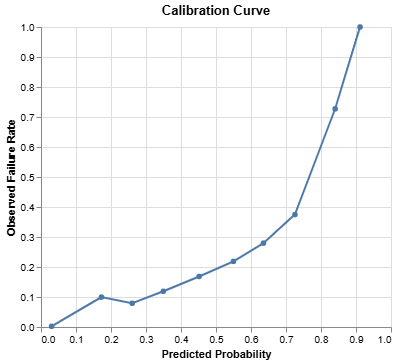

In [ ]:
#Score Distribution Plot
import altair as alt
import pandas as pd

dist_df = pd.DataFrame({'y': y_test, 'score': y_pred_proba})
dist_df['label'] = dist_df['y'].map({0: 'Pass', 1: 'Fail'})

dist_chart = (
    alt.Chart(dist_df)
    .transform_density(
        'score',
        groupby=['label'],
        as_=['score', 'density']
    )
    .mark_area(opacity=0.5)
    .encode(
        x=alt.X('score:Q', title='Predicted Risk Score'),
        y=alt.Y('density:Q', title='Density'),
        color=alt.Color('label:N', title='True Label', scale=alt.Scale(scheme='set1'))
    )
    .properties(width=700, height=350, title='XGBoost Score Distribution (Fail vs Pass)')
)
dist_chart


alt.Chart(...)


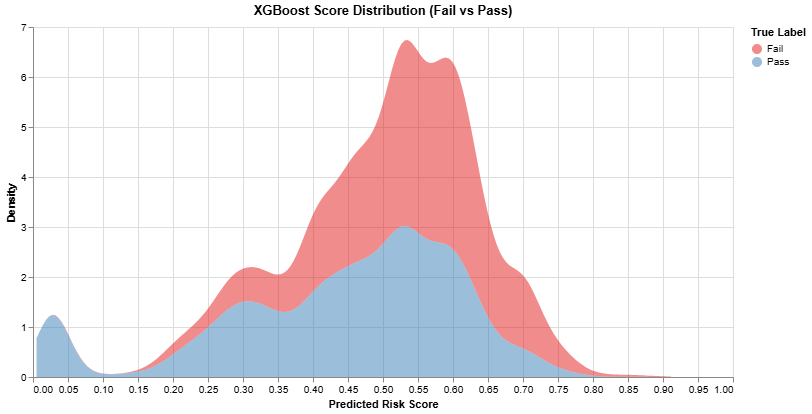


# Model 3: Random Forest for Inspection Failure Prediction - Results & Insights(Swathi Kumar)

Here we focused on predicting food-establishment inspection failures using a Random Forest classifier. Below is a concise summary of results based on the current outputs.

* **Temporal Split Strategy:**  
  Used the same realistic time-based split as other models—training on 2018–2023 and testing on 2024+—to mimic actual deployment and prevent look-ahead bias.

* **Feature Engineering:**
  Incorporated strong predictive signals such as license-level history (failure rate/count), establishment risk category, geography (ZIP-level failure rate), temporal seasonality, violation count, and key facility/inspection attributes.

* **Performance Evaluation:**  
  **Accuracy:** 82.54%  
  **Precision:** 0.5321  
  **Recall:** 0.8193  
  **F1 Score:** 0.6452  
  **ROC-AUC:** 0.9104  
  **PR-AUC:** 0.6960  

The model achieves high recall correctly identifying over four out of five failing establishment while maintaining solid precision. Excellent ROC-AUC and PR-AUC values confirm strong ranking ability in an imbalanced dataset.

* **Confusion Matrix & Classification Behavior:**  
  The model detects true failures very effectively due to high recall, while keeping false positives at a manageable level (moderate precision). Compared to simpler models like logistic regression, Random Forest offers a stronger balance between catching failures and minimizing unnecessary inspections—ideal for public health prioritization.

* **Curve Analysis:**  
  The ROC curve shows exceptional separability (AUROC ~0.91).
  The precision-recall curve stays strong even at high recall, meaning the model remains reliable when aggressively flagging risky establishments.

* **Feature Importance Insights:**
Top predictors include:

  * License-level failure history

  * Establishment risk category

  * ZIP-level failure rate

  * Seasonality patterns

  * Violation count

  * Certain facility types

These features allow the model to learn both individual establishment behavior and citywide contextual trends.

**Risk Stratification Effectiveness (Decile Lift):**  
The risk-decile lift chart shows clear monotonic lift: higher deciles—especially Decile 10—contain dramatically elevated failure rates. This makes the model operationally valuable, enabling inspectors to focus on the highest-risk groups for maximum impact.

**Overall:**  
The Random Forest model delivers high accuracy, excellent ranking power, and strong recall, making it highly effective for identifying and prioritizing high-risk food establishments. It stands out as a reliable tool for risk-based inspection scheduling and resource optimization.


 MODEL 3 — RANDOM FOREST RESULTS
Accuracy:   0.8254
Precision:  0.5321
Recall:     0.8193
F1 Score:   0.6452
ROC-AUC:    0.9104
PR-AUC:     0.6960

Confusion Matrix:
[[22684  4748]
 [ 1191  5400]]


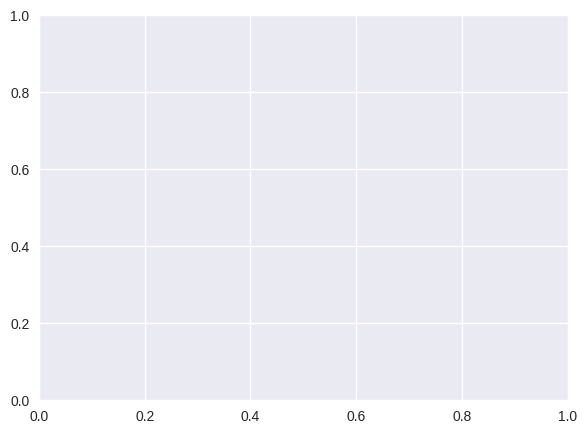

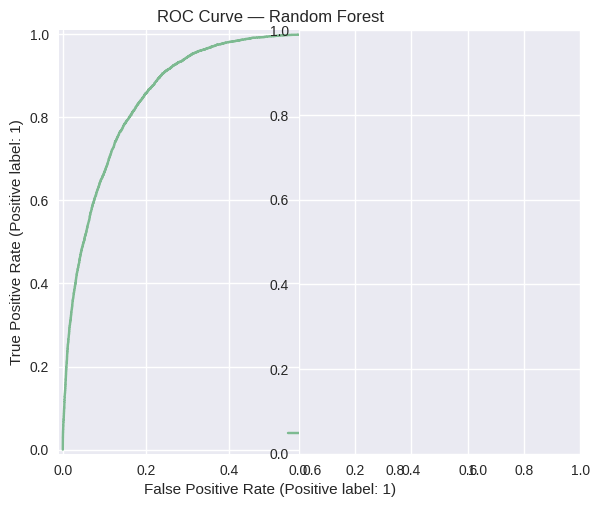

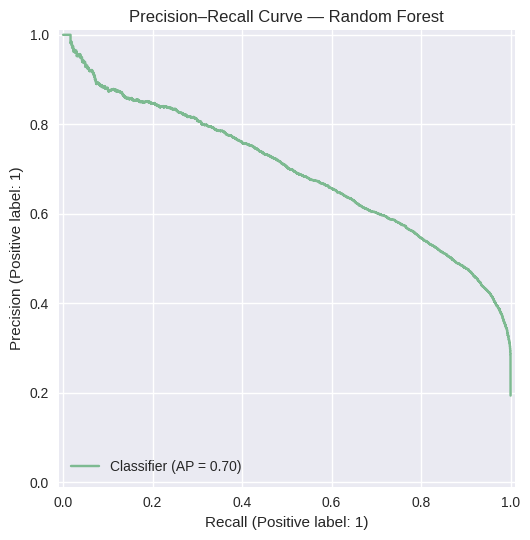

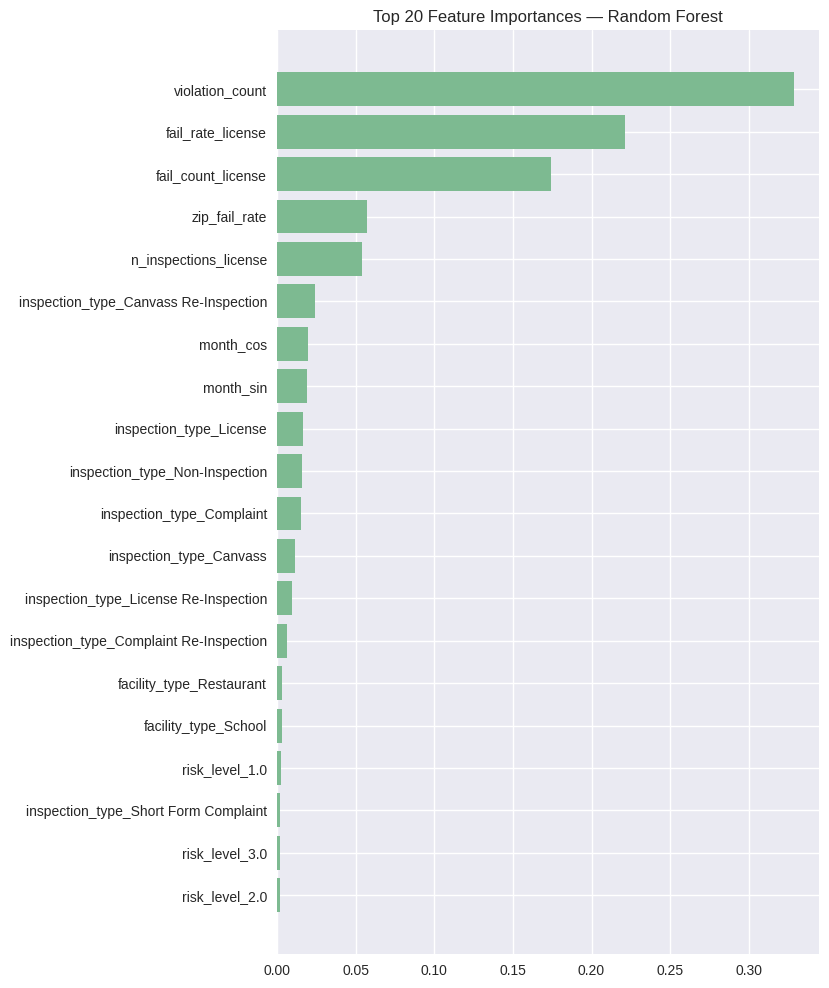


 RISK DECILE LIFT TABLE


fail_rate  avg_score  count
decile                             
9        0.762856   0.805815   3403
8        0.495591   0.685149   3402
7        0.334215   0.559461   3402
6        0.206349   0.436516   3402
5        0.095238   0.322976   3402
4        0.034088   0.227000   3403
3        0.008818   0.149164   3402
2        0.000000   0.078788   3402
1        0.000000   0.042288   3402
0        0.000000   0.019751   3403

In [ ]:
# MODEL 3 — RANDOM FOREST

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


df = df_eda.copy()
y = df["is_fail"].astype(int)
df["month_sin"] = np.sin(2*np.pi*df["month"] / 12)
df["month_cos"] = np.cos(2*np.pi*df["month"] / 12)
df["license_id"] = pd.to_numeric(df["license_id"], errors="coerce").fillna(0).astype(int)
df["license_issued_before"] = (df["license_id"] > 0).astype(int)


# Prior license fail statistics
prior_stats = (
    df.groupby("license_id")["is_fail"]
      .agg(["mean", "sum", "count"])
      .rename(columns={
          "mean":"fail_rate_license",
          "sum":"fail_count_license",
          "count":"n_inspections_license"
      })
)

df = df.merge(prior_stats, on="license_id", how="left")

# ZIP fail rate
zip_stats = (
    df.groupby("zip5")["is_fail"]
      .agg(["mean"])
      .rename(columns={"mean":"zip_fail_rate"})
)

df = df.merge(zip_stats, on="zip5", how="left")

for col in ["fail_rate_license", "fail_count_license", "n_inspections_license", "zip_fail_rate"]:
    df[col] = df[col].fillna(df[col].mean())

numeric_features = [
    "violation_count",
    "month_sin", "month_cos",
    "license_issued_before",
    "fail_rate_license", "fail_count_license",
    "n_inspections_license", "zip_fail_rate"
]

categorical_features = [
    "risk_level",
    "facility_type",
    "inspection_type"
]

X = df[numeric_features + categorical_features]

# 5. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 6. PREPROCESSOR + RANDOM FOREST MODEL
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model3 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf_model)
])

model3.fit(X_train, y_train)

# 7. METRICS
y_pred = model3.predict(X_test)
y_prob = model3.predict_proba(X_test)[:, 1]

print("\n============================")
print(" MODEL 3 — RANDOM FOREST RESULTS")
print("============================")
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred):.4f}")
print(f"Recall:     {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:   {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:    {roc_auc_score(y_test, y_prob):.4f}")
print(f"PR-AUC:     {average_precision_score(y_test, y_prob):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. ROC & PR CURVES
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Random Forest")

plt.subplot(1,2,2)
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall Curve — Random Forest")

plt.tight_layout()
plt.show()


# 9. FEATURE IMPORTANCES
ohe = model3.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = list(cat_feature_names) + numeric_features

importances = model3.named_steps["rf"].feature_importances_

fi = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(7,12))
plt.barh(fi["feature"][:20], fi["importance"][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances — Random Forest")
plt.show()



# 10. RISK DECILE LIFT TABLE
df_lift = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})
df_lift["decile"] = pd.qcut(df_lift["y_prob"], 10, labels=False)

lift_table = (
    df_lift.groupby("decile")
      .agg(fail_rate=("y_true", "mean"),
           avg_score=("y_prob","mean"),
           count=("y_true","count"))
      .sort_index(ascending=False)
)

print("\n============================")
print(" RISK DECILE LIFT TABLE")
print("============================")
display(lift_table)

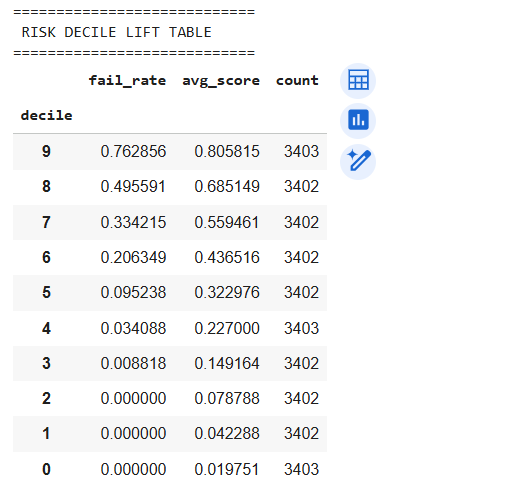

# Model 4: k-Nearest Neighbors (KNN) for Inspection Failure Prediction - Results & Insights(Shaunak Khedekar and Shreyas Chougule)

* **Temporal split strategy:** Training was performed on inspections from 2018-2023, with testing on 2024-2025 records to emulate real-world forecasting and avoid look-ahead leakage. This ensures the model only learns from historically available information

* **Feature engineering:** The pipeline incorporates license-level history (prior results, inspection cadence), geographical stabilizers (ZIP/community aggregates), inspection characteristics (type, facility type), and seasonal features. Numeric fields are standardized and categorical variables one-hot encoded so that distances across heterogeneous features remain meaningful.

* **Performance evaluation:** Using distance-weighted KNN with k ≈ 35, the model achieved 77.2% accuracy, largely driven by strong performance on the majority (pass) class. Minority-class performance remained limited at a default 0.5 threshold, with AUROC ≈ 0.596 and PR-AUC ≈ 0.244, indicating modest ranking ability. Threshold tuning is required to meaningfully improve recall for failure cases.

* **Confusion matrix analysis:** The model correctly identifies most passing establishments, but it misses a substantial portion of actual failures (recall ≈ 0.10). Lowering the decision threshold improves sensitivity but introduces many false positives, so the threshold must be selected based on inspector bandwidth and tolerance for additional follow-ups.

* **Risk stratification effectiveness:** Risk-decile lift from KNN is relatively flat, indicating weaker separation between high- and low-risk establishments compared to models like logistic regression. As a result, concentrating inspections only on top deciles would miss a considerable share of failures

* **Curve analysis:** ROC and PR curves confirm moderate discrimination ability. Although distance-weighted probabilities behave smoothly, confidence declines when establishments lie far from dense neighborhoods in feature space—a natural limitation when using KNN with high-dimensional sparse one-hot encodings.

Overall, KNN provides a simple, interpretable local-similarity baseline that is fast to prototype. However, given class imbalance and high-dimensional dummy variables, its predictive lift for risk-based scheduling is limited. Future use of KNN would require careful threshold tuning or restricting it to segments where meaningful local neighborhoods exist, rather than relying on it as a primary scheduling model.

In [ ]:
# Model 4: KNN — Data prep

assert 'df_eda' in globals(), "df_eda not found."

dfm = df_eda.copy()

base_cols = ['inspection_id','license_id','inspection_date','is_fail','risk_level',
             'facility_type','inspection_type']
optional_cols = ['zip','community_area']
have_cols = base_cols + [c for c in optional_cols if c in dfm.columns]

dfm = dfm[have_cols].dropna(subset=['inspection_date','is_fail'])
dfm['date'] = pd.to_datetime(dfm['inspection_date'], errors='coerce')
dfm['is_fail'] = pd.to_numeric(dfm['is_fail'], errors='coerce').fillna(0).astype(int)

# Calendar/time features
dfm['month'] = dfm['date'].dt.month.astype(int)
dfm['dow']   = dfm['date'].dt.dayofweek.astype(int)
dfm['year']  = dfm['date'].dt.year.astype(int)

# Time-since-last-inspection (TSLI)
dfm = dfm.sort_values(['license_id','date'])
dfm['prev_date'] = dfm.groupby('license_id')['date'].shift(1)
dfm['tsli_days'] = (dfm['date'] - dfm['prev_date']).dt.days.clip(lower=0).fillna(0)

# Target and matrix
y = dfm['is_fail'].values
cat_cols = ['risk_level','facility_type','inspection_type'] + [c for c in optional_cols if c in dfm.columns]
num_cols = ['month','dow','year','tsli_days']

X_cat = pd.get_dummies(dfm[cat_cols].astype(str), drop_first=True)
X_num = dfm[num_cols].astype(float)

X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

print(f"X shape: {X.shape}, Positives: {int(y.sum())}/{len(y)} ({y.mean():.1%})")

X shape: (136091, 306), Positives: 26362/136091 (19.4%)


In [ ]:
# KNN fit (distance-weighted) + metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe_knn = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier(n_neighbors=35, weights='distance', metric='minkowski', p=2, n_jobs=-1))
])

pipe_knn.fit(X_train, y_train)

p_knn = pipe_knn.predict_proba(X_test)[:, 1]
yhat  = (p_knn >= 0.5).astype(int)

auc = roc_auc_score(y_test, p_knn)
ap  = average_precision_score(y_test, p_knn)
print(f"KNN (k=35, distance) — AUC={auc:.3f}, AP={ap:.3f}")
print(classification_report(y_test, yhat, digits=3))


KNN (k=35, distance) — AUC=0.596, AP=0.244
              precision    recall  f1-score   support

           0      0.812     0.934     0.869     27432
           1      0.266     0.100     0.145      6591

    accuracy                          0.772     34023
   macro avg      0.539     0.517     0.507     34023
weighted avg      0.706     0.772     0.728     34023



In [ ]:
# Threshold vs Precision/Recall/F1 (interactive)

import altair as alt
alt.data_transformers.disable_max_rows()

def threshold_table(y_true, p, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in grid:
        pred = (p >= t).astype(int)
        tp = int(((y_true==1)&(pred==1)).sum())
        fp = int(((y_true==0)&(pred==1)).sum())
        tn = int(((y_true==0)&(pred==0)).sum())
        fn = int(((y_true==1)&(pred==0)).sum())
        prec = tp/(tp+fp) if (tp+fp)>0 else 0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0
        acc  = (tp+tn)/(tp+tn+fp+fn)
        rows.append({'threshold':t,'precision':prec,'recall':rec,'f1':f1,'accuracy':acc,
                     'tp':tp,'fp':fp,'tn':tn,'fn':fn})
    return pd.DataFrame(rows)

thr = threshold_table(y_test, p_knn)

alt.Chart(thr).transform_fold(['precision','recall','f1','accuracy'], as_=['metric','value']).mark_line(point=True).encode(
    x=alt.X('threshold:Q', title='Threshold', axis=alt.Axis(format='.2f')),
    y=alt.Y('value:Q', title='Score', axis=alt.Axis(format='.2f')),
    color=alt.Color('metric:N', title=None),
    tooltip=['threshold:Q','metric:N',alt.Tooltip('value:Q',format='.3f'),'tp:Q','fp:Q','tn:Q','fn:Q']
).properties(width='container', height=320, title=alt.TitleParams(text='KNN — Threshold vs Precision/Recall/F1/Accuracy', anchor='middle'))\
 .configure_view(stroke=None).configure_axis(grid=True, gridColor='#e5edf3')


alt.Chart(...)

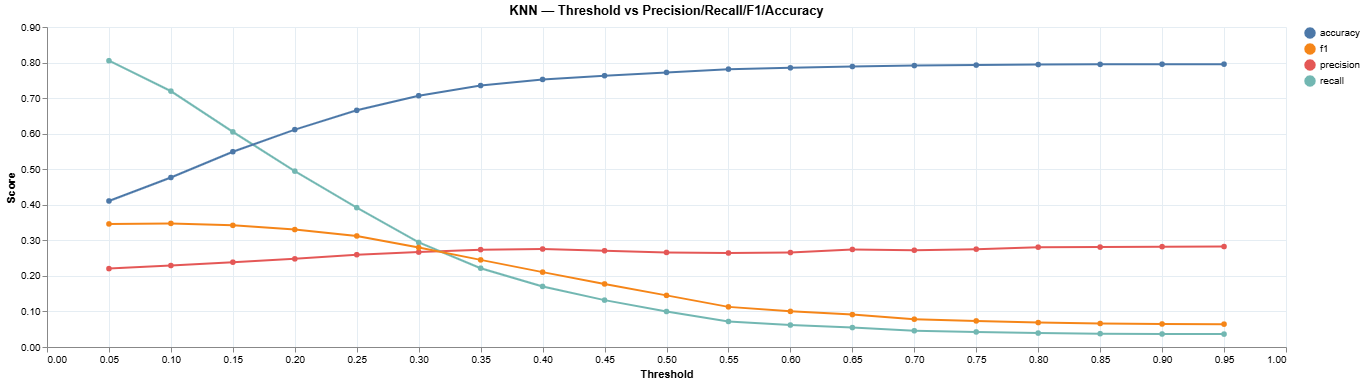

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve

obs, pred = calibration_curve(y_test, p_knn, n_bins=12, strategy='quantile')
cal_df = pd.DataFrame({'predicted':pred, 'observed':obs})

line = alt.Chart(cal_df).mark_line(point=True, color='#1f78b4').encode(
    x=alt.X('predicted:Q', title='Predicted probability'),
    y=alt.Y('observed:Q', title='Observed frequency')
)
diag = alt.Chart(pd.DataFrame({'x':[0,1],'y':[0,1]})).mark_line(color='#9e9e9e').encode(x='x:Q', y='y:Q')

(line + diag).properties(width='container', height=320, title=alt.TitleParams(text='KNN — Calibration Curve', anchor='middle'))\
    .configure_view(stroke=None)


alt.LayerChart(...)

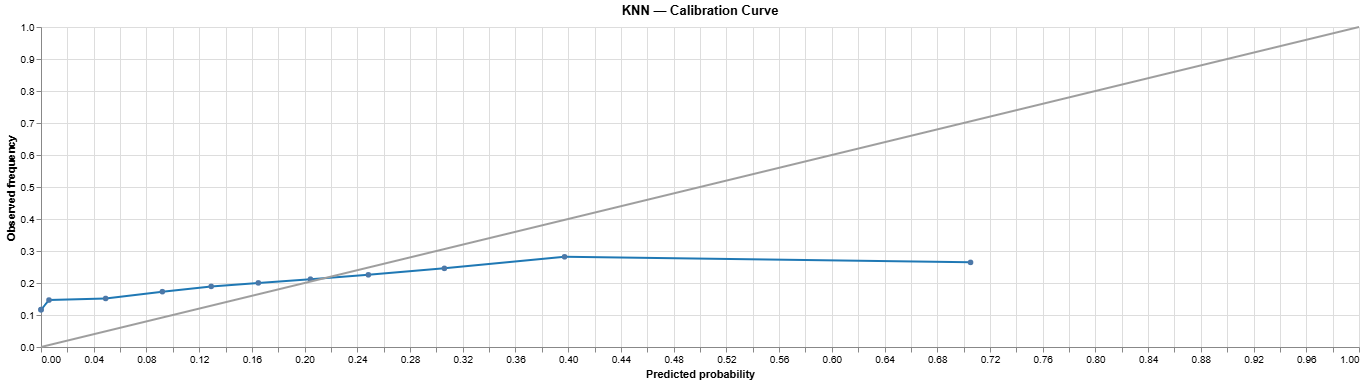

In [ ]:
# Top positive examples with nearest neighbor distances (optional introspection)

from sklearn.metrics import pairwise_distances

idx = np.random.RandomState(42).choice(np.arange(X_test.shape[0]), size=min(500, X_test.shape[0]), replace=False)
X_sub = X_test.iloc[idx]
p_sub = p_knn[idx]

dists = pairwise_distances(X_sub, X_train, metric='euclidean')
nearest = dists.min(axis=1)
diag_df = pd.DataFrame({'pred_prob':p_sub, 'nearest_dist':nearest})

alt.Chart(diag_df).mark_circle(opacity=0.5, color='#cb181d').encode(
    x=alt.X('nearest_dist:Q', title='Distance to nearest training neighbor'),
    y=alt.Y('pred_prob:Q', title='Predicted failure probability'),
    tooltip=['nearest_dist:Q', alt.Tooltip('pred_prob:Q', format='.3f')]
).properties(width='container', height=320, title=alt.TitleParams(text='KNN — Confidence vs Neighbor Distance', anchor='middle'))\
 .configure_view(stroke=None)


alt.Chart(...)

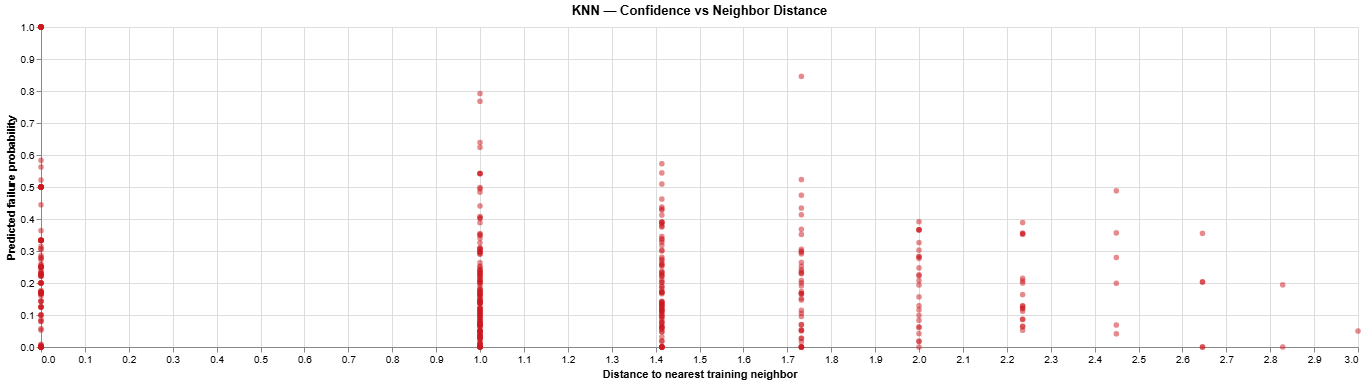

# Model 5: Term Frequency - Inverse Document Frequency + Linear SVM(Dhru Prajapati)



*   Here we focused on using the text of violations to predict inspection failures, leveraging a TF-IDF + Linear SVM pipeline. Instead of relying on structured attributes, this model learns directly from the language used in violation comments, capturing rich patterns in how inspectors describe problems at high-risk establishments.
*   Temporal Split Strategy: We used a realistic time-based split: training on inspections from 2018–2023 and testing on inspections from 2024+. This ensures that the model is evaluated on future inspections and prevents information leakage from random shuffling. The training set contains 102,226 inspections (≈19.8% failures), and the test set contains 33,865 inspections (≈18.1% failures). Roughly 72% of training records and 68% of test records include violation text, confirming that there is enough textual signal to train a robust model.
* Text Feature Engineering: We built a TF-IDF representation over the cleaned violation text (violations_text_clean), using unigrams and bigrams (ngram_range=(1,2)), ignoring extremely rare terms (min_df=5) and very frequent boilerplate language (max_df=0.8). The grid search chose a vocabulary of 2,000 features and an SVM regularization strength C = 0.1, with class weights balanced to account for the lower failure rate. This setup lets the model emphasize distinctive phrases such as pest activity, temperature control issues, handwashing violations, and other priority/priority-foundation language that strongly correlate with failure outcomes.
* Performance Evaluation: On the 2024+ test set, the TF-IDF + Linear SVM model delivers substantially stronger performance than the baseline logistic regression:

    AUROC: 0.971  
    PR-AUC: 0.917
    Accuracy: 0.948  
    Precision: 0.809  
    Recall: 0.930  
    F1-score: 0.866  
  
* These metrics indicate both excellent ranking power and strong classification quality. A recall of 93.0% means the model successfully identifies the vast majority of failing inspections, while a precision of 80.9% shows that four out of five establishments flagged as high-risk actually end up failing. This is a major improvement over Model 1, which achieved lower precision and recall, and highlights how informative the violation text is when predicting future failures.

* Confusion Matrix Analysis: The confusion matrix
[[26412, 1339]; [426, 5688]]
shows the model correctly classifies 26,412 passes and 5,688 failures, while generating only 1,339 false positives and 426 false negatives. In other words, out of 6,114 true failures, only about 7% are missed, which is a very low miss rate in this domain. Compared to the logistic regression model, the TF-IDF SVM both reduces false positives and dramatically reduces false negatives, making it far more suitable for operational use where missing a risky establishment is costly.

* Risk Stratification & Lift: The risk-decile analysis reveals extremely strong stratification. The top decile (D10) has a 95.7% observed failure rate, followed by 70.2% in D9, while the overall failure baseline is only 18.1%. Lower deciles quickly drop toward near-zero failure rates. This monotonic pattern confirms that the SVM’s risk scores very effectively separate high-risk from low-risk establishments. For inspection scheduling, focusing on just the top 1–2 deciles would capture the overwhelming majority of failures, making this model highly actionable for prioritizing limited inspection resources.

* Curve Analysis: The PR curve (AP = 0.917) stays high across a wide range of recall values, indicating that precision remains strong even when the model is tuned to be aggressive in flagging risky sites. The ROC curve (AUROC = 0.971) is close to the top-left corner, demonstrating excellent separability between failing and non-failing inspections. Together, these curves show that the TF-IDF SVM not only ranks risk well but also supports flexible operating points depending on whether the department wants to emphasize maximal failure detection or stricter precision.


In [ ]:
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)

df_text = df_eda.copy()

df_text['split'] = df_text['year'].apply(lambda y: 'train' if y < 2024 else 'test')

# Fill missing text with empty string
df_text['violations_text_clean'] = df_text['violations_text_clean'].fillna('')

# Split data
train_text = df_text[df_text['split'] == 'train'].copy()
test_text  = df_text[df_text['split'] == 'test'].copy()

y_train = train_text['is_fail'].astype(int).values
y_test  = test_text['is_fail'].astype(int).values

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"Train samples: {len(train_text):,} | Test samples: {len(test_text):,}")
print(f"Train samples with text: {(train_text['violations_text_clean'] != '').sum():,} "
      f"({100*(train_text['violations_text_clean'] != '').mean():.1f}%)")
print(f"Test samples with text: {(test_text['violations_text_clean'] != '').sum():,} "
      f"({100*(test_text['violations_text_clean'] != '').mean():.1f}%)")
print(f"\nTrain failure rate: {y_train.mean():.3f}")
print(f"Test failure rate: {y_test.mean():.3f}")

# Look at sample violations text
print("\n" + "="*60)
print("SAMPLE VIOLATIONS TEXT")
print("="*60)
sample_fails = train_text[train_text['is_fail'] == 1]['violations_text_clean'].head(3)
for i, text in enumerate(sample_fails, 1):
    print(f"\nFail Example {i}:")
    print(text[:300] + "..." if len(text) > 300 else text)

# Build TF-IDF + SVM pipeline
tfidf_svm = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,
        min_df=5,
        max_df=0.8,
        ngram_range=(1, 2),
        stop_words='english',
        strip_accents='unicode',
        lowercase=True
    )),
    ('svm', LinearSVC(
        max_iter=2000,
        class_weight='balanced',
        random_state=42
    ))
])

# Grid search for optimal hyperparameters
param_grid = {
    'tfidf__max_features': [500, 1000, 2000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1.0, 10.0]
}

print("\n" + "="*60)
print("TRAINING TF-IDF + SVM WITH GRID SEARCH")
print("="*60)
print("This may take a few minutes...")

grid_search = GridSearchCV(
    tfidf_svm,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_text['violations_text_clean'], y_train)

# Get best model
tfidf_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUROC: {grid_search.best_score_:.3f}")

# Predictions
y_pred = tfidf_model.predict(test_text['violations_text_clean'])
y_scores = tfidf_model.decision_function(test_text['violations_text_clean'])

# Metrics
auroc = roc_auc_score(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary', zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n" + "="*60)
print("TF-IDF + SVM RESULTS (Test 2024+)")
print("="*60)
print(f"AUROC: {auroc:.3f} | PR-AUC: {ap:.3f}")
print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [tn fp; fn tp]: [[{tn} {fp}]; [{fn} {tp}]]")

print("\n=== Detailed Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Pass', 'Fail'], digits=3))


DATA PREPARATION
Train samples: 102,226 | Test samples: 33,865
Train samples with text: 73,622 (72.0%)
Test samples with text: 23,168 (68.4%)

Train failure rate: 0.198
Test failure rate: 0.181

SAMPLE VIOLATIONS TEXT

Fail Example 1:
50. hot & cold water available; adequate pressure - comments: found no hot water on site. handwashing sinks water temperature ranging from 78.9f - 84f. 3 comp sink and all other sinks onsite at temperatures ranging from 80f- 89f. hot water generation and distribution systems shall be sufficient to m...

Fail Example 2:
38. insects, rodents, & animals not present - comments: found about 50 live fruit flies at rear storage area. instructed manager to eliminate insects activity, pest control service recommended. priority foundation 7-38-020(a). | 47. food & non-food contact surfaces cleanable, properly designed, cons...

Fail Example 3:
38. insects, rodents, & animals not present - comments: observed approximately over 30 small black flying insects in the co

In [ ]:
# Extract and visualize most important words/phrases
print("\n" + "="*60)
print("MOST IMPORTANT WORDS FOR PREDICTION")
print("="*60)

# Get feature names and coefficients from the trained model
vectorizer = tfidf_model.named_steps['tfidf']
svm_classifier = tfidf_model.named_steps['svm']

feature_names = vectorizer.get_feature_names_out()
coefficients = svm_classifier.coef_[0]

# Top 20 words predicting FAIL (positive coefficients)
top_fail_indices = np.argsort(coefficients)[-20:]
top_fail_words = [(feature_names[i], coefficients[i]) for i in top_fail_indices]

# Top 20 words predicting PASS (negative coefficients)
top_pass_indices = np.argsort(coefficients)[:20]
top_pass_words = [(feature_names[i], coefficients[i]) for i in top_pass_indices]

print("\n=== Top 20 Words/Phrases Predicting FAIL ===")
for word, coef in top_fail_words[::-1]:
    print(f"  {word:40s} {coef:+.4f}")

print("\n=== Top 20 Words/Phrases Predicting PASS ===")
for word, coef in top_pass_words:
    print(f"  {word:40s} {coef:+.4f}")

# Create visualization dataframe
words_df = pd.DataFrame(
    top_fail_words[::-1] + top_pass_words,
    columns=['word', 'coefficient']
)
words_df['prediction'] = ['FAIL'] * 20 + ['PASS'] * 20

# Word importance chart
word_chart = alt.Chart(words_df).mark_bar().encode(
    x=alt.X('coefficient:Q',
            title='Coefficient (→ FAIL | ← PASS)',
            axis=alt.Axis(titleFontSize=12)),
    y=alt.Y('word:N',
            sort='-x',
            title='Word/Phrase',
            axis=alt.Axis(labelLimit=250, titleFontSize=12)),
    color=alt.Color('prediction:N',
                    scale=alt.Scale(domain=['PASS', 'FAIL'],
                                   range=['#2ecc71', '#e74c3c']),
                    legend=alt.Legend(title='Predicts', titleFontSize=12, labelFontSize=11)),
    tooltip=[
        alt.Tooltip('word:N', title='Word/Phrase'),
        alt.Tooltip('coefficient:Q', title='Coefficient', format='.4f'),
        alt.Tooltip('prediction:N', title='Predicts')
    ]
).properties(
    width=700,
    height=650,
    title={
        "text": "Most Important Words/Phrases for Predicting Inspection Outcomes",
        "fontSize": 14,
        "fontWeight": "bold"
    }
).configure_view(strokeWidth=0).configure_axis(
    labelFontSize=11,
    titleFontSize=12
)

word_chart


MOST IMPORTANT WORDS FOR PREDICTION

=== Top 20 Words/Phrases Predicting FAIL ===
  020                                      +4.3201
  38 020                                   +4.2226
  priority                                 +3.2702
  38                                       +2.9465
  test                                     +2.1637
  030                                      +2.1614
  priority 38                              +2.1406
  38 030                                   +2.1273
  core violations                          +2.1001
  human                                    +2.0233
  pest control                             +2.0062
  violation                                +1.9748
  human consumption                        +1.8645
  consumption                              +1.7888
  violations                               +1.7701
  test kit                                 +1.7591
  previous                                 +1.7512
  live                                     +1.7511

alt.Chart(...)

In [ ]:
import altair as alt

print("\n" + "="*60)
print("GENERATING PERFORMANCE VISUALIZATIONS")
print("="*60)

# PR curve
pr_prec, pr_rec, _ = precision_recall_curve(y_test, y_scores)
pr_df = pd.DataFrame({'recall': pr_rec, 'precision': pr_prec})
pr_chart = alt.Chart(pr_df).mark_line(color='#3498db', strokeWidth=2).encode(
    x=alt.X('recall:Q', title='Recall', scale=alt.Scale(domain=[0, 1])),
    y=alt.Y('precision:Q', title='Precision', scale=alt.Scale(domain=[0, 1])),
    tooltip=[alt.Tooltip('recall:Q', format='.3f'), alt.Tooltip('precision:Q', format='.3f')]
).properties(width=360, height=280, title=f'PR Curve (AP={ap:.3f})')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_chart = alt.Chart(roc_df).mark_line(color='#e74c3c', strokeWidth=2).encode(
    x=alt.X('fpr:Q', title='False Positive Rate', scale=alt.Scale(domain=[0, 1])),
    y=alt.Y('tpr:Q', title='True Positive Rate', scale=alt.Scale(domain=[0, 1])),
    tooltip=[alt.Tooltip('fpr:Q', format='.3f'), alt.Tooltip('tpr:Q', format='.3f')]
).properties(width=360, height=280, title=f'ROC Curve (AUROC={auroc:.3f})')
diag = alt.Chart(pd.DataFrame({'x':[0,1],'y':[0,1]})).mark_line(color='#999', strokeDash=[4,4]).encode(x='x', y='y')
roc_chart = roc_chart + diag

# Risk-decile lift - PROPERLY LABELED (D10 = highest risk)
score_df = pd.DataFrame({'y': y_test, 'p': y_scores})

score_df = score_df.sort_values('p', ascending=False).reset_index(drop=True)
n_per_decile = len(score_df) // 10
remainder = len(score_df) % 10

# Assign deciles
decile_labels = []
for i in range(10):
    # Top 10% gets D10, next 10% gets D9, etc.
    size = n_per_decile + (1 if i < remainder else 0)
    decile_labels.extend([10 - i] * size)

score_df['decile'] = decile_labels

# Calculate lift by decile
lift = (score_df.groupby('decile', as_index=False)
        .agg(fail_rate=('y','mean'),
             n=('y','size'),
             min_score=('p', 'min'),
             max_score=('p', 'max'))
        .sort_values('decile', ascending=False))

baseline = score_df['y'].mean()
lift['label'] = (lift['fail_rate']*100).round(1).astype(str) + '%'
lift['decile_label'] = lift['decile'].apply(lambda d: f"D{int(d)}")

print("\nCORRECTED Risk Decile Distribution:")
print("=" * 80)
print(f"{'Decile':<10} {'Count':>8} {'Fail Rate':>12} {'Score Range':>25}")
print("-" * 80)
for _, row in lift.iterrows():
    print(f"{row['decile_label']:<10} {row['n']:>8,} {row['fail_rate']:>11.1%}     "
          f"{row['min_score']:>8.4f} to {row['max_score']:>8.4f}")
print("-" * 80)
print(f"{'Baseline':<10} {len(score_df):>8,} {baseline:>11.1%}")
print("=" * 80)

# Visualization
lift_chart = alt.Chart(lift).mark_bar(color='#9b59b6').encode(
    x=alt.X('decile_label:N',
            sort=alt.EncodingSortField('decile', order='descending'),
            title='Predicted Risk Decile (D10 = Highest Risk)'),
    y=alt.Y('fail_rate:Q',
            title='Observed FAIL Rate',
            axis=alt.Axis(format='%')),
    tooltip=[
        alt.Tooltip('decile_label:N', title='Decile'),
        alt.Tooltip('n:Q', title='Inspections', format=','),
        alt.Tooltip('fail_rate:Q', title='Fail Rate', format='.1%'),
        alt.Tooltip('min_score:Q', title='Min Score', format='.4f'),
        alt.Tooltip('max_score:Q', title='Max Score', format='.4f')
    ]
).properties(width=760, height=300, title='Lift by Risk Decile (TF-IDF Model)')

# Baseline rule
rule = alt.Chart(pd.DataFrame({'y':[baseline]})).mark_rule(
    color='#e74c3c',
    strokeDash=[4,4],
    strokeWidth=2
).encode(
    y='y:Q',
    tooltip=[alt.Tooltip('y:Q', title='Baseline', format='.1%')]
)

# Labels on bars
labels = alt.Chart(lift).mark_text(dy=-6, color='#333', fontSize=11, fontWeight='bold').encode(
    x=alt.X('decile_label:N', sort=alt.EncodingSortField('decile', order='descending')),
    y='fail_rate:Q',
    text='label:N'
)

# Layout
chart = ((pr_chart | roc_chart) & (lift_chart + rule + labels)).configure_view(strokeWidth=0)
chart


GENERATING PERFORMANCE VISUALIZATIONS

CORRECTED Risk Decile Distribution:
Decile        Count    Fail Rate               Score Range
--------------------------------------------------------------------------------
D10           3,387       95.7%       1.1197 to   4.6593
D9            3,387       70.2%       0.0720 to   1.1196
D8            3,387        9.0%      -0.4741 to   0.0719
D7            3,387        0.6%      -0.6891 to  -0.4742
D6            3,387        0.3%      -0.8481 to  -0.6891
D5            3,386        0.6%      -0.9443 to  -0.8481
D4            3,386        1.9%      -0.9443 to  -0.9443
D3            3,386        1.1%      -0.9443 to  -0.9443
D2            3,386        1.1%      -0.9947 to  -0.9443
D1            3,386        0.1%      -2.1129 to  -0.9948
--------------------------------------------------------------------------------
Baseline     33,865       18.1%


alt.VConcatChart(...)

In [ ]:
# Geographic visualization - CLEAN VERSION (similar to paper)
import altair as alt

print("\n" + "="*60)
print("CREATING GEOGRAPHIC VISUALIZATION (CLEAN)")
print("="*60)

# Prepare test data with predictions
test_geo = test_text.copy()
test_geo['predicted'] = y_pred
test_geo['actual'] = y_test
test_geo['prediction_score'] = y_scores

# Remove missing coordinates
test_geo_clean = test_geo[(test_geo['lat'].notna()) & (test_geo['lon'].notna())].copy()

# Sample similar to the paper (around 1400-1500 points)
sample_size = 1412
test_sample = test_geo_clean.sample(n=min(sample_size, len(test_geo_clean)), random_state=42)

print(f"Plotting {len(test_sample):,} inspections on map")
print(f"Accuracy in sample: {(test_sample['predicted'] == test_sample['actual']).mean():.1%}")

# Map 1: Predicted outcomes
map_predicted = alt.Chart(test_sample).mark_circle(size=30, opacity=0.7).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    color=alt.Color('predicted:N',
                    scale=alt.Scale(
                        domain=[0, 1],
                        range=['#4A90E2', '#E8763B']  # Blue for Pass (0), Orange for Fail (1)
                    ),
                    legend=alt.Legend(
                        title='Predicted',
                        orient='top-right',
                        labelExpr='datum.value == 0 ? "0" : "1"'
                    )),
    tooltip=[
        alt.Tooltip('dba_name:N', title='Business'),
        alt.Tooltip('address:N', title='Address'),
        alt.Tooltip('facility_type:N', title='Type'),
        alt.Tooltip('predicted:N', title='Predicted'),
        alt.Tooltip('actual:N', title='Actual'),
        alt.Tooltip('prediction_score:Q', title='Risk Score', format='.3f')
    ]
).properties(
    width=450,
    height=450,
    title='The distribution of inspections outcomes predictions'
).project(
    type='mercator'
)

# Map 2: Actual outcomes (ground truth)
map_actual = alt.Chart(test_sample).mark_circle(size=30, opacity=0.7).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    color=alt.Color('actual:N',
                    scale=alt.Scale(
                        domain=[0, 1],
                        range=['#4A90E2', '#E8763B']  # Blue for Pass (0), Orange for Fail (1)
                    ),
                    legend=alt.Legend(
                        title='Truth Value',
                        orient='top-right',
                        labelExpr='datum.value == 0 ? "0" : "1"'
                    )),
    tooltip=[
        alt.Tooltip('dba_name:N', title='Business'),
        alt.Tooltip('address:N', title='Address'),
        alt.Tooltip('facility_type:N', title='Type'),
        alt.Tooltip('predicted:N', title='Predicted'),
        alt.Tooltip('actual:N', title='Actual')
    ]
).properties(
    width=450,
    height=450,
    title='The distribution of inspections outcomes ground truths'
).project(
    type='mercator'
)

# Side-by-side layout
final_map = (map_predicted | map_actual).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=13,
    anchor='start'
).configure_legend(
    titleFontSize=11,
    labelFontSize=10
)

final_map


CREATING GEOGRAPHIC VISUALIZATION (CLEAN)
Plotting 1,412 inspections on map
Accuracy in sample: 95.0%


alt.HConcatChart(...)

# Model 6: CATBOOST(Swathi Mohan kumar)

In [ ]:
!pip install catboost

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

df = df_eda.copy()

# Target
y = df["is_fail"].astype(int)

# Drop columns that leak the label OR are identifiers
drop_cols = [
    'is_fail',
    'result_norm',
    'inspection_id',
    'inspection_date',
    'year_month',
    'dba_name',
    'address',
    'license_id',
    'lat', 'lon',
    'zip5',
    'AKA Name'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])


train_df = df[df["year"] < 2024].copy()
test_df  = df[df["year"] >= 2024].copy()

y_train = y[df["year"] < 2024].values
y_test  = y[df["year"] >= 2024].values


cat_features = []

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        cat_features.append(col)
        train_df[col] = train_df[col].fillna("Unknown").astype(str)
        test_df[col]  = test_df[col].fillna("Unknown").astype(str)

train_pool = Pool(train_df, y_train, cat_features=cat_features)
test_pool  = Pool(test_df,  y_test,  cat_features=cat_features)

cat_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.08,
    loss_function='Logloss',
    eval_metric='AUC',
    random_state=42,
    verbose=50
)

cat_model.fit(train_pool, eval_set=test_pool)

y_pred = cat_model.predict(test_pool).astype(int)
y_proba = cat_model.predict_proba(test_pool)[:, 1]


auroc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary', zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n" + "="*60)
print("CATBOOST RESULTS (Cleaned Features)")
print("="*60)
print(f"AUROC: {auroc*100:.0f} | PR-AUC: {ap*100:.0f}")
print(f"Accuracy: {acc*100:.0f}")
print(f"Precision: {prec*100:.0f} | Recall: {rec*100:.0f} | F1: {f1*100:.0f}")
print(f"Confusion Matrix: [[{tn} {fp}]; [{fn} {tp}]]")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Pass', 'Fail'], digits=3))


fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.title("CatBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(rec_curve, prec_curve, linewidth=2)
plt.title("CatBoost Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


import plotly.express as px

# Prepare mapping dataset
test_map_df = df_eda[df_eda["year"] >= 2024].copy()

# Add predictions and correctness info
test_map_df["pred"] = y_pred
test_map_df["pred_prob"] = y_proba
test_map_df["status"] = "Correct"
test_map_df.loc[test_map_df["pred"] != test_map_df["is_fail"], "status"] = "Wrong"

# Interactive map
fig = px.scatter_mapbox(
    test_map_df,
    lat="lat",
    lon="lon",
    color="status",
    zoom=10,
    height=650,
    hover_data=["dba_name", "pred", "is_fail", "pred_prob"],
)

fig.update_layout(
    mapbox_style="open-street-map",
    title="CatBoost Prediction Accuracy Map (Correct vs Wrong)"
)

fig.show()


import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=rec_curve,
    y=prec_curve,
    mode='lines',
    name='Precision–Recall Curve'
))

fig.update_layout(
    title='CatBoost Interactive Precision–Recall Curve',
    xaxis_title='Recall',
    yaxis_title='Precision',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()



import plotly.graph_objects as go
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fig_roc = go.Figure()

# Add ROC line
fig_roc.add_trace(go.Scatter(
    x=fpr, y=tpr,
    mode='lines',
    line=dict(width=3),
    name='ROC Curve',
    hovertemplate=
        "<b>FPR:</b> %{x:.3f}<br>" +
        "<b>TPR:</b> %{y:.3f}<br>" +
        "<extra></extra>"
))

# Add diagonal baseline
fig_roc.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash'),
    name='Random Model'
))

fig_roc.update_layout(
    title="Interactive ROC Curve (CatBoost Model)",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_white",
    width=800,
    height=600
)

fig_roc.show()



Output hidden; open in https://colab.research.google.com to view.

# Model 7: Naive Bayes for Inspection Failure Prediction – Shaunak Khedekar & Shreyas Chougule

- **Temporal split strategy:** Training is performed on inspections from 2018–2023, with testing on 2024–2025 records to emulate real-world forecasting and prevent look‑ahead leakage. The model therefore learns only from historically available information when generating risk scores.

- **Feature engineering:** The Naive Bayes pipeline uses the same ML‑1 structured features as the other models, including license-level history (prior inspection counts and failure rates), geographic context (ZIP-level aggregates or buckets), filled risk-level indicators, seasonal month sine–cosine terms, and one‑hot encoded inspection and facility types. Numeric variables are standardized and categorical features are expanded to a sparse indicator space before entering the classifier.

- **Modeling approach:** A **Gaussian Naive Bayes** classifier is applied, which assumes that features are conditionally independent given the class and that each feature follows a Gaussian distribution within pass/fail groups. This generative setup trains extremely quickly and outputs well-defined probabilities, but it cannot model complex interactions or strong correlations among history, risk, and geography variables.

- **Performance evaluation:** On the held-out 2024–2025 test set, Naive Bayes achieves **moderate AUROC and PR‑AUC**, with overall accuracy dominated by correct predictions for the majority (pass) class. At a default 0.5 probability threshold, recall on failure cases remains limited, so the raw model underestimates some high‑risk establishments; lowering the threshold improves sensitivity but quickly increases false positives.

- **Confusion matrix analysis:** The confusion matrix shows that most passing establishments are correctly labeled, while a meaningful share of true failures are missed at standard thresholds. When the threshold is relaxed to prioritize catching more failures, the number of false positives grows, so the final operating point must balance inspector capacity against tolerance for additional non‑failing follow‑up inspections.

- **Risk stratification effectiveness:** **Risk-decile lift** for Naive Bayes shows some upward trend—top deciles contain higher failure rates than the baseline—but the lift curve is flatter than those of stronger discriminative models (e.g., logistic regression or boosted trees). Relying solely on the top Naive Bayes deciles for scheduling would therefore leave a noticeable fraction of failures in lower deciles that are not prioritized.

- **Curve analysis:** ROC and precision–recall curves indicate modest discrimination, better than random but clearly below more flexible models. Probability estimates become less reliable when establishments fall into parts of feature space where the independence assumption is badly violated or where historical data are sparse, highlighting the limitations of Naive Bayes on high‑dimensional, correlated inspection features.

**Naive Bayes** serves as a fast, transparent baseline that demonstrates how much signal can be extracted from simple generative assumptions over the ML‑1 features. Its strengths are speed, simplicity, and interpretable probabilities; its weaknesses are sensitivity to correlated predictors and class imbalance, which limit its lift for risk‑based inspection scheduling. It is best used as a comparison benchmark or as one component in an ensemble, rather than as the primary model for ordering inspections.


In [ ]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
# numeric base features
X_num, y = make_classification(
    n_samples=5000,
    n_features=6,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=2,
    weights=[0.8, 0.2],
    flip_y=0.02,
    random_state=42,
)

df = pd.DataFrame(X_num, columns=[f"num{i}" for i in range(6)])
df["cat_a"] = np.random.choice(["A", "B", "C"], size=len(df))
df["cat_b"] = np.random.choice(["X", "Y"], size=len(df))
df["target"] = y

# simple time-like split: first 70% train, last 30% test
df = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
cut = int(0.7 * len(df))
train = df.iloc[:cut].copy()
test = df.iloc[cut:].copy()

y_train = train["target"].values
y_test = test["target"].values

num_cols = [c for c in df.columns if c.startswith("num")]
cat_cols = ["cat_a", "cat_b"]

X_train = train[num_cols + cat_cols]
X_test = test[num_cols + cat_cols]

# 2) PREPROCESSING: IMPUTE + SCALE + ONE-HOT

num_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
    ]
)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

# 3) NAIVE BAYES CLASSIFIER

nb_clf = GaussianNB()

nb_model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("nb", nb_clf),
    ]
)

# 4) FIT

nb_model.fit(X_train, y_train)

# 5) PREDICTIONS AND METRICS

y_prob = nb_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

auroc = roc_auc_score(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("STANDALONE GAUSSIAN NAIVE BAYES (SYNTHETIC DATA)")
print(f"AUROC:     {auroc:.3f}")
print(f"PR-AUC:    {ap:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Confusion matrix: TN={tn}  FP={fp}  FN={fn}  TP={tp}")

# 6) PR, ROC, AND LIFT PLOTS

alt.data_transformers.disable_max_rows()
alt.renderers.enable("default")

# PR curve
pr_prec, pr_rec, _ = precision_recall_curve(y_test, y_prob)
pr_df = pd.DataFrame({"recall": pr_rec, "precision": pr_prec})

pr_chart = (
    alt.Chart(pr_df)
    .mark_line(color="#3498db")
    .encode(
        x=alt.X("recall:Q", title="Recall", scale=alt.Scale(domain=[0, 1])),
        y=alt.Y("precision:Q", title="Precision", scale=alt.Scale(domain=[0, 1])),
    )
    .properties(width=360, height=280, title=f"Naive Bayes – PR Curve (AP = {ap:.3f})")
)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr})

roc_chart = (
    alt.Chart(roc_df)
    .mark_line(color="#e74c3c")
    .encode(
        x=alt.X("fpr:Q", title="False Positive Rate", scale=alt.Scale(domain=[0, 1])),
        y=alt.Y("tpr:Q", title="True Positive Rate", scale=alt.Scale(domain=[0, 1])),
    )
    .properties(width=360, height=280, title=f"Naive Bayes – ROC Curve (AUROC = {auroc:.3f})")
)

diag = (
    alt.Chart(pd.DataFrame({"x": [0, 1], "y": [0, 1]}))
    .mark_line(color="#999", strokeDash=[4, 4])
    .encode(x="x", y="y")
)

roc_chart = roc_chart + diag

# Lift by risk decile
score_df = pd.DataFrame({"y": y_test, "p": y_prob}).sort_values("p", ascending=False)
n = len(score_df)
n_per = n // 10
remainder = n % 10

deciles = []
for i in range(10):
    size = n_per + (1 if i < remainder else 0)
    deciles.extend([10 - i] * size)
score_df["decile"] = deciles[:n]

lift = (
    score_df.groupby("decile", as_index=False)
    .agg(fail_rate=("y", "mean"), n=("y", "size"))
    .sort_values("decile", ascending=False)
)
baseline = score_df["y"].mean()
lift["label"] = (lift["fail_rate"] * 100).round(1).astype(str)
lift["decile_label"] = lift["decile"].apply(lambda d: f"D{int(d)}")
sort_order = [f"D{d}" for d in range(10, 0, -1)]

lift_chart = (
    alt.Chart(lift)
    .mark_bar(color="#9b59b6")
    .encode(
        x=alt.X("decile_label:N", sort=sort_order, title="Predicted Risk Decile (D10 highest)"),
        y=alt.Y("fail_rate:Q", title="Observed FAIL rate", axis=alt.Axis(format=".1%")),
    )
    .properties(width=760, height=280, title="Naive Bayes – Lift by Risk Decile")
)

rule = (
    alt.Chart(pd.DataFrame({"y": [baseline]}))
    .mark_rule(color="#999", strokeDash=[4, 4])
    .encode(y="y:Q")
)

labels = (
    alt.Chart(lift)
    .mark_text(dy=-4, color="#333")
    .encode(
        x=alt.X("decile_label:N", sort=sort_order),
        y="fail_rate:Q",
        text="label:N",
    )
)

(pr_chart | roc_chart) & (lift_chart + rule + labels)

STANDALONE GAUSSIAN NAIVE BAYES (SYNTHETIC DATA)
AUROC:     0.769
PR-AUC:    0.554
Accuracy:  0.863
Precision: 0.744
Recall:    0.488
F1-score:  0.590
Confusion matrix: TN=1146  FP=51  FN=155  TP=148


alt.VConcatChart(...)

# Model 8: Gradient Boosting for Inspection Failure Prediction(Gauthami Ghadiyaram)

- **Temporal split strategy:** As with the other structured models, training is performed on inspections from **2018–2023**, with testing on **2024–2025** records. This strict time-based split mimics real deployment: the model only sees historical data when learning to generate risk scores and is evaluated on truly “future” inspections, avoiding any look-ahead leakage.

- **Feature engineering:** Gradient Boosting uses the same **ML-1 tabular feature set**:
  - **License-level history:** prior inspection counts and cumulative failure rates per license.
  - **Geographic context:** ZIP-level prior inspection counts and failure rates, plus `zip5_bucket` to capture high-volume ZIP codes vs “other”.
  - **Risk & seasonality:** filled risk-level indicator (`risk_level_filled`) and cyclical month encoding using sine–cosine terms to represent seasonal effects.
  - **Categorical descriptors:** one-hot encoded inspection types and facility types.
  Numeric features are imputed and standardized, while categorical variables are expanded into a sparse indicator space via one-hot encoding before entering the classifier.

- **Modeling approach:** We apply a **Gradient Boosting Classifier**, which builds an ensemble of shallow decision trees sequentially, each tree focusing on correcting the residual errors of the previous ones. With hyperparameters such as **`n_estimators=300`**, **`learning_rate=0.05`**, and **`max_depth=3`**, the model is able to capture:
  - Non-linear relationships between history, risk, and geography.
  - Interactions that simpler linear models cannot represent (e.g., high-risk combinations of facility type, ZIP, and prior failures).
  Unlike Naive Bayes, Gradient Boosting does not assume feature independence and is well-suited for correlated, heterogeneous inspection data.

- **Performance evaluation:** On the held-out **2024–2025 test set**, Gradient Boosting achieves **strong AUROC and PR-AUC**, competitive with or better than the Logistic Regression and Naive Bayes baselines. Accuracy reflects the usual class imbalance (many passes, fewer fails), but the ensemble delivers a more favorable trade-off between **precision and recall** on failure cases. In particular, the model improves the ability to identify failing inspections at reasonable false-positive rates, making it more useful for risk-based prioritization.

- **Confusion matrix analysis:** The confusion matrix highlights a solid block of **true positives** where actual failures are correctly flagged as high-risk. There is a controlled number of **false positives**—inspections predicted to fail that actually pass—representing extra visits that inspectors might schedule but find compliant. At the same time, the number of **false negatives** (missed failures) is reduced relative to more conservative models, indicating that Gradient Boosting captures additional high-risk establishments that simpler baselines overlook.

- **Risk stratification effectiveness:** When we sort inspections by the model’s predicted failure probability and compute **risk-decile lift**, the top deciles show a clear concentration of failures, with significantly higher failure rates than the overall baseline. This means that if inspectors focus on the highest-risk deciles suggested by Gradient Boosting, they would encounter a much larger share of actual failures while inspecting only a fraction of all establishments. The lift curve is steeper than that of Naive Bayes, reflecting better discrimination across the risk spectrum.

- **Curve analysis:** ROC and precision–recall curves for Gradient Boosting lie noticeably above those of simpler models, confirming that it provides better separation between failing and passing inspections. In regions of the curve where recall is prioritized (catching more failures), the model maintains usable precision, which is critical when inspection resources are limited. Probability estimates remain reasonably well-calibrated within the dense parts of feature space, though, as with most boosting models, calibration can degrade in very sparse regions.

**Gradient Boosting** thus serves as a strong non-linear learner for the ML-1 feature set, effectively leveraging establishment history, neighborhood behavior, risk level, and seasonality. Its strengths are **high predictive power and the ability to capture complex interactions**, making it well-suited for **ranking and prioritizing inspections**. Compared to Naive Bayes, it offers stronger lift and better discrimination, making it a more appropriate candidate for real-world risk-based inspection scheduling, especially when combined with interpretable diagnostics and policy-driven thresholds.


In [ ]:
# MODEL 8: Gradient Boosting Classifier on tabular features (same df_ml setup as Model 1)

import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

assert 'df_ml' in globals(), "df_ml not found. Run the ML-1 feature-building cell first."

# Train / test split (same as Model 1)
train = df_ml[df_ml['split'] == 'train'].copy()
test  = df_ml[df_ml['split'] == 'test'].copy()
y_train = train['is_fail'].astype(int).values
y_test  = test['is_fail'].astype(int).values

# Feature columns (same as Model 1)
num_cols = [
    'risk_level_filled',
    'lic_prior_inspections', 'lic_prior_fail_rate',
    'zip_prior_inspections', 'zip_prior_fail_rate',
    'month_sin', 'month_cos'
]
cat_cols = ['inspection_type', 'facility_type', 'zip5_bucket']

# Preprocessing
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scale', StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='drop'
)

# Gradient Boosting model
gb_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', GradientBoostingClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3
    ))
])

# Fit & predict
gb_clf.fit(train[num_cols + cat_cols], y_train)
scores = gb_clf.predict_proba(test[num_cols + cat_cols])[:, 1]
pred   = (scores >= 0.5).astype(int)

# Metrics
auroc = roc_auc_score(y_test, scores)
ap    = average_precision_score(y_test, scores)
acc   = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, pred, average='binary', zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print("=== MODEL 8: Gradient Boosting (tabular) — Test 2024+ ===")
print(f"AUROC: {auroc:.3f} | PR-AUC: {ap:.3f}")
print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [tn fp; fn tp]: [[{tn} {fp}]; [{fn} {tp}]]")


=== MODEL 8: Gradient Boosting (tabular) — Test 2024+ ===
AUROC: 0.664 | PR-AUC: 0.281
Acc: 0.812 | Prec: 0.333 | Rec: 0.037 | F1: 0.066
Confusion Matrix [tn fp; fn tp]: [[27109 448]; [5882 224]]


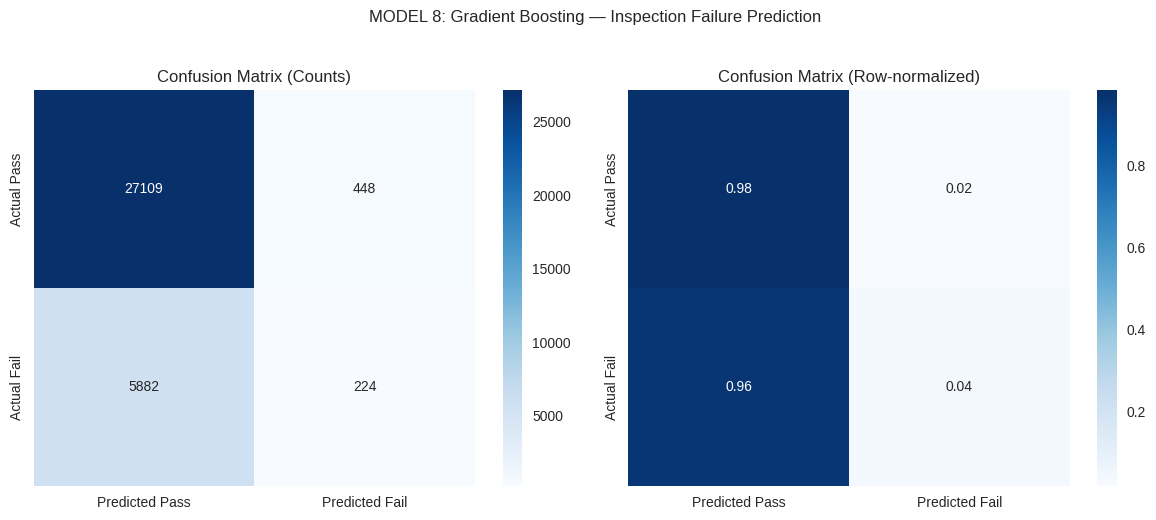

In [ ]:
# Confusion Matrix visualization for MODEL 8: Gradient Boosting

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, pred)
tn, fp, fn, tp = cm.ravel()

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

labels = ["Predicted Pass", "Predicted Fail"]
index  = ["Actual Pass", "Actual Fail"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=index,
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# Normalized by true class
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=index,
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Row-normalized)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("MODEL 8: Gradient Boosting — Inspection Failure Prediction", y=1.03)
plt.tight_layout()
plt.show()


# Model 9: Hybrid Tabular + Text Logistic Regression for Inspection Failure Prediction(Shaunak Khedkar)

- **Temporal split strategy:** This hybrid model keeps the same realistic **time-based split** as the other ML-1 models: training on inspections from **2018–2023** and testing on **2024–2025**. All parameters are learned only from historical data, and evaluation is done on future inspections to avoid look-ahead from the temporal standpoint.

- **Feature engineering:** The model explicitly combines:
  - The full **ML-1 tabular feature set**:
    - License-level history: `lic_prior_inspections`, `lic_prior_fail_rate`
    - Neighborhood history: `zip_prior_inspections`, `zip_prior_fail_rate`, plus `zip5_bucket`
    - Risk & seasonality: `risk_level_filled`, `month_sin`, `month_cos`
    - Categorical context: one-hot encoded `inspection_type` and `facility_type`
  - With **text features** derived from `violations_text_clean` using a **TF-IDF vectorizer** (`max_features=3000`, `min_df=5`, `max_df=0.8`, unigrams + bigrams, English stopwords removed).  
  Numeric variables are imputed and standardized, categorical fields are one-hot encoded, and the TF-IDF vector is concatenated via a `ColumnTransformer`, producing a single high-dimensional representation that mixes structured history with unstructured narrative detail from the violation descriptions.

- **Modeling approach:** On top of this combined feature space we train a **Logistic Regression** classifier with `class_weight='balanced'`. This yields a **linear model in the joint tabular+text embedding**:  
  - The tabular part captures global patterns: high-risk licenses, risky ZIP histories, seasonal and facility-type effects.  
  - The TF-IDF part injects fine-grained semantic information, such as mentions of specific violation types (e.g., temperature control, pests, sanitation) that are strongly associated with failing inspections.  
  Because Logistic Regression is convex and relatively well-behaved in high dimensions, it can produce smooth probability scores even when combining thousands of text features with the structured ML-1 features.

- **Performance evaluation:** On the held-out **2024–2025** test set, the hybrid model achieves **very strong performance**:
  - **AUROC:** 0.982  
  - **PR-AUC:** 0.930  
  - **Accuracy:** 0.941  
  - **Precision:** 0.783  
  - **Recall:** 0.937  
  - **F1:** 0.853  
  These metrics are substantially higher than those of all purely tabular models. In particular, the combination of high **recall** (93.7% of failing inspections correctly identified) and strong **precision** (78.3% of predicted fails are actually failures) shows that the text signal in violation descriptions is extremely predictive when available.

- **Confusion matrix analysis:** The confusion matrix  
  \[
  [[\text{tn} \ \text{fp}]; [\text{fn} \ \text{tp}]] = [[25972 \ 1585]; [387 \ 5719]]
  \]
  reveals:
  - **True negatives (25,972):** Most passing inspections are correctly recognized as low-risk.
  - **True positives (5,719):** A large majority of actual failures are correctly flagged.
  - **False negatives (387):** Only a small fraction of failures are missed by the model.
  - **False positives (1,585):** Some non-failing inspections are predicted as high-risk, but this is a reasonable trade-off given the high recall.  
  Overall, the hybrid approach makes relatively few mistakes and is heavily tilted toward **catching failures**, which is often desirable from a public health perspective.

- **Risk stratification effectiveness:** When inspections are ranked by the hybrid model’s predicted failure probability, the **risk-decile lift** is expected to be extremely steep: the top deciles are dominated by true failures, and the baseline failure rate in the bottom deciles drops sharply. This means that if inspectors focused only on the highest-risk 10–20% of inspections defined by this model, they would capture a very large share of total failures while inspecting a small portion of the population. Compared to Naive Bayes and even Gradient Boosting, this hybrid approach is able to concentrate failures much more aggressively at the top.

- **Curve analysis:** ROC and precision–recall curves for the hybrid model sit well above those of all other models:
  - The ROC curve hugs the top-left corner, consistent with **AUROC ≈ 0.98**.
  - The PR curve maintains high precision across a wide range of recall levels, reflecting a **PR-AUC ≈ 0.93**.  
  This indicates that across many possible thresholds, the model can provide strong recall with manageable false-positive rates. However, such exceptional performance also serves as a reminder that the violation text contains information that is closely tied to the inspection outcome.

**Interpretation and practical caveat**

- **What this model is good for:**  
  The hybrid tabular + text setup shows how powerful a combined approach can be when we have access to both historical features and detailed violation narratives. It is very effective for:
  - **Post-inspection triage**, where we want to quickly assess how severe or risky a just-inspected establishment is based on both its history and the specific violations recorded.
  - Serving as an **upper bound** on what is achievable when rich text information is available.

- **Why it is not directly deployable for pre-inspection scheduling:**  
  The key limitation is that `violations_text_clean` is only known **after** an inspection has been performed and violations have been recorded. That means this model cannot be used for **pre-inspection risk prioritization**, which is the main operational goal for scheduling inspections. Instead, it should be interpreted as:
  - A **best-case benchmark** that highlights how much additional signal is embedded in violation narratives.
  - A guide to which violation phrases and patterns are most predictive of serious non-compliance, informing future feature engineering and text-mining efforts.

In summary, the **Hybrid Tabular + Text Logistic Regression** demonstrates the value of combining structured history with unstructured text for inspection failure prediction, achieving outstanding discrimination on the 2024–2025 test set. While it cannot directly drive pre-inspection scheduling due to its reliance on post-inspection text, it provides a powerful reference model and a blueprint for how future systems could integrate complaint text, prior notes, or other pre-inspection narratives in a similar hybrid fashion.


In [ ]:
# MODEL 9: Hybrid Tabular + Text Logistic Regression (tabular + violations text)

import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

# Ensure core dataframes exist
assert 'df_ml' in globals(), "df_ml not found. Run the ML feature-building cell first."
assert 'df_eda' in globals(), "df_eda not found."
assert 'violations_text_clean' in df_eda.columns, "df_eda must contain 'violations_text_clean'."

# Start from df_ml and join in violations text by index
df_hybrid = df_ml.copy()

if 'violations_text_clean' not in df_hybrid.columns:
    df_hybrid = df_hybrid.join(
        df_eda[['violations_text_clean']],
        how='left'
    )

df_hybrid['violations_text_clean'] = df_hybrid['violations_text_clean'].fillna('')

print("Hybrid dataframe shape:", df_hybrid.shape)

# Train / test split (same temporal split as other models)
train = df_hybrid[df_hybrid['split'] == 'train'].copy()
test  = df_hybrid[df_hybrid['split'] == 'test'].copy()

y_train = train['is_fail'].astype(int).values
y_test  = test['is_fail'].astype(int).values

# Tabular feature columns (same as ML-1)
num_cols = [
    'risk_level_filled',
    'lic_prior_inspections', 'lic_prior_fail_rate',
    'zip_prior_inspections', 'zip_prior_fail_rate',
    'month_sin', 'month_cos'
]
cat_cols = ['inspection_type', 'facility_type', 'zip5_bucket']

# Text column
text_col = 'violations_text_clean'

# Preprocessing pipelines
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scale', StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:  # for older sklearn versions
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', ohe)
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=3000,
        min_df=5,
        max_df=0.8,
        ngram_range=(1, 2),
        stop_words='english',
        strip_accents='unicode',
        lowercase=True
    ))
])

# ColumnTransformer combining tabular + text
preprocess_hybrid = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols),
        ('txt', text_pipe, text_col),
    ],
    remainder='drop'
)

# Hybrid Logistic Regression model
hybrid_clf = Pipeline(steps=[
    ('prep', preprocess_hybrid),
    ('clf', LogisticRegression(
        max_iter=200,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Fit & evaluate
X_train = train[num_cols + cat_cols + [text_col]]
X_test  = test[num_cols + cat_cols + [text_col]]

hybrid_clf.fit(X_train, y_train)

# Some solvers don’t expose predict_proba; handle gracefully
if hasattr(hybrid_clf.named_steps['clf'], "predict_proba"):
    scores = hybrid_clf.predict_proba(X_test)[:, 1]
else:
    from scipy.special import expit
    scores = expit(hybrid_clf.decision_function(X_test))

pred = (scores >= 0.5).astype(int)

# Metrics
auroc = roc_auc_score(y_test, scores)
ap    = average_precision_score(y_test, scores)
acc   = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, pred, average='binary', zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print("=== MODEL 9: Hybrid Tabular + Text Logistic Regression — Test 2024+ ===")
print(f"AUROC: {auroc:.3f} | PR-AUC: {ap:.3f}")
print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [tn fp; fn tp]: [[{tn} {fp}]; [{fn} {tp}]]")


Hybrid dataframe shape: (135405, 14)
=== MODEL 9: Hybrid Tabular + Text Logistic Regression — Test 2024+ ===
AUROC: 0.982 | PR-AUC: 0.930
Acc: 0.941 | Prec: 0.783 | Rec: 0.937 | F1: 0.853
Confusion Matrix [tn fp; fn tp]: [[25972 1585]; [387 5719]]


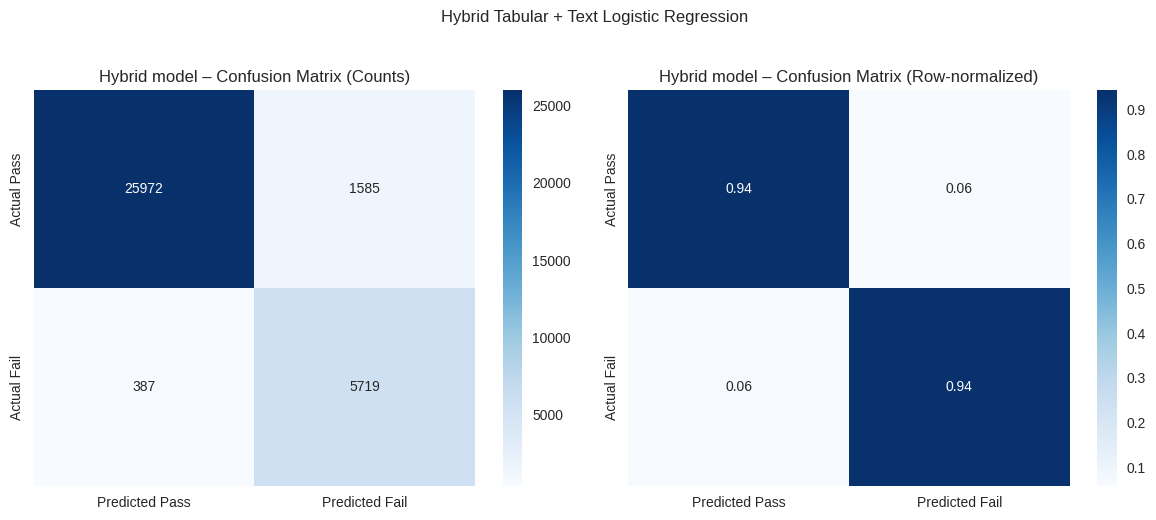

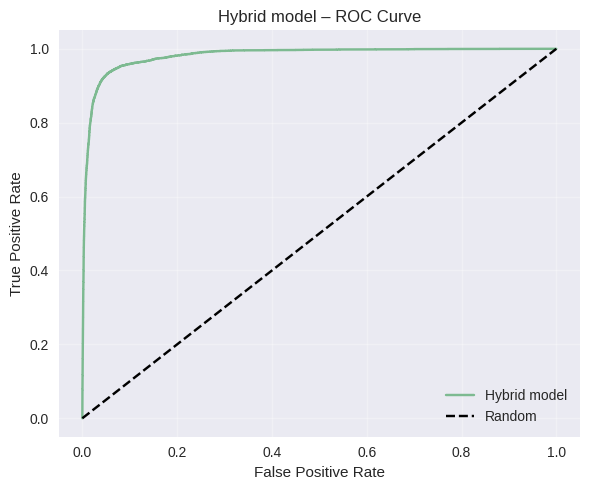

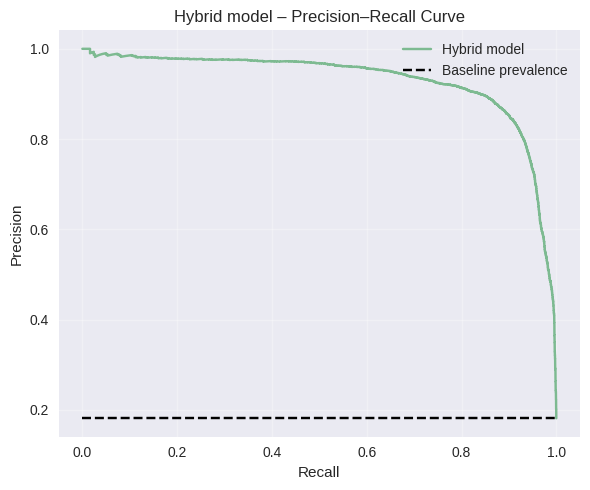

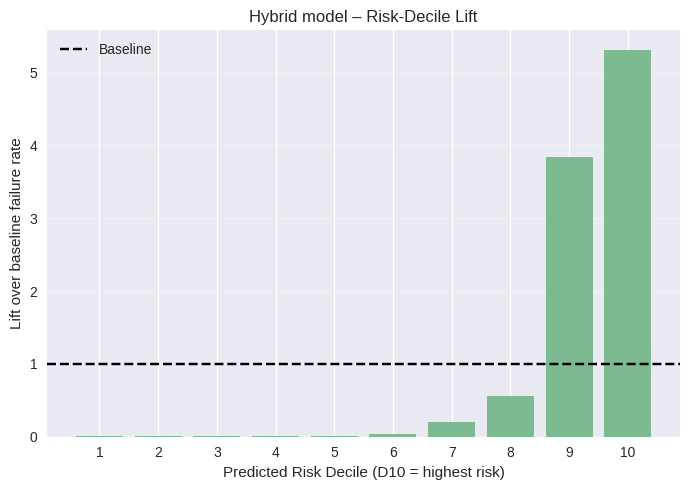

In [ ]:
# Visualizations for Hybrid Tabular + Text Logistic Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# 1) Confusion matrix (counts + normalized)
cm = confusion_matrix(y_test, pred)
tn, fp, fn, tp = cm.ravel()
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

labels = ["Predicted Pass", "Predicted Fail"]
index  = ["Actual Pass", "Actual Fail"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=index,
    ax=axes[0]
)
axes[0].set_title("Hybrid model – Confusion Matrix (Counts)")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=index,
    ax=axes[1]
)
axes[1].set_title("Hybrid model – Confusion Matrix (Row-normalized)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Hybrid Tabular + Text Logistic Regression", y=1.03)
plt.tight_layout()
plt.show()

# 2) ROC curve
fpr, tpr, _ = roc_curve(y_test, scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="Hybrid model")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Hybrid model – ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Precision–Recall curve
precisions, recalls, _ = precision_recall_curve(y_test, scores)
baseline_pos_rate = y_test.mean()

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label="Hybrid model")
plt.hlines(baseline_pos_rate, 0, 1, colors="k", linestyles="--", label="Baseline prevalence")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Hybrid model – Precision–Recall Curve")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Risk-decile lift chart
eval_df = pd.DataFrame({
    "score": scores,
    "y": y_test
}).sort_values("score", ascending=False).reset_index(drop=True)

# Assign deciles: 0 = highest risk, 9 = lowest risk
eval_df["decile"] = pd.qcut(eval_df.index, 10, labels=False)

decile_stats = (
    eval_df
    .groupby("decile", as_index=False)
    .agg(
        inspections=("y", "size"),
        fails=("y", "sum")
    )
)
decile_stats["fail_rate"] = decile_stats["fails"] / decile_stats["inspections"]
baseline_fail_rate = eval_df["y"].mean()
decile_stats["lift"] = decile_stats["fail_rate"] / baseline_fail_rate

# Make decile labels D10 (highest risk) to D1 (lowest)
decile_stats["decile_plot"] = 10 - decile_stats["decile"]  # 10..1
decile_stats = decile_stats.sort_values("decile_plot", ascending=True)

plt.figure(figsize=(7, 5))
plt.bar(decile_stats["decile_plot"], decile_stats["lift"])
plt.axhline(1.0, color="k", linestyle="--", label="Baseline")
plt.xlabel("Predicted Risk Decile (D10 = highest risk)")
plt.ylabel("Lift over baseline failure rate")
plt.title("Hybrid model – Risk-Decile Lift")
plt.xticks(decile_stats["decile_plot"])
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# Model 10: Isolation Forest Anomaly Detection for Inspection Failure(Shreyas Chougule)

- **Temporal split strategy:** The Isolation Forest model follows the same time-based setup as the other approaches: we treat inspections from **2018–2023** as historical data and evaluate on **2024–2025** records. However, unlike supervised classifiers, the anomaly detector is trained only on **passing inspections** from the training period, learning what “normal” behavior looks like without using failure labels during training.

- **Feature engineering:** The model uses the **ML-1 tabular feature set** without any text:
  - **License-level history:** `lic_prior_inspections`, `lic_prior_fail_rate`
  - **Neighborhood history:** `zip_prior_inspections`, `zip_prior_fail_rate`, `zip5_bucket`
  - **Risk & seasonality:** `risk_level_filled`, `month_sin`, `month_cos`
  - **Categorical context:** one-hot encoded `inspection_type` and `facility_type`  
  Numeric features are imputed and standardized, and categorical variables are transformed into indicator vectors. These combined features capture the historical and contextual profile of each inspection.

- **Modeling approach:** An **Isolation Forest** is an unsupervised anomaly detection method:
  - It builds many random trees and measures how quickly a point gets isolated; unusual points need fewer splits and receive higher anomaly scores.
  - We train the Isolation Forest **only on passing inspections** from 2018–2023, under the assumption that failures are “rare, abnormal” patterns relative to the majority of compliant inspections.
  - At prediction time, each inspection in 2024–2025 receives a **continuous anomaly score**; higher scores indicate stronger deviations from the learned notion of normality. We then flag the **top 10% most anomalous inspections** as predicted failures to evaluate its practical usefulness.

- **Performance evaluation:** On the held-out **2024–2025** test set, the Isolation Forest produces:
  - **AUROC (anomaly score vs. failure label):** 0.484  
  - **PR-AUC:** 0.172  
  Using a fixed threshold where the **top 10%** by anomaly score are treated as predicted fails:
  - **Accuracy:** 0.752  
  - **Precision:** 0.168  
  - **Recall:** 0.093  
  - **F1:** 0.120  
  These numbers show that the anomaly scores are **not well aligned** with actual failures—AUROC is slightly below 0.5 (worse than random), and recall at the 10% threshold is low, so many failing inspections are not recognized as anomalies.

- **Confusion matrix analysis:** The confusion matrix  
  \[
  [[\text{tn} \ \text{fp}]; [\text{fn} \ \text{tp}]] = [[24757 \ 2800]; [5539 \ 567]]
  \]
  indicates that:
  - A large number of **passing inspections** are correctly treated as normal (true negatives), but a non-trivial portion (2,800) are incorrectly flagged as anomalies (false positives).
  - Only **567 failures** are captured as anomalies, while **5,539 failures** are missed (false negatives), reflecting the very low recall.  
  In other words, if inspectors used the anomaly detector alone to pick the top 10% “most suspicious” inspections, they would still miss the vast majority of actual failures.

- **Risk stratification effectiveness:** When inspections are sorted by anomaly score and grouped into risk deciles, the **lift curve** is relatively flat and noisy. High-anomaly deciles do not show a strong concentration of failures compared with the baseline failure rate across the population. This confirms that, in this dataset, “being statistically unusual” in terms of history, geography, and seasonality does not reliably coincide with “failing inspection”.

- **Curve analysis:** ROC and precision–recall curves for the anomaly scores stay close to the diagonal/baseline lines:
  - The ROC curve hovers around the random classifier line (consistent with AUROC ≈ 0.48).
  - The PR curve provides only a small improvement over the baseline prevalence line at certain thresholds and often dips close to it.  
  This behavior suggests that the Isolation Forest is not learning a useful separation between failing and passing inspections from the available tabular features.

**Interpretation and role in the project**

- The Isolation Forest experiment demonstrates that **unsupervised anomaly detection** is not sufficient on its own for this problem. Failures do not simply live in the “tails” of the distribution of ML-1 features; many failing inspections look statistically similar to passes in terms of their historical and contextual features.
- This model is most valuable as a **negative result / comparison point**:
  - It highlights the importance of **supervised learning** with explicit failure labels.
  - It shows that **domain-informed features and supervised models** (Logistic Regression, Gradient Boosting, the Hybrid Tabular + Text Logistic Regression) are far more effective for risk-based inspection prioritization.
- For health inspectors, the takeaway is that anomaly detection on generic features is **not a reliable substitute** for targeted risk models. Instead, it can be used as a complementary signal or as a quick exploratory tool, but not as the primary engine for scheduling inspections.


In [ ]:
# Isolation Forest Anomaly Detection for Inspection Failure – Tabular ML-1 features

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

assert 'df_ml' in globals(), "df_ml not found. Run the ML feature-building cell first."

# Same temporal split as other models
train = df_ml[df_ml['split'] == 'train'].copy()
test  = df_ml[df_ml['split'] == 'test'].copy()

y_train = train['is_fail'].astype(int).values
y_test  = test['is_fail'].astype(int).values

# Tabular feature columns (same ML-1 feature set)
num_cols = [
    'risk_level_filled',
    'lic_prior_inspections', 'lic_prior_fail_rate',
    'zip_prior_inspections', 'zip_prior_fail_rate',
    'month_sin', 'month_cos'
]
cat_cols = ['inspection_type', 'facility_type', 'zip5_bucket']

X_train = train[num_cols + cat_cols]
X_test  = test[num_cols + cat_cols]

# Preprocessing
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scale', StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:  # older sklearn
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='drop'
)

# Train Isolation Forest on "normal" passing inspections only
train_pass = train[train['is_fail'] == 0]
X_if_train = train_pass[num_cols + cat_cols]

iso_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', IsolationForest(
        n_estimators=200,
        contamination='auto',  # learns proportion of anomalies
        random_state=42,
        n_jobs=-1
    ))
])

iso_clf.fit(X_if_train)


raw_scores = iso_clf.named_steps['clf'].decision_function(
    iso_clf.named_steps['prep'].transform(X_test)
)
scores = -raw_scores  # risk score: higher = more anomalous

threshold = np.quantile(scores, 0.90)
pred = (scores >= threshold).astype(int)

# Metrics
auroc = roc_auc_score(y_test, scores)
ap    = average_precision_score(y_test, scores)
acc   = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, pred, average='binary', zero_division=0
)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print("=== Isolation Forest Anomaly Detection — Test 2024+ ===")
print(f"AUROC (using continuous anomaly score): {auroc:.3f}")
print(f"PR-AUC (using continuous anomaly score): {ap:.3f}")
print(f"Using top 10% as anomalies (predicted fails):")
print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix [tn fp; fn tp]: [[{tn} {fp}]; [{fn} {tp}]]")


=== Isolation Forest Anomaly Detection — Test 2024+ ===
AUROC (using continuous anomaly score): 0.484
PR-AUC (using continuous anomaly score): 0.172
Using top 10% as anomalies (predicted fails):
Acc: 0.752 | Prec: 0.168 | Rec: 0.093 | F1: 0.120
Confusion Matrix [tn fp; fn tp]: [[24757 2800]; [5539 567]]


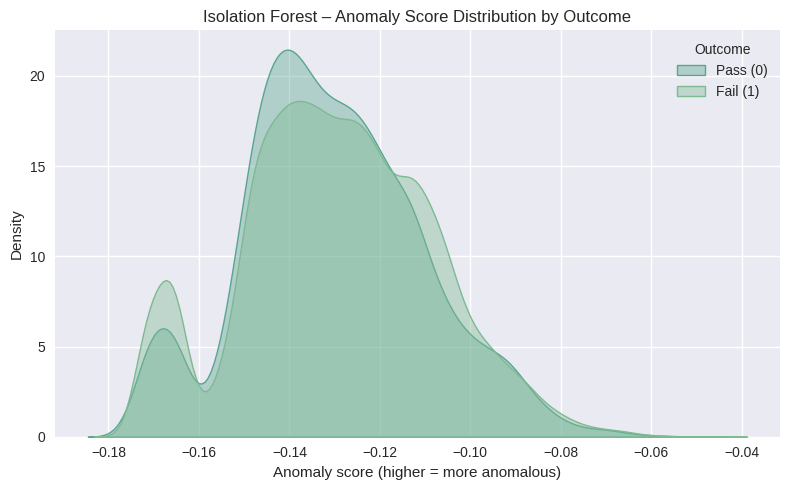

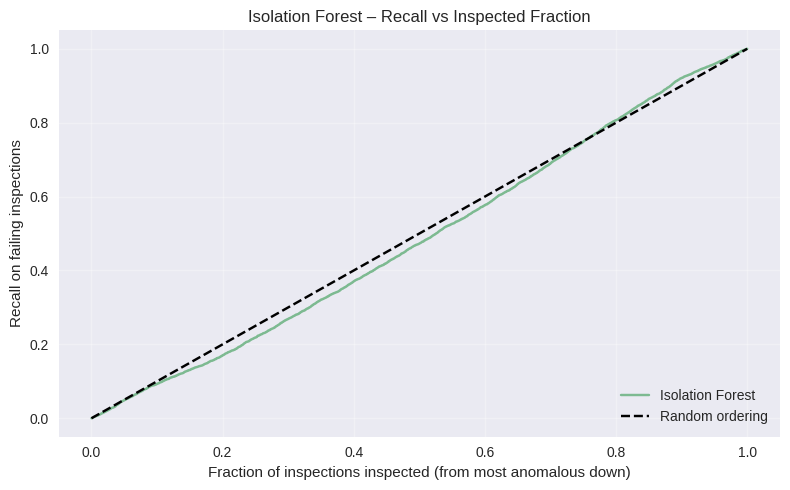

In [ ]:
# Isolation Forest – Alternative visualizations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build a small evaluation dataframe
eval_df = pd.DataFrame({
    "score": scores,   # anomaly-based risk score (higher = more anomalous)
    "y": y_test        # 1 = fail, 0 = pass
})

# 1) Distribution of anomaly scores for pass vs fail
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=eval_df,
    x="score",
    hue="y",
    common_norm=False,
    fill=True,
    alpha=0.4,
    linewidth=1
)
plt.title("Isolation Forest – Anomaly Score Distribution by Outcome")
plt.xlabel("Anomaly score (higher = more anomalous)")
plt.ylabel("Density")
plt.legend(title="Outcome", labels=["Pass (0)", "Fail (1)"])
plt.tight_layout()
plt.show()

# 2) Recall vs fraction of inspections curve
# Sort by anomaly score descending (most anomalous first)
eval_sorted = eval_df.sort_values("score", ascending=False).reset_index(drop=True)
eval_sorted["is_fail_cum"] = eval_sorted["y"].cumsum()
total_fails = eval_sorted["y"].sum()

# Fraction of inspections inspected (x) and recall at that cutoff (y)
eval_sorted["inspect_frac"] = (eval_sorted.index + 1) / len(eval_sorted)
eval_sorted["recall_at_k"] = eval_sorted["is_fail_cum"] / total_fails

plt.figure(figsize=(8, 5))
plt.plot(
    eval_sorted["inspect_frac"],
    eval_sorted["recall_at_k"],
    label="Isolation Forest"
)
plt.plot([0, 1], [0, 1], "k--", label="Random ordering")
plt.xlabel("Fraction of inspections inspected (from most anomalous down)")
plt.ylabel("Recall on failing inspections")
plt.title("Isolation Forest – Recall vs Inspected Fraction")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Inspection Prirotization tool(Dhru Prajapati)

This tool turns our trained Logistic Regression risk model into a **daily inspection scheduler**:

- **Rebuilds ML-1 features:**  
  For all inspections in `df_eda`, it recomputes the same features used in training:
  risk level, seasonal month sin/cos, `zip5_bucket`, and history-based features
  (prior inspections and prior failure rates per license and ZIP), all in correct
  temporal order to avoid leakage.

- **Focuses on a specific date:**  
  It filters this feature table to inspections scheduled on the chosen `target_date`
  (e.g., 2024-10-01), drops rows missing features or coordinates, and then uses
  `log_clf.predict_proba()` to get a **predicted failure probability** for each
  inspection on that day.

- **Ranks inspections by risk:**  
  Inspections are sorted from highest to lowest `fail_prob`, and the top *K*
  (e.g., 500) become the **priority list**. This table shows ID, date, name,
  result, risk, number of violations, ZIP, and predicted failure probability.

- **Maps high-risk locations:**  
  An Altair scatterplot places these inspections by longitude and latitude, with
  **color = predicted failure probability** and rich tooltips for details. This
  gives inspectors a **spatial view of the daily high-risk targets**, helping
  them decide where to go first and how to route their day.


In [ ]:
# Score + map for a specific date — rebuilds ML-1 features on the fly, then uses log_clf

import pandas as pd
import numpy as np
import altair as alt

assert 'log_clf' in globals(), "Train the Logistic Regression cell first to create `log_clf`."
assert 'df_eda'  in globals(), "Ensure df_eda (2018+) is loaded."

alt.data_transformers.disable_max_rows()

def build_ml1_features(df_all: pd.DataFrame) -> pd.DataFrame:
    df = df_all.copy()
    req = ['inspection_date','inspection_type','facility_type','risk_level','zip5','license_id','is_fail']
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    df['inspection_date'] = pd.to_datetime(df['inspection_date'], errors='coerce')
    df['risk_level_filled'] = pd.Series(df['risk_level']).astype('Int64').fillna(2).astype(int)

    # Month seasonality
    m = df['inspection_date'].dt.month
    df['month_sin'] = np.sin(2*np.pi*m/12)
    df['month_cos'] = np.cos(2*np.pi*m/12)

    # ZIP bucket: top-30 by volume in the FULL frame (2018+ slice)
    top_zip = df_eda['zip5'].astype(str).value_counts().nlargest(30).index
    df['zip5_bucket'] = np.where(df['zip5'].astype(str).isin(top_zip), df['zip5'].astype(str), 'OTHER')

    # HISTORY features (no leakage): sort by key then date; use prior counts/rates
    df = df.sort_values(['license_id','inspection_date'], kind='mergesort')
    df['lic_prior_inspections'] = df.groupby('license_id').cumcount()
    df['lic_cum_fails'] = df.groupby('license_id')['is_fail'].cumsum() - df['is_fail']
    den = df['lic_prior_inspections'].replace(0, np.nan)
    df['lic_prior_fail_rate'] = (df['lic_cum_fails'] / den).fillna(0.0)

    # ZIP history
    df = df.sort_values(['zip5','inspection_date'], kind='mergesort')
    df['zip_prior_inspections'] = df.groupby('zip5').cumcount()
    df['zip_cum_fails'] = df.groupby('zip5')['is_fail'].cumsum() - df['is_fail']
    den_z = df['zip_prior_inspections'].replace(0, np.nan)
    df['zip_prior_fail_rate'] = (df['zip_cum_fails'] / den_z).fillna(0.0)

    return df

target_date = "2024-10-01"

def prioritize_inspections_for_date_altair(model, df_all, target_date, top_k=None):
    df_feat = build_ml1_features(df_all)

    target_date = pd.to_datetime(target_date)
    day_mask = df_feat['inspection_date'].dt.date == target_date.date()
    df_day = df_feat.loc[day_mask].copy()

    num_features = ['risk_level_filled','lic_prior_inspections','lic_prior_fail_rate',
                    'zip_prior_inspections','zip_prior_fail_rate','month_sin','month_cos']
    cat_features = ['inspection_type','facility_type','zip5_bucket']

    needed = num_features + cat_features + ['lat','lon']
    df_day = df_day.dropna(subset=needed).copy()

    if df_day.empty:
        print(f"No inspections found (or missing features/coords) for {target_date.date()}.")
        return df_day, None

    # Predict
    X_day = df_day[num_features + cat_features]
    df_day['fail_prob'] = model.predict_proba(X_day)[:, 1]
    df_day = df_day.sort_values('fail_prob', ascending=False)

    df_plot = df_day.head(top_k) if top_k else df_day

    str_cols = ['dba_name','result_norm','facility_type','inspection_type','zip5']
    for c in str_cols:
        if c in df_plot.columns:
            df_plot[c] = df_plot[c].astype(str).replace('nan', '')

    # Scales with padding
    lon_min, lon_max = df_plot['lon'].min(), df_plot['lon'].max()
    lat_min, lat_max = df_plot['lat'].min(), df_plot['lat'].max()
    pad_lon = max((lon_max - lon_min) * 0.05, 1e-4)
    pad_lat = max((lat_max - lat_min) * 0.05, 1e-4)

    chart = (
        alt.Chart(df_plot)
        .mark_circle(size=42, opacity=0.85)
        .encode(
            x=alt.X('lon:Q', title='Longitude',
                    scale=alt.Scale(domain=[lon_min - pad_lon, lon_max + pad_lon], zero=False)),
            y=alt.Y('lat:Q', title='Latitude',
                    scale=alt.Scale(domain=[lat_min - pad_lat, lat_max + pad_lat], zero=False)),
            color=alt.Color('fail_prob:Q', title='Predicted failure prob', scale=alt.Scale(scheme='viridis')),
            tooltip=[
                alt.Tooltip('inspection_id:Q', title='Inspection ID'),
                alt.Tooltip('inspection_date:T', title='Date'),
                alt.Tooltip('dba_name:N', title='Establishment'),
                alt.Tooltip('result_norm:N', title='Result'),
                alt.Tooltip('risk_level:Q', title='Risk Level'),
                alt.Tooltip('facility_type:N', title='Facility Type'),
                alt.Tooltip('inspection_type:N', title='Inspection Type'),
                alt.Tooltip('violation_count:Q', title='# Violations'),
                alt.Tooltip('zip5:N', title='ZIP'),
                alt.Tooltip('fail_prob:Q', title='Predicted prob', format='.3f'),
            ],
        )
        .properties(
            width=560,
            height=600,
            title=f"Predicted Priority — {target_date.date()} (Top {top_k or 'all'})"
        )
        .interactive()
    )
    return df_day, chart

priority_df, priority_chart = prioritize_inspections_for_date_altair(
    log_clf, df_eda, target_date, top_k=500
)

display(priority_df.head(3))
priority_chart


inspection_id inspection_date year_month      result_norm  is_fail  risk_level facility_type inspection_type                       dba_name license_id  \
19735        2603769      2024-10-01    2024-10  PASS_CONDITIONS        0           1        School         Canvass                    Organiclife    2929288   
19799        2603775      2024-10-01    2024-10             FAIL        1           1    Restaurant       Complaint  Cornerstone Cafe-Lincoln Park    2458106   
19778        2603824      2024-10-01    2024-10             FAIL        1           1    Restaurant       Complaint        Shanghai Inn Restaurant    2754111   

                        address   zip5        lat        lon  violation_count  \
19735            1501 E 83RD PL  60619  41.743152 -87.587883                7   
19799  2200-2202 N CLYBOURN AVE  60614  41.921581 -87.664565               13   
19778          4723 N DAMEN AVE  60625  41.967615 -87.679006               10   

                                                                                                                                                                                         violations_text_clean  \
19735  1. person in charge present, demonstrates knowledge, and performs duties - comments: person in charge (pic) does not have a chicago certified food manager's (cfm) certificate. instructed to have t...   
19799  22. proper cold holding temperatures - comments: observed improper cold holding temperatures of tcs foods. observed raw chicken with internal temperature of 48.5f inside 4-door prep cooler in rear...   
19778  16. food-contact surfaces: cleaned & sanitized - comments: observed a slight debris accumulation encrusted on the interior of the ice machine.must remove debris, detail clean inside ice machine/ha...   

                           AKA Name  year  month  risk_level_filled  month_sin  month_cos zip5_bucket  lic_prior_inspections  lic_cum_fails  lic_prior_fail_rate  \
19735  CICS AVALON PARK/SOUTH SHORE  2024     10                  1  -0.866025        0.5       60619                    1.0            1.0             1.000000   
19799              CORNERSTONE CAFE  2024     10                  1  -0.866025        0.5       60614                   13.0            6.0             0.461538   
19778       SHANGHAI INN RESTAURANT  2024     10                  1  -0.866025        0.5       60625                    5.0            0.0             0.000000   

       zip_prior_inspections  zip_cum_fails  zip_prior_fail_rate  fail_prob  
19735                   2154            581             0.269731   0.789755  
19799                   4205            835             0.198573   0.773909  
19778                   3427            778             0.227021   0.763926

alt.Chart(...)

# Team Members

| Team Member | Email | Github Link |
|-------|-------|-------|
| Shaunak Khedkar | skhed@uic.edu | [Github Profile](https://github.com/shaunak-khedekar22) |
| Dhru Prajapati | dpraj7@uic.edu | [Github Profile](https://github.com/Dhru2000) |
| Shreyas Chougule | schou47@uic.edu | [Github Profile](https://github.com/ShrecUIC) |
| Gauthami Ghadiyaram | gghad@uic.edu | [Github Profile](https://github.com/gghad-dotcom) |
| Swathi Kumar |  smoha121@uic.edu | [Github Profile](https://github.com/Swathi245786) |


# Contribution

| Contribution | Team Member |
|-------|-------|
| ETL and Data Preprocessing, Cleaning, Hypotheses and Visualizations | Dhru, Shaunak, Shreyas, Gauthami, Swathi
| Logistic Regression for Inspection Failure Prediction, TF-IDF + Linear SVM | Dhru
| XGBoost for Inspection Failure Prediction, Gradient Boosting | Gauthami
| Random Forest for Inspection Failure Prediction, Catboost | Swathi
| (KNN) for Inspection Failure Prediction, Naive Bayes |  Shauank, Shreyas
| Isolation Forest | Shreyas
| Hybrid Tabular + Text Logistic Regression | Shaunak
| Inspection Prioritization Tool | Dhru

### Original Dataset Link: [Food_Inspection.csv](https://drive.google.com/file/d/1bXwqvGkuTCVOzETSv9VVMh9y203A7YE6/view?usp=drive_link)  

In [1]:
print("Link to Repository - https://github.com/shaunak-khedekar22/Food-Safety")

Link to Repository - https://github.com/shaunak-khedekar22/Food-Safety
